# ** DIscBIO: a user-friendly pipeline for biomarker discovery in single-cell transcriptomics**

The pipeline consists of four successive steps: data pre-processing, cellular clustering and pseudo-temporal ordering, determining differential expressed genes and identifying biomarkers.

![DIsccBIO](DiscBIO.png)

## Required Packages

In [1]:
library(DIscBIO)
library(partykit)
library(enrichR)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tap

## Loading dataset

The dataset should be formatted in a data frame where columns refer to samples and rows refer to genes. 
We provide here the possibility to load the dataset either as ".csv" or ".rda" extensions.

In [2]:
FileName<-"CTCdataset"       # Name of the dataset
#CSV=TRUE                     # If the dataset has ".csv", the user shoud set CSV to TRUE
CSV=FALSE                   # If the dataset has ".rda", the user shoud set CSV to FALSE

if (CSV==TRUE){
    DataSet <- read.csv(file = paste0(FileName,".csv"), sep = ",",header=T)
    rownames(DataSet)<-DataSet[,1]
    DataSet<-DataSet[,-1]
} else{
    load(paste0(FileName,".rda"))
    DataSet<-get(FileName)
}
cat(paste0("The ", FileName," contains:","\n","Genes: ",length(DataSet[,1]),"\n","cells: ",length(DataSet[1,]),"\n"))

The CTCdataset contains:
Genes: 13181
cells: 1462


In [3]:
sc<- DISCBIO(DataSet)       # The DISCBIO class is the central object storing all information generated throughout the pipeline 

## 1. Data Pre-processing

Prior to applying data analysis methods, it is standard to pre-process the raw read counts resulted from the sequencing. The preprocessing approach depends on the existence or absence of ERCC spike-ins. In both cases, it includes normalization of read counts and gene filtering. 

#### Normalization of read counts
To account for RNA composition and sequencing depth among samples (single-cells), the normalization method “median of ratios” is used. This method takes the ratio of the gene instantaneous median to the total counts for all genes in that cell (column median). The gene instantaneous median is the product of multiplying the median of the total counts across all cells (row median) with the read of the target gene in each cell. This normalization method makes it possible to compare the normalized counts for each gene equally between samples.

#### Gene filtering
The key idea in filtering genes is to appoint the genes that manifest abundant variation across samples. Filtering genes is a critical step due to its dramatic impact on the downstream analysis. In case the raw data includes ERCC spike-ins, genes will be filtered based on variability in comparison to a noise level estimated from the ERCC spike-ins according to an algorithm developed by Brennecke et al (Brennecke et al., 2013). This algorithm utilizes the dependence of technical noise on the average read count and fits a model to the ERCC spike-ins. Further gene filtering can be implemented based on gene expression.
In case the raw data does not include ERCC spike-ins, genes will be only filtered based on minimum expression in certain number of cells.


![DataPre-processing](Data-Preprocessing.png)

### 1.2. Filtering and normalizing the raw data that does not include ERCCs

To normalize and filter the raw data that does not include ERCCs can be done by applying the function Normalizedata() and giving  the parameters minexpr and minnumber some values. This function will discard cells with less than mintotal transcripts. Genes that are not expressed at minexpr transcripts in at least minnumber cells are discarded. Furthermore, it will normalize the count reads using the normalization method “median of ratios”.
          
To Finalize the preprocessing the function FinalPreprocessing() should be implemented by setting the parameter "GeneFlitering" to ExpF.

In [4]:
# Estimating a value for the "mintotal" parameters
# As a common practice, mintotal is set to 1000
S1<-summary(colSums(DataSet,na.rm=TRUE))            # It gives an idea about the number of reads across cells
print(S1) 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
     844     1916     4070   436014    38916 12865982 


In [5]:
# Estimating a value for the "minexpr" parameter
S2<-summary(rowMeans(DataSet,na.rm=TRUE))            # It gives an idea about the overall expression of the genes
print(S2)                                                 
minexpr= S2[3]                                       # S2[3] is referring to the median whereas S2[4] is referring to the mean

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00     1.38     7.14    33.08    21.91 34476.42 


In [6]:
# Estimating a value for the "minnumber" parameters
minnumber= round(length(DataSet[1,])/10)                             # To be expressed in at 10% of the cells.
print(minnumber)

[1] 146


In [7]:
sc<-Normalizedata(sc, mintotal=1000, minexpr=minexpr, minnumber=minnumber, maxexpr=Inf, downsample=FALSE, dsn=1, rseed=17000) 
sc<-FinalPreprocessing(sc,GeneFlitering="ExpF",export = TRUE)        # The GeneFiltering should be set to "ExpF"

The gene filtering method = Noise filtering

The Filtered Normalized dataset contains:
Genes: 215
cells: 1448



The Filtered Normalized dataset was saved as: filteredDataset.Rdata



## 2. Cellular Clustering and Pseudo Time ordering

Cellular clustering is performed according to the gene expression profiles to detect cellular sub-population with unique properties. After clustering, pseudo-temporal ordering is generated to indicate the cellular differentiation degree. 

![PSCAN](Clustering.png)

## 2.1. K-means Clustering

Rare cell type Identification algorithm (RaceID) was used to cluster the pre-processed data using k-means on a similarity distance matrix, which was based on Pearson correlation and the similarity matrix was computed as “1 – Pearson correlation”. The approach of the proposed clustering, i.e., applying k-means on a similarity distance matrix using the Euclidean metric, improves cluster separation. RaceID estimates the number of clusters by finding the minimal clusters' number at the saturation level of gap statistics, which standardizes the within-cluster dispersion. 

The Clustexp() functions has several parameters:
- object: the outcome of running the DISCBIO() function.
- clustnr Maximum number of clusters for the derivation of the cluster number by the saturation of mean within-cluster dispersion. Default is 20.
- bootnr A numeric value of booststrapping runs for \code{clusterboot}. Default is 50.
- metric Is the method to transform the input data to a distance object. 
- Metric has to be one of the following: ["spearman","pearson","kendall","euclidean","maximum","manhattan","canberra","binary","minkowski"]. 
- do.gap A logical vector that allows generating the number of clusters based on the gap statistics. Default is TRUE.
- SE.method The SE.method determines the first local maximum of the gap statistics. 
- The SE.method has to be one of the following:["firstSEmax","Tibs2001SEmax","globalSEmax","firstmax","globalmax"]. Default is "Tibs2001SEmax"
- SE.factor A numeric value of the fraction of the standard deviation by which the local maximum is required to differ from the neighboring points it is compared to. Default is 0.25.
- B.gap Number of bootstrap runs for the calculation of the gap statistics. Default is 50
- cln Number of clusters to be used. Default is \code{NULL} and the cluster number is inferred by the saturation criterion.
- rseed Integer number. Random seed to enforce reproducible clustering results. Default is 17000.
- quiet if `TRUE`, intermediate output is suppressed

![DIsccBIO](KM1.png)

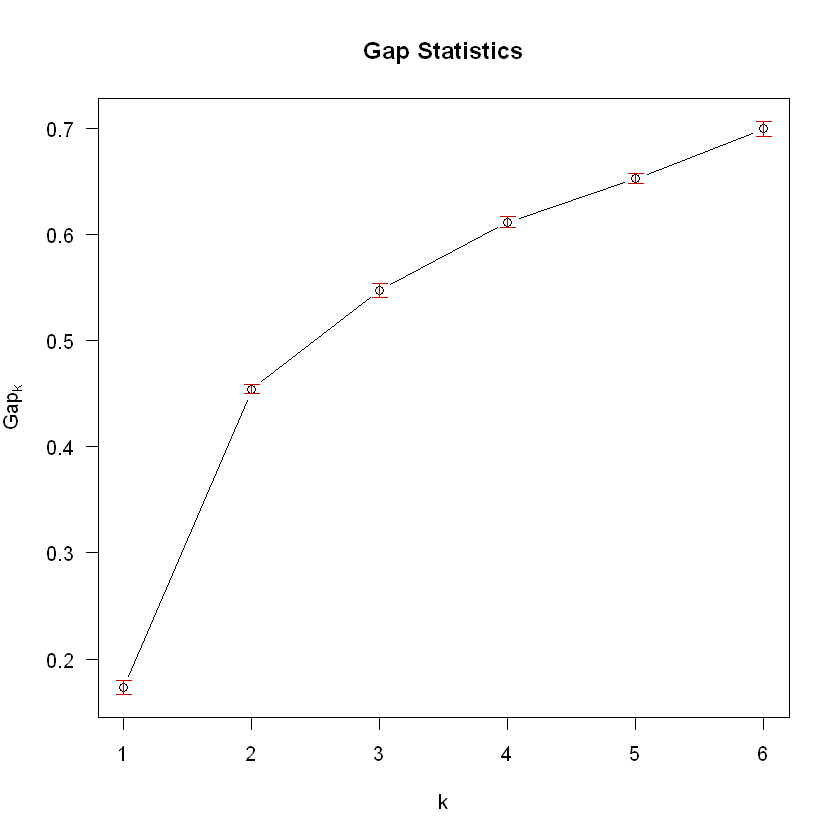

In [8]:
K= 4                                                      # Getting 4 clusters
sc<- Clustexp(sc,cln=K,quiet=T,clustnr=6,rseed=17000)    
plotGap(sc)                                               ### Plotting gap statistics

#### 2.1.1. Defining the Cells in the clusters generated by k-means clustering

In [9]:
sc<- comptSNE(sc,rseed=15555,quiet = T)          # to perform the computation of a t-SNE map
#print(sc@cpart)                                 # to show the clusters with the cell-ID

#### 2.1.2- Evaluating the stability and consistancy of the clusters

DIscBIO enables the robustness assessment of the detected clusters in terms of stability and consistency using Jaccard’s similarity statistics and silhouette coefficients. Jaccard’s similarity index provides a comparison of members among clusters to evaluate the stability of the clusters with a range from 0% to 100%. The higher the percentage, the more stable the cluster is. Silhouette coefficients estimate how close each sample in one cluster is to samples in the neighboring clusters, reflecting the consistency of each cluster with a range of [-1, 1]. The higher the cluster mean coefficient, the more consistent the cluster is.

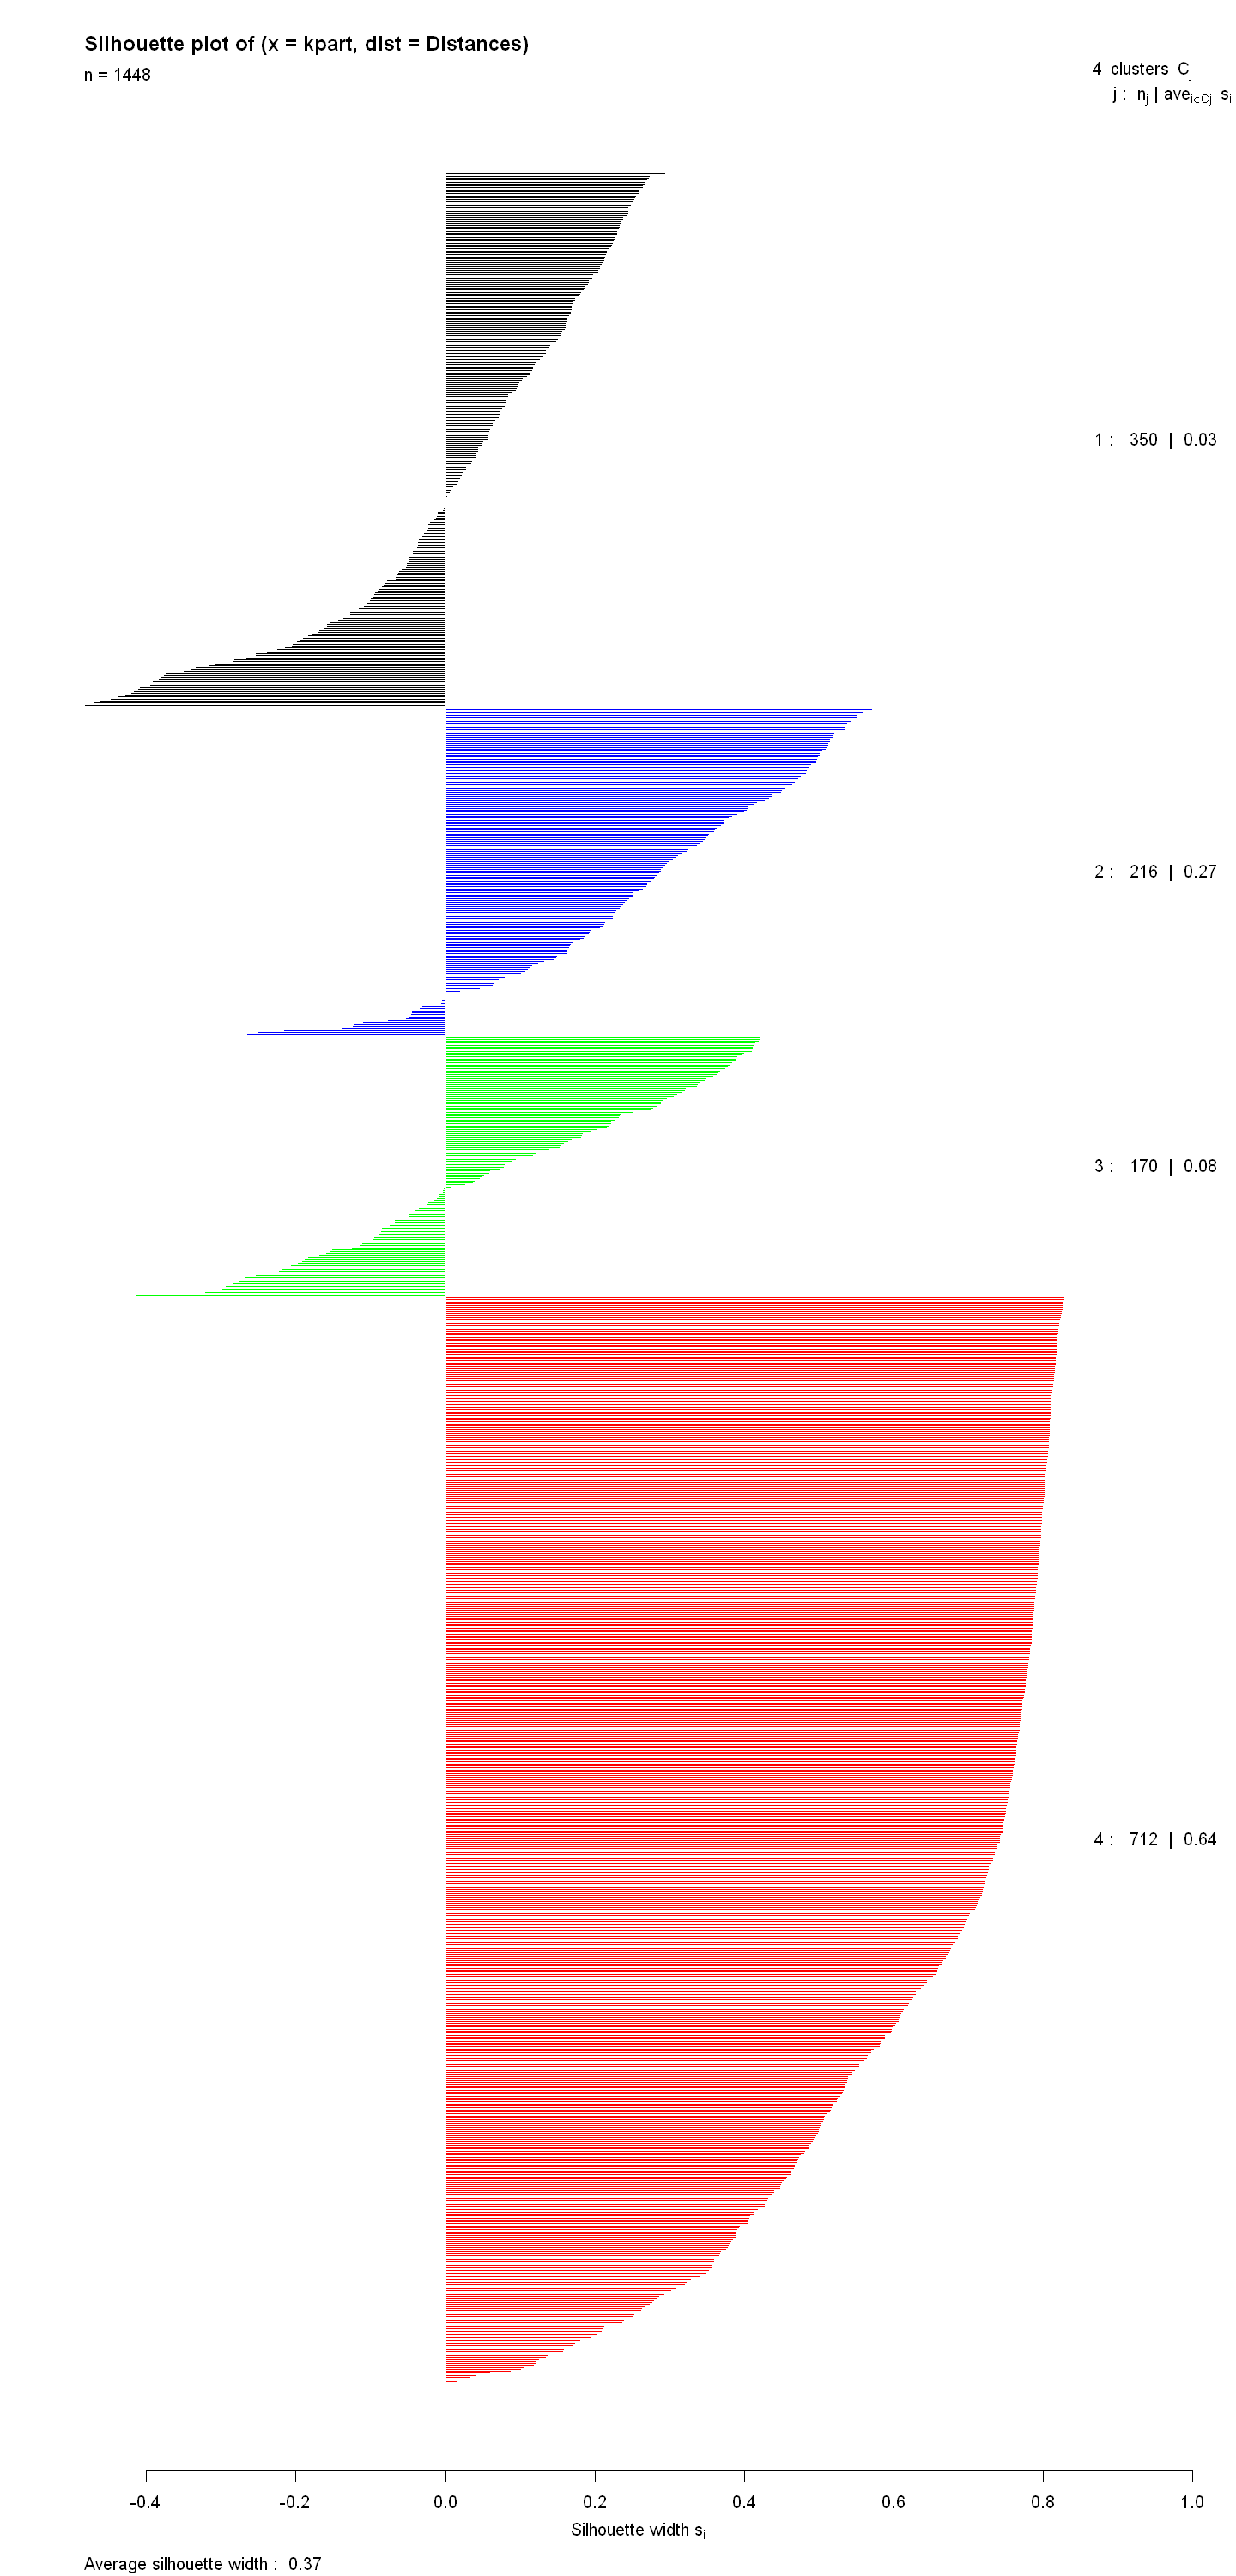

In [10]:
# Silhouette plot
options(repr.plot.width=12, repr.plot.height=25)
plotSilhouette(sc,K=4)       # K is the number of clusters

[1] 0.427 0.648 0.326 0.602

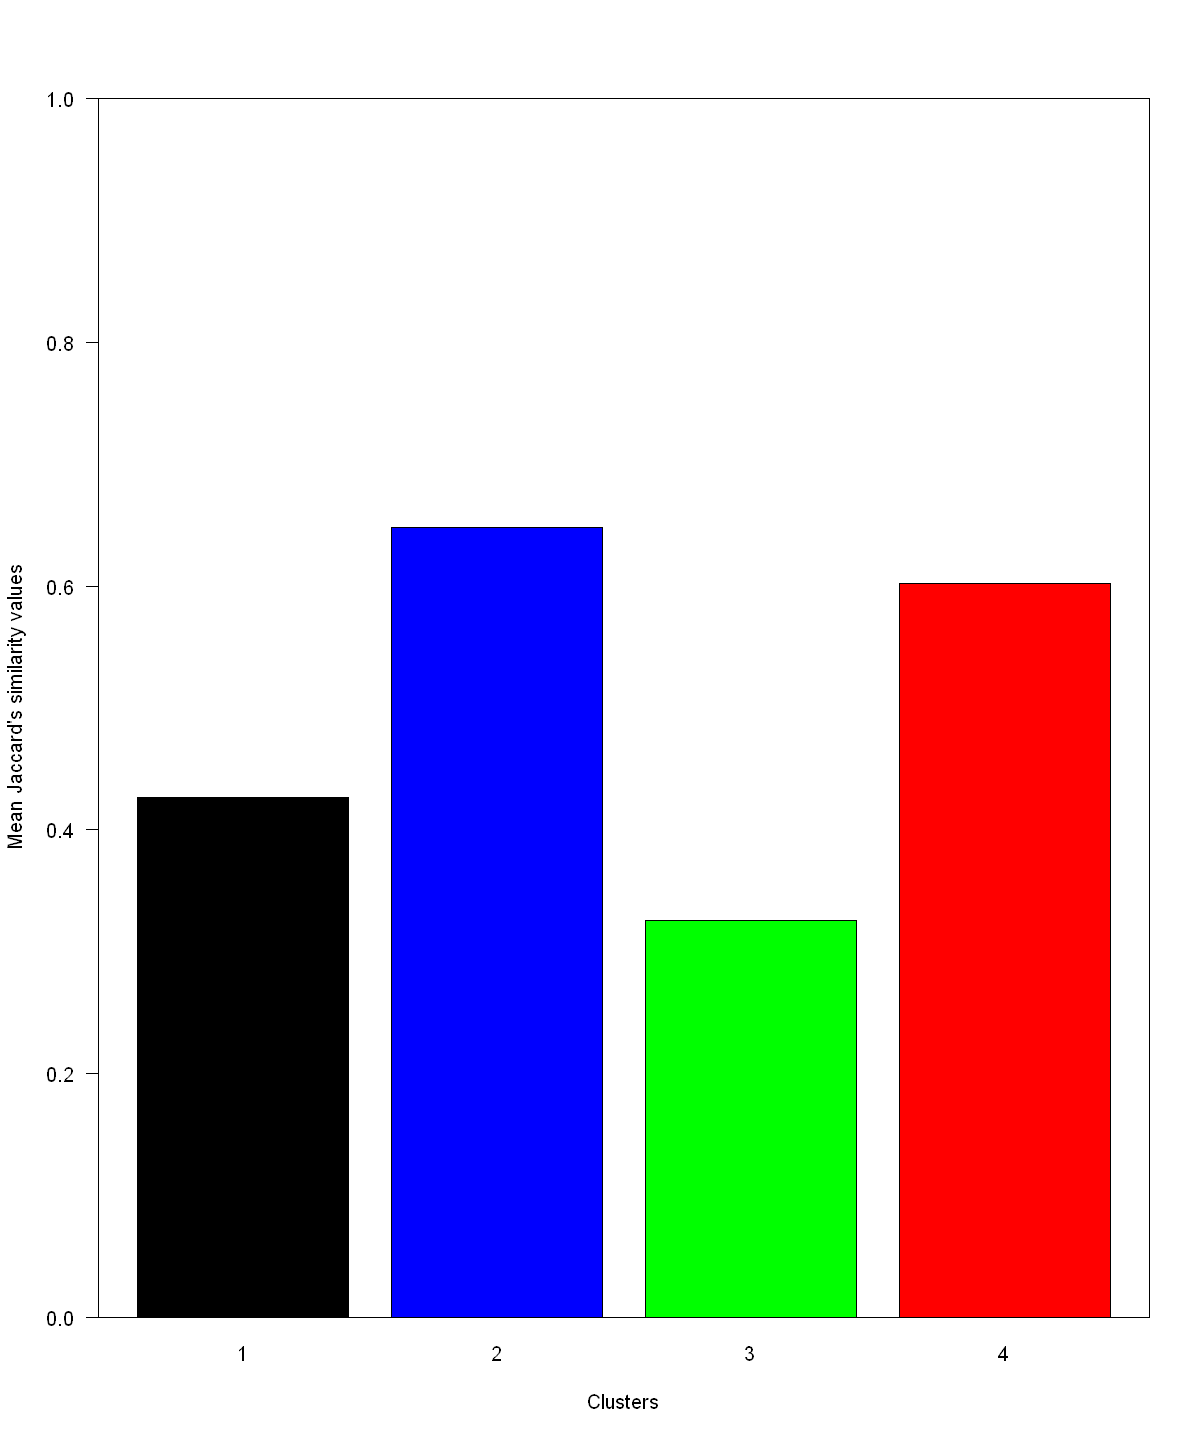

In [11]:
# Jaccard Plot
options(repr.plot.width=10, repr.plot.height=12)
Jaccard(sc,Clustering="K-means", K=4, plot = TRUE)     # Jaccard 

#### 2.1.3. Cluster plotting using tSNE maps

Here you visualize the K-means clusters using t-distributed stochastic neighbor embedding (tSNE), which is a non-linear dimensionality reduction method that places neighbor cells close to each other. 

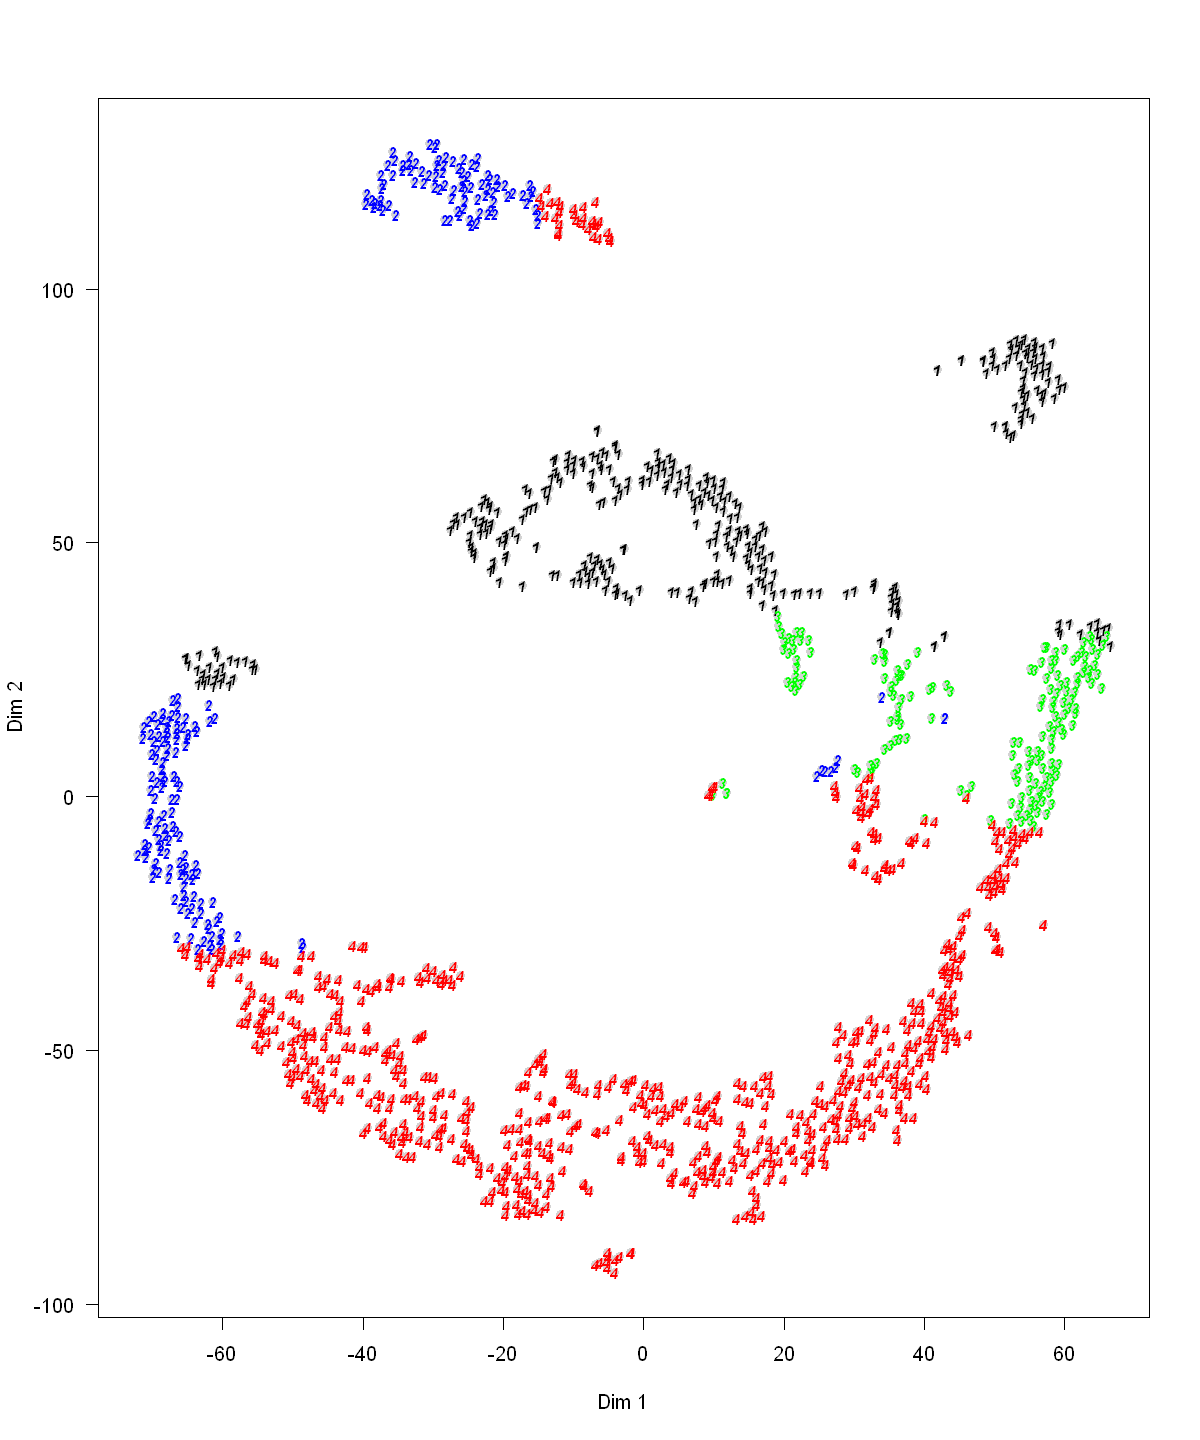

In [12]:
############ Plotting the clusters
plottSNE(sc)

#### Defining outlier cells based on K-means Clustering

Outlier identification is implemented using a background model based on distribution of transcript counts within a cluster. Outlier cells are detected if the probability for that cell c that a minimum number of genes Gmin of observing total counts TGmin is less than a specific threshold Pthr, as given by the red dotted line. Outlier cells in K-means clusters can be detected by running the FindOutliersKM() function.
 
In case the user decided to remove outlier cells, the user should set RemovingOutliers to TRUE and then start from the beginning (Data Pre-processing). 

The following cells are considered outliers: 




named integer(0)


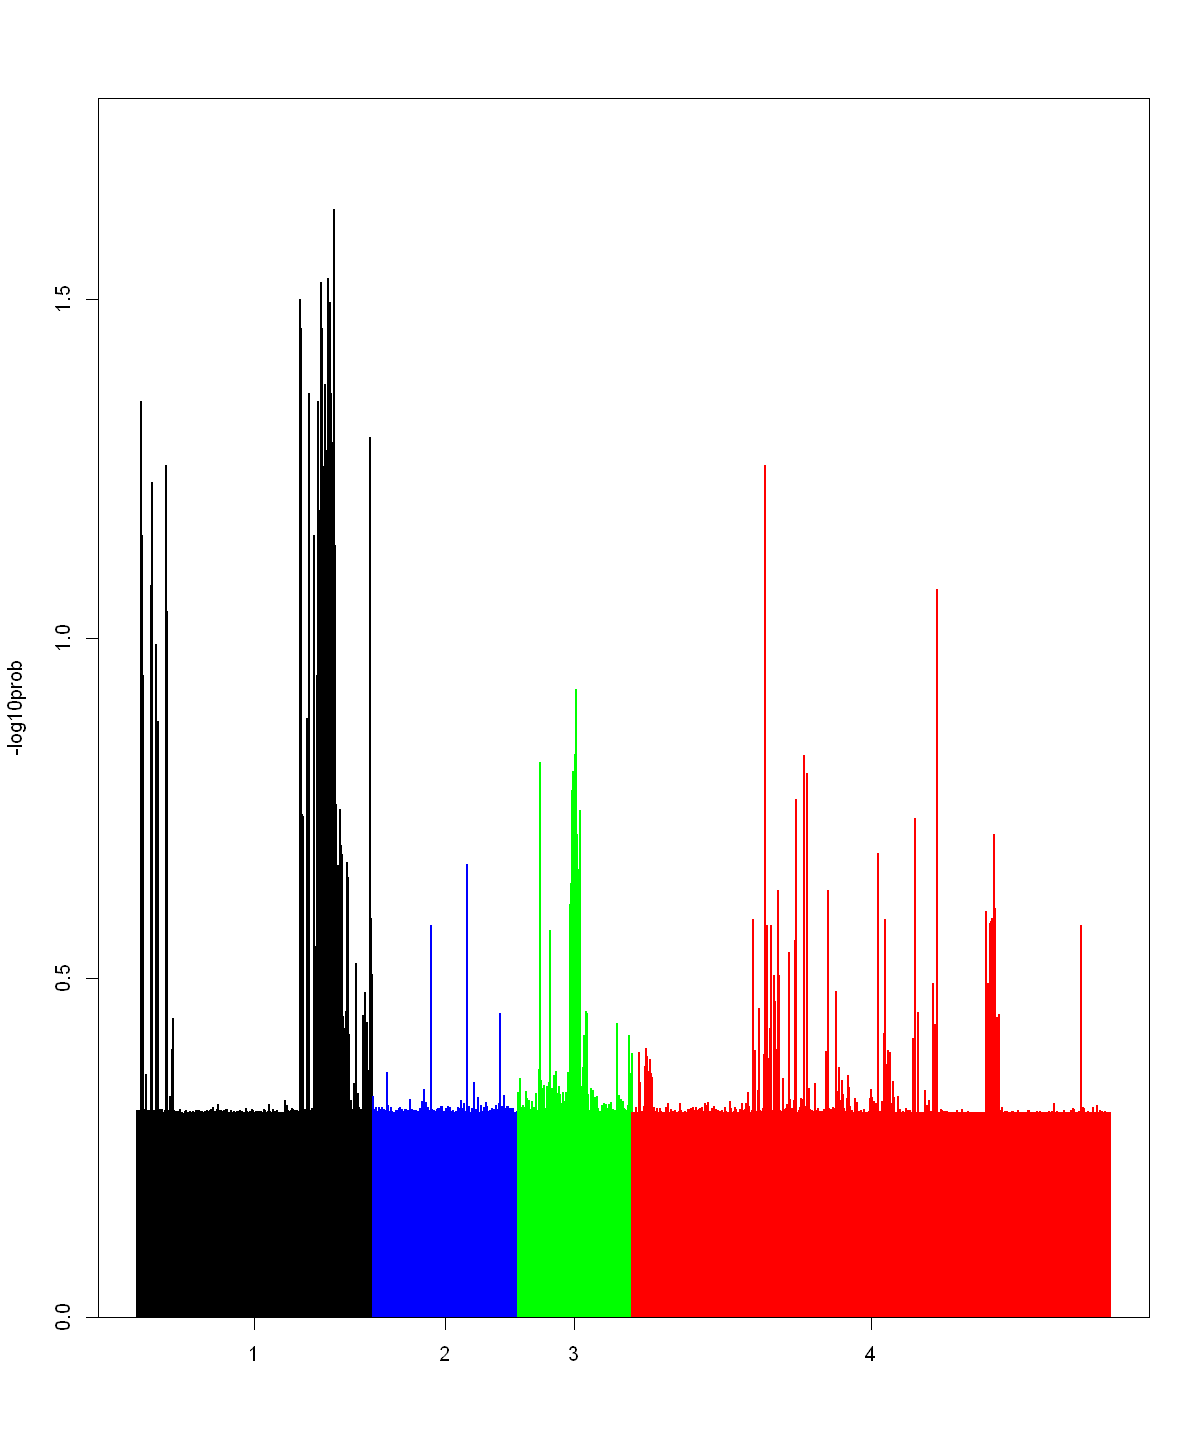

In [13]:
outlg<-round(length(sc@fdata[,1])/10)     # The cell will be considered as an outlier if it has a minimum of 10% of the number of filtered genes as outlier genes.
Outliers<- FindOutliers(sc, K=4, outminc=5,outlg=outlg,plot = TRUE, quiet = FALSE)

#### 2.1.4. Cellular pseudo-time ordering based on k-means clusters 

     order                             orderID
1        1      CTC_GSE51827_Patient_3_SC.1_29
2        2      CTC_GSE51827_Patient_2_SC.1_29
3        3 CTC_GSE86978_BrTr08_1_SC1_012913_77
4        4 CTC_GSE86978_BrTr08_1_SC2_012913_77
5        5 CTC_GSE75367_BRx_111.2..10.08.15_74
6        6     CTC_GSE75367_BRx_82_1_012015_74
7        7      CTC_GSE75367_BRx_82.2..9.29_74
8        8 CTC_GSE75367_BRx_180.1..07.02.15_74
9        9  CTC_GSE75367_BRx_146.1..4.16.15_74
10      10      CTC_GSE75367_BRx_82.1..9.15_74
11      11  CTC_GSE51827_Patient_4_SC.1..19_29
12      12    CTC_GSE86978_Brx52_SC1_020413_77
13      13 CTC_GSE75367_BRx_146.1..08.06.15_74
14      14  CTC_GSE86978_Brx73_1_SC2_032013_77
15      15     CTC_GSE75367_BRx_42_2_110314_74
16      16     CTC_GSE75367_BRx_16_2_102214_74
17      17  CTC_GSE86978_Brx97_1_SC2_072313_77
18      18     CTC_GSE75367_BRx_16_1_120314_74
19      19  CTC_GSE86978_Brx73_1_SC1_032013_77
20      20    CTC_GSE75367_BRx_172_1_111114_74
21      21   

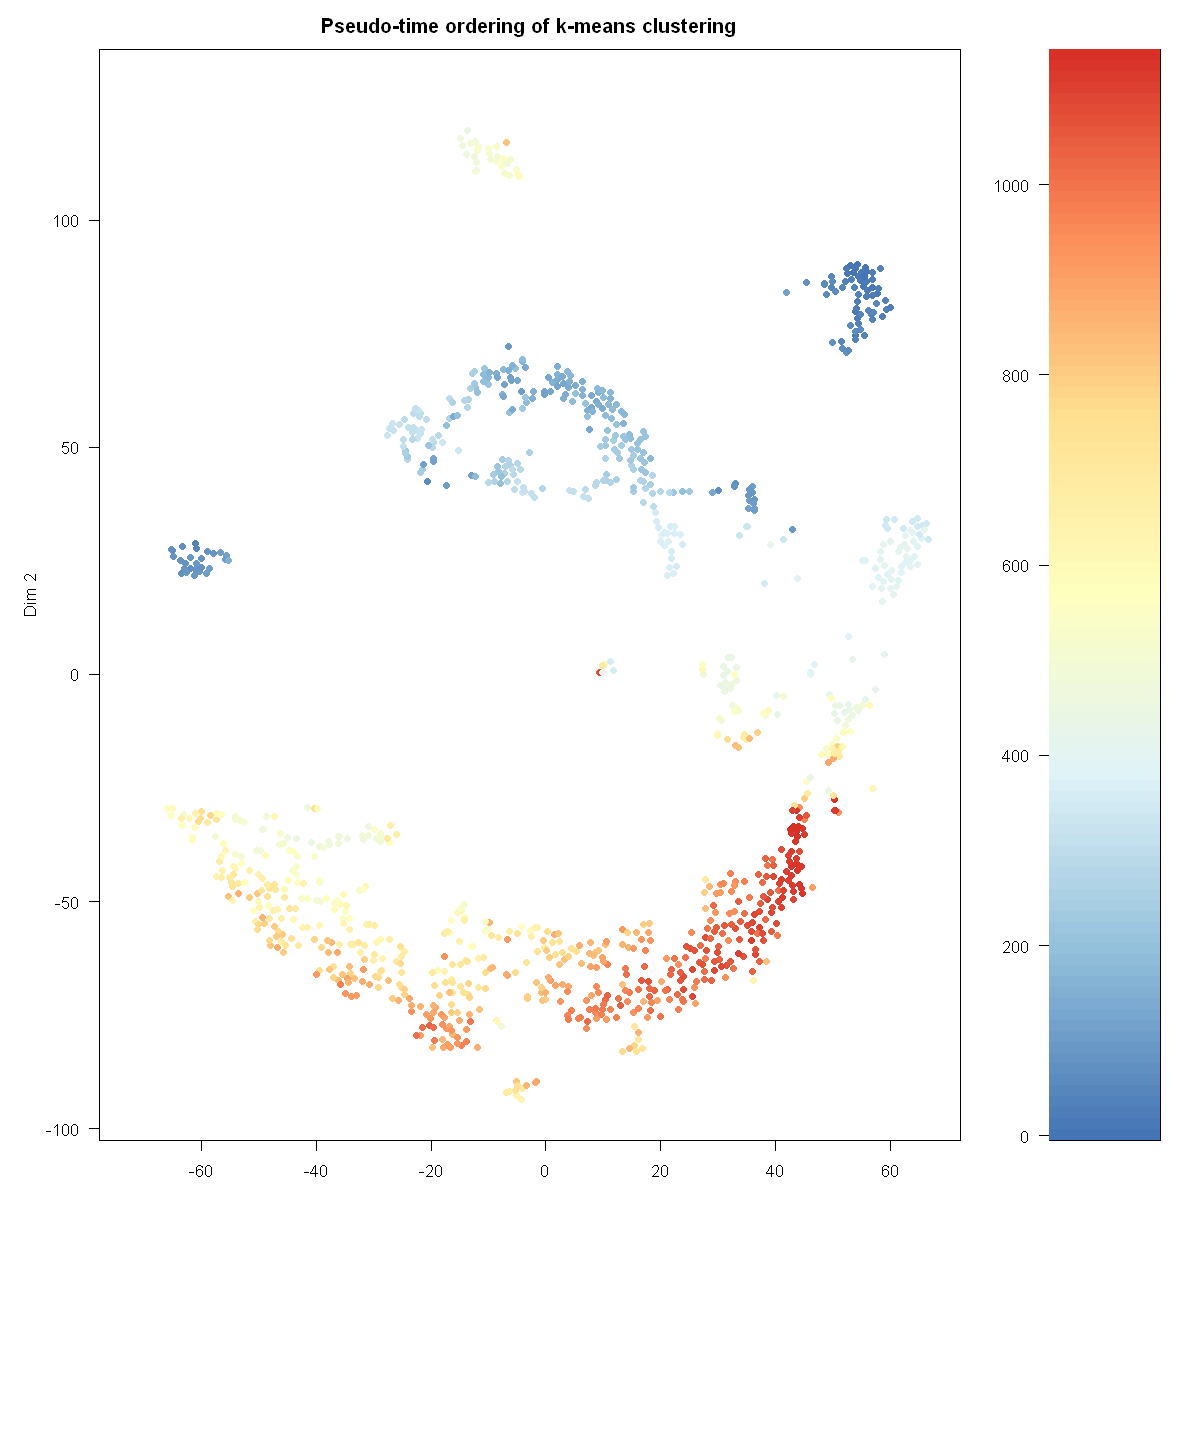

In [14]:
sc<-KmeanOrder(sc,quiet = FALSE, export = FALSE)
plotOrderTsne(sc)

#### 2.1.5 Plotting the K-means clusters in heatmap

The similarities between single-cells were computed by Euclidean distances of Pearson transcriptome correlation matrix. Based on these similarities, a heatmap portrayal of cell-to-cell distances was plotted using Euclidean as the distance measure and the single linkage as the clustering method, cluster centers were ordered by hierarchic clustering. 

[1] 1 2 3 4

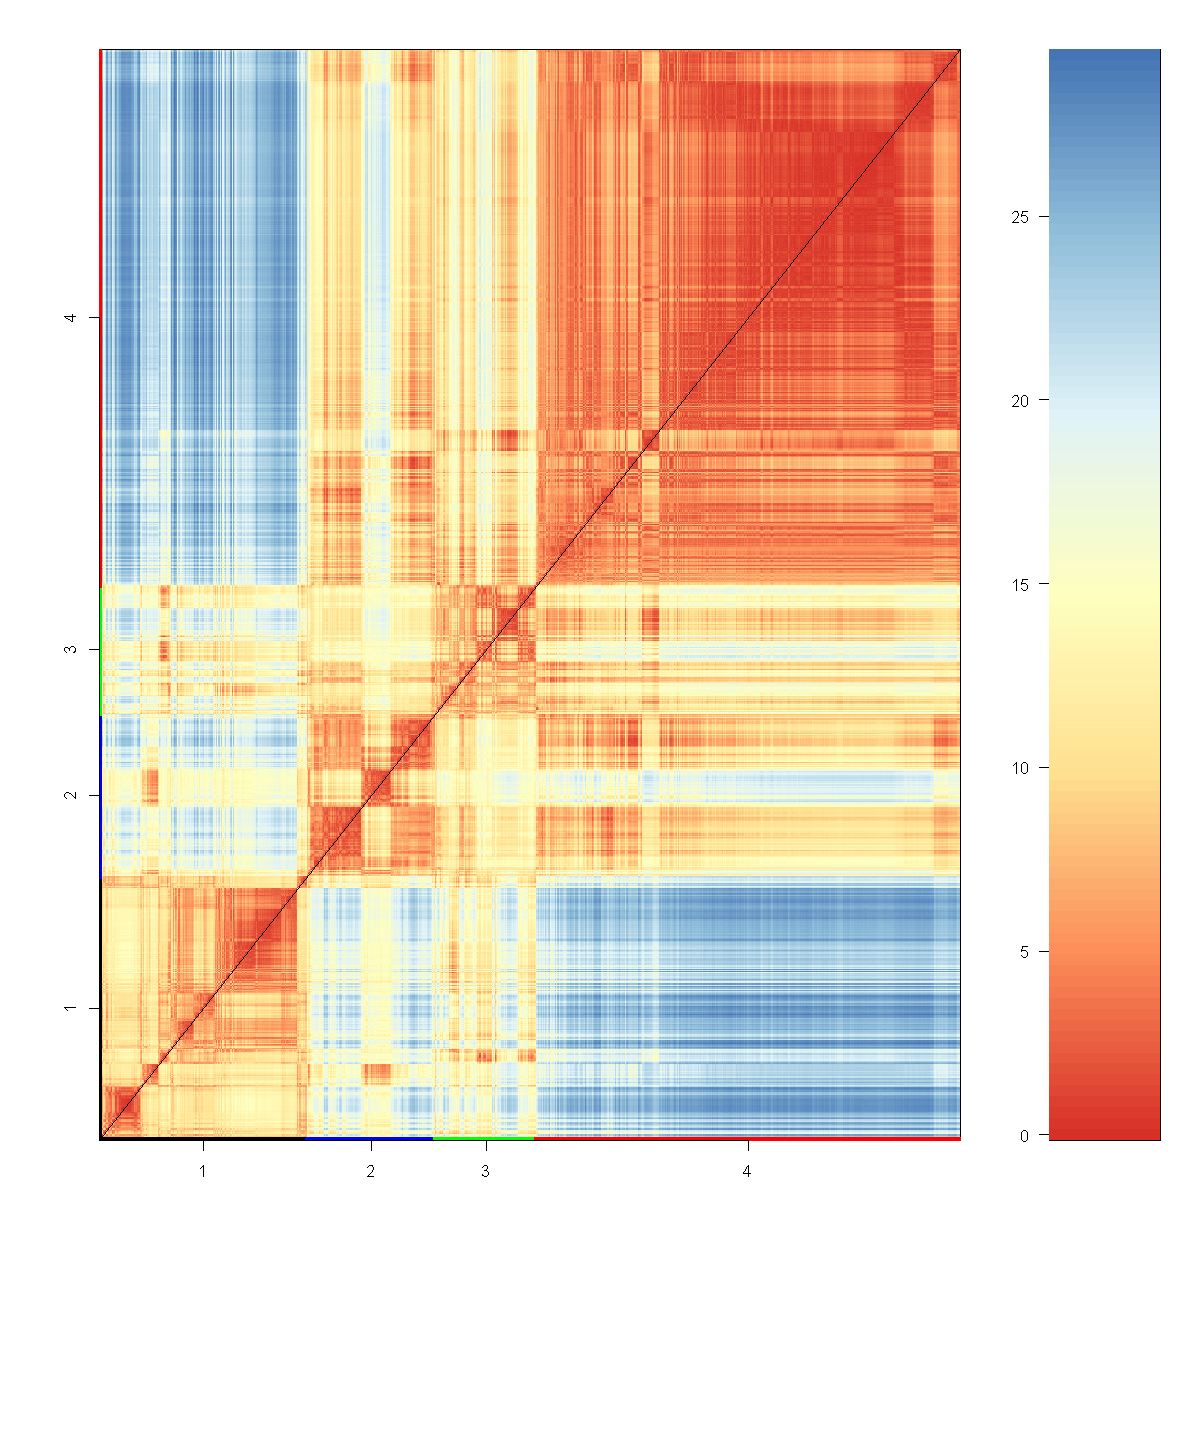

In [15]:
clustheatmap(sc)

#### 2.1.6 Plotting the gene expression of a particular gene in a tSNE map

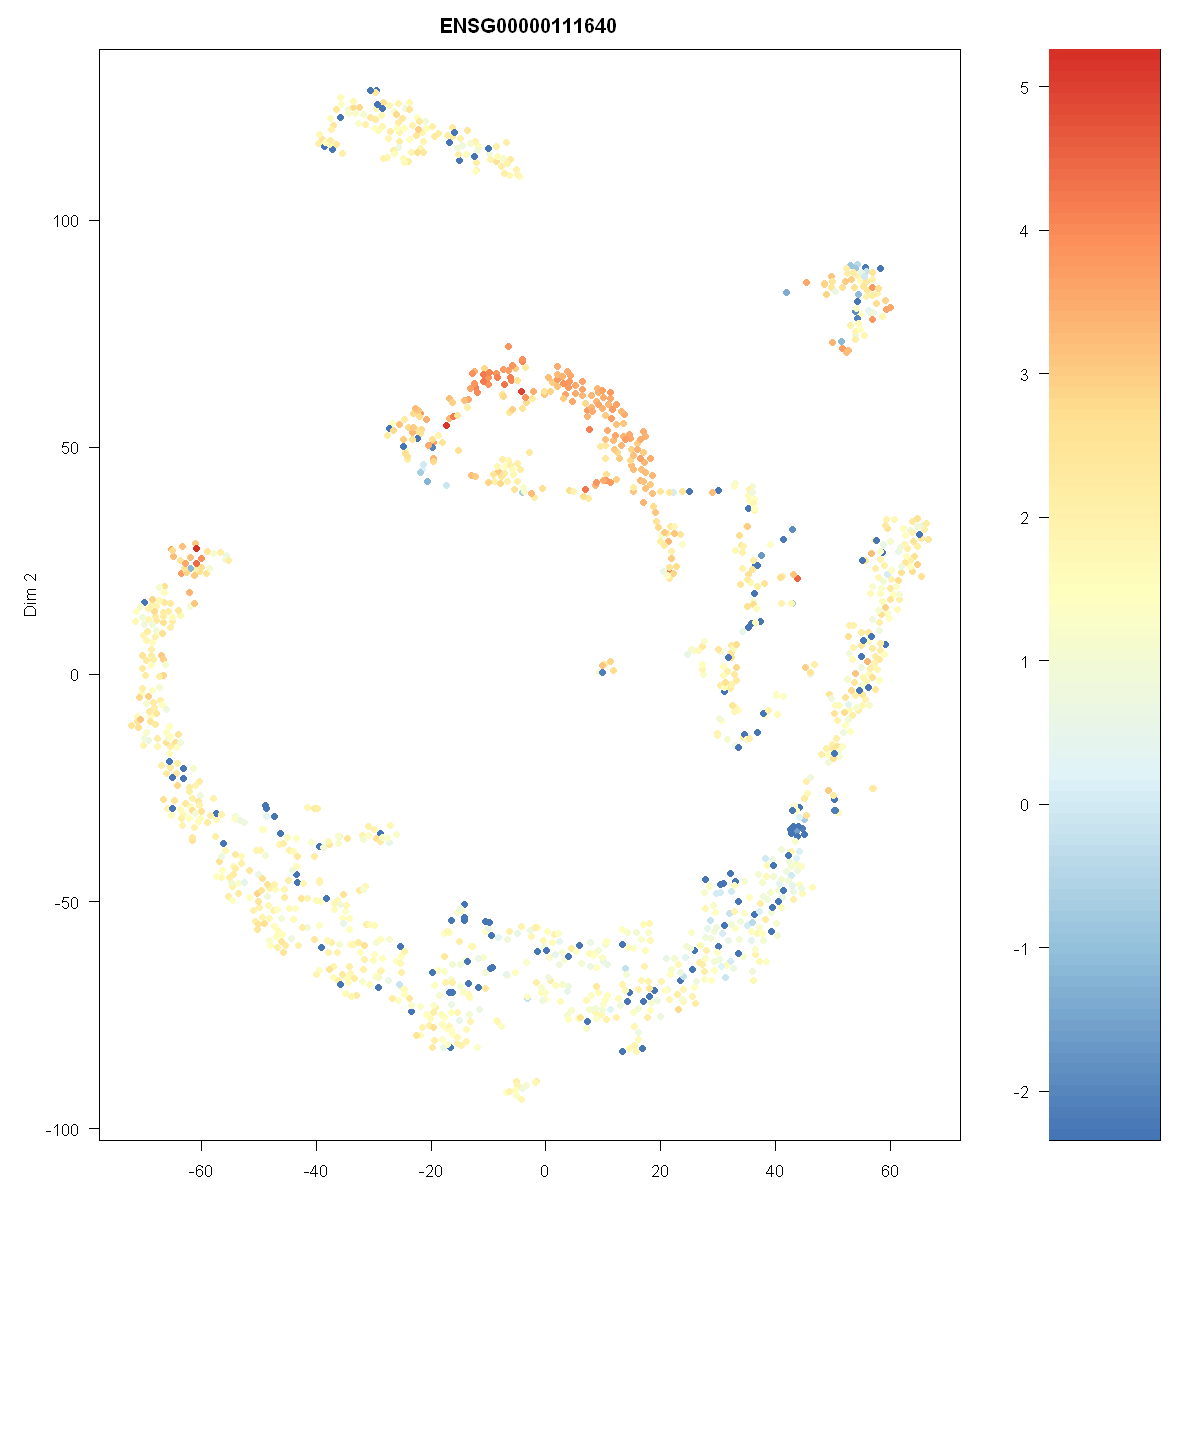

In [16]:
g='ENSG00000111640'                   #### Plotting the log expression of  GAPDH
plotExptSNE(sc,g)

## 3. Determining differentially expressed genes (DEGs) For K-means Clustering

Differentially expressed genes between individual clusters are identified using the significance analysis of sequencing data (SAMseq), which is a new function in significance analysis of microarrays (Li and Tibshirani 2011) in the samr package v2.0 (Tibshirani et all., 2015). SAMseq is a non-parametric statistical function dependent on Wilcoxon rank statistic that equalizes the sizes of the library by a resampling method accounting for the various sequencing depths. The analysis is implemented over the pure raw dataset that has the unnormalized expression read counts after excluding the ERCCs. Furthermore, DEGs in each cluster comparing to all the remaining clusters are determined using binomial differential expression, which is based on binomial counting statistics.

![DIsccBIO](KM2.png)

## 3.1 Identifying DEGs using SAMseq

The user can define DEGs between all clusters generated by either K-means or model based clustering by applying the “DEGanalysis” function. Another alternative is to define DEGs between particular clusters generated by K-means clustering by applying the “DEGanalysis2clust” function. The outcome of these two functions is a list of two components:
- The first component is a data frame showing the Ensembl gage name and the symbole of the detected DEGs
- The second component is table showing the comparisons, Target cluster, Number of genes and the File name. This component will be used for the downstream analysis.

### 3.1.1 Determining DEGs between two particular clusters

Estimating sequencing depths...

Resampling to get new data matrices...

perm = 1

perm = 2

perm = 3

perm = 4

perm = 5

perm = 6

perm = 7

perm = 8

perm = 9

perm = 10

perm = 11

perm = 12

perm = 13

perm = 14

perm = 15

perm = 16

perm = 17

perm = 18

perm = 19

perm = 20

perm = 21

perm = 22

perm = 23

perm = 24

perm = 25

perm = 26

perm = 27

perm = 28

perm = 29

perm = 30

perm = 31

perm = 32

perm = 33

perm = 34

perm = 35

perm = 36

perm = 37

perm = 38

perm = 39

perm = 40

perm = 41

perm = 42

perm = 43

perm = 44

perm = 45

perm = 46

perm = 47

perm = 48

perm = 49

perm = 50

perm = 51

perm = 52

perm = 53

perm = 54

perm = 55

perm = 56

perm = 57

perm = 58

perm = 59

perm = 60

perm = 61

perm = 62

perm = 63

perm = 64

perm = 65

perm = 66

perm = 67

perm = 68

perm = 69

perm = 70

perm = 71

perm = 72

perm = 73

perm = 74

perm = 75

perm = 76

perm = 77

perm = 78

perm = 79

perm = 80

perm = 81

perm = 82

perm = 83

perm = 84

perm = 85

p

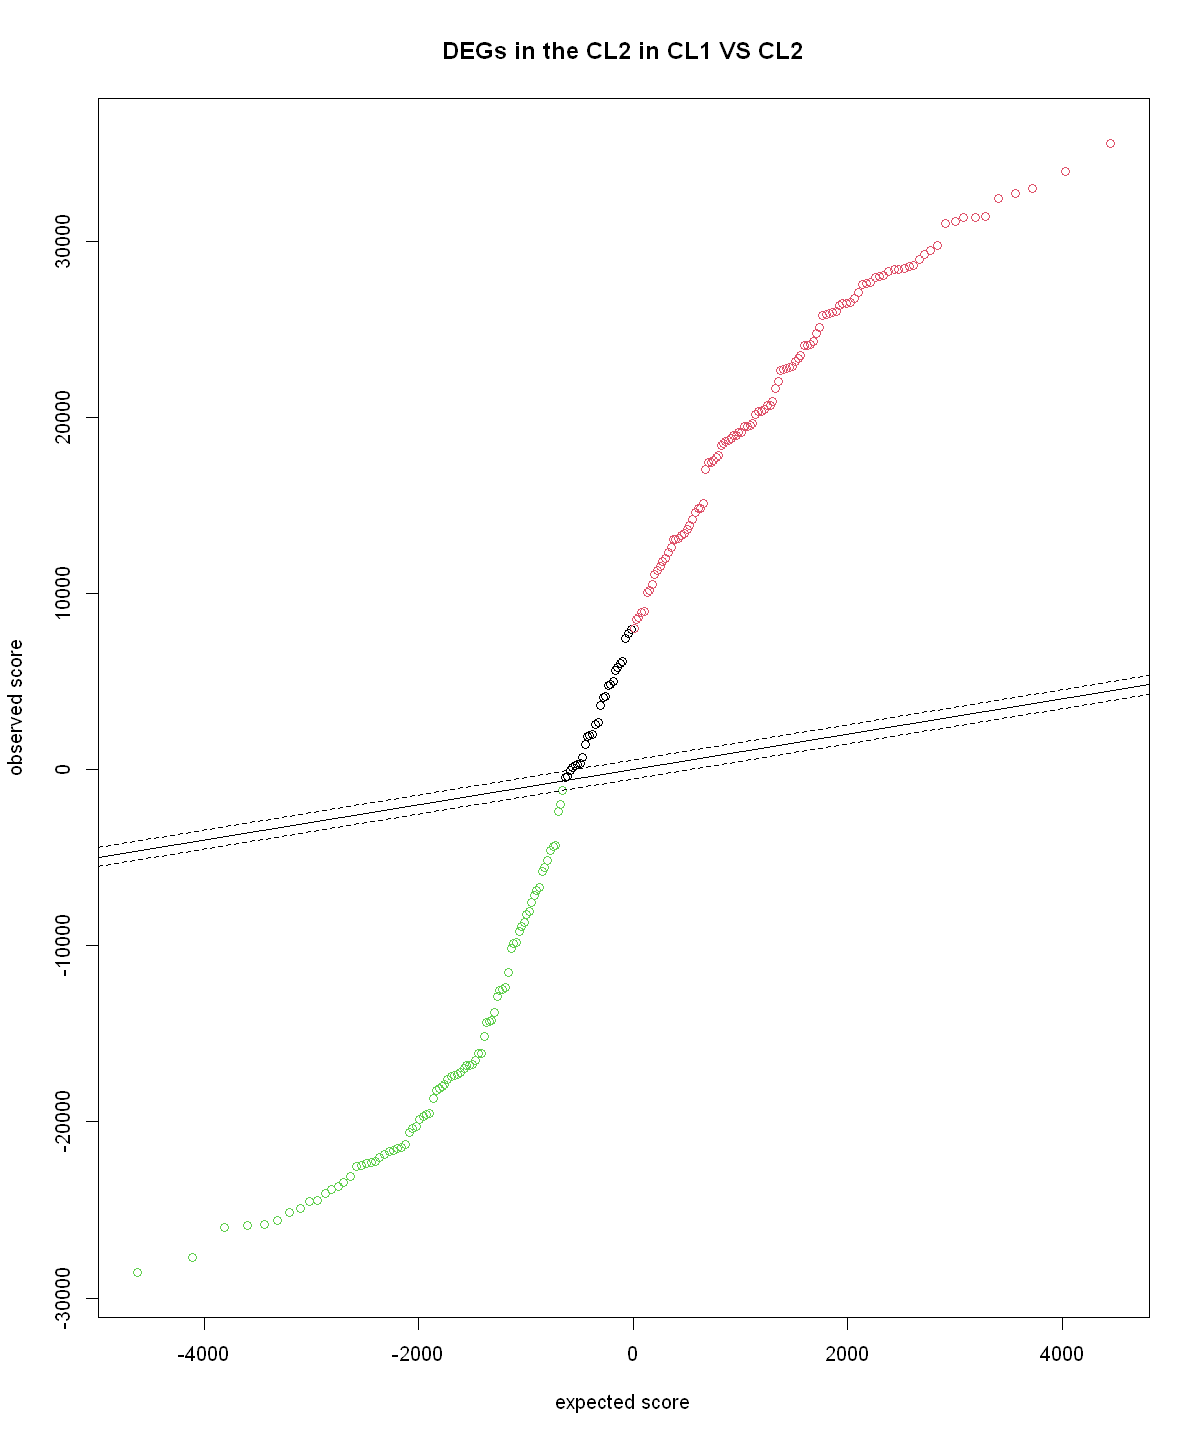

In [17]:
####### differential expression analysis between cluster 1 and cluster 2 using FDR of 0.05
cdiff<-DEGanalysis2clust(sc,Clustering="K-means",K=4,fdr=0.05,name="Name",First="CL1",Second="CL2",export = TRUE,quiet=T)     

In [18]:
#### To show the result table
head(cdiff[[1]])                  # The first component 
head(cdiff[[2]])                  # The second component 

DEGsE           DEGsS 
[1,] ENSG00000008988 RPS20 
[2,] ENSG00000010278 CD9   
[3,] ENSG00000034510 TMSB10
[4,] ENSG00000071082 RPL31 
[5,] ENSG00000071127 WDR1  
[6,] ENSG00000075624 ACTB

Comparisons Target cluster Gene number File name                          
1 CL1 VS CL2  CL2            106         Up-regulated-NameCL2inCL1VSCL2.csv 
2 CL1 VS CL2  CL1            106         Low-regulated-NameCL1inCL1VSCL2.csv
  Gene number File name                          
1 82          Low-regulated-NameCL2inCL1VSCL2.csv
2 82          Up-regulated-NameCL1inCL1VSCL2.csv

### 3.1.2 Determining DEGs between all clusters


##                                         ¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤ Running this cell will overwrite the previous one ¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤

Estimating sequencing depths...

Resampling to get new data matrices...

perm = 1

perm = 2

perm = 3

perm = 4

perm = 5

perm = 6

perm = 7

perm = 8

perm = 9

perm = 10

perm = 11

perm = 12

perm = 13

perm = 14

perm = 15

perm = 16

perm = 17

perm = 18

perm = 19

perm = 20

perm = 21

perm = 22

perm = 23

perm = 24

perm = 25

perm = 26

perm = 27

perm = 28

perm = 29

perm = 30

perm = 31

perm = 32

perm = 33

perm = 34

perm = 35

perm = 36

perm = 37

perm = 38

perm = 39

perm = 40

perm = 41

perm = 42

perm = 43

perm = 44

perm = 45

perm = 46

perm = 47

perm = 48

perm = 49

perm = 50

perm = 51

perm = 52

perm = 53

perm = 54

perm = 55

perm = 56

perm = 57

perm = 58

perm = 59

perm = 60

perm = 61

perm = 62

perm = 63

perm = 64

perm = 65

perm = 66

perm = 67

perm = 68

perm = 69

perm = 70

perm = 71

perm = 72

perm = 73

perm = 74

perm = 75

perm = 76

perm = 77

perm = 78

perm = 79

perm = 80

perm = 81

perm = 82

perm = 83

perm = 84

perm = 85

p

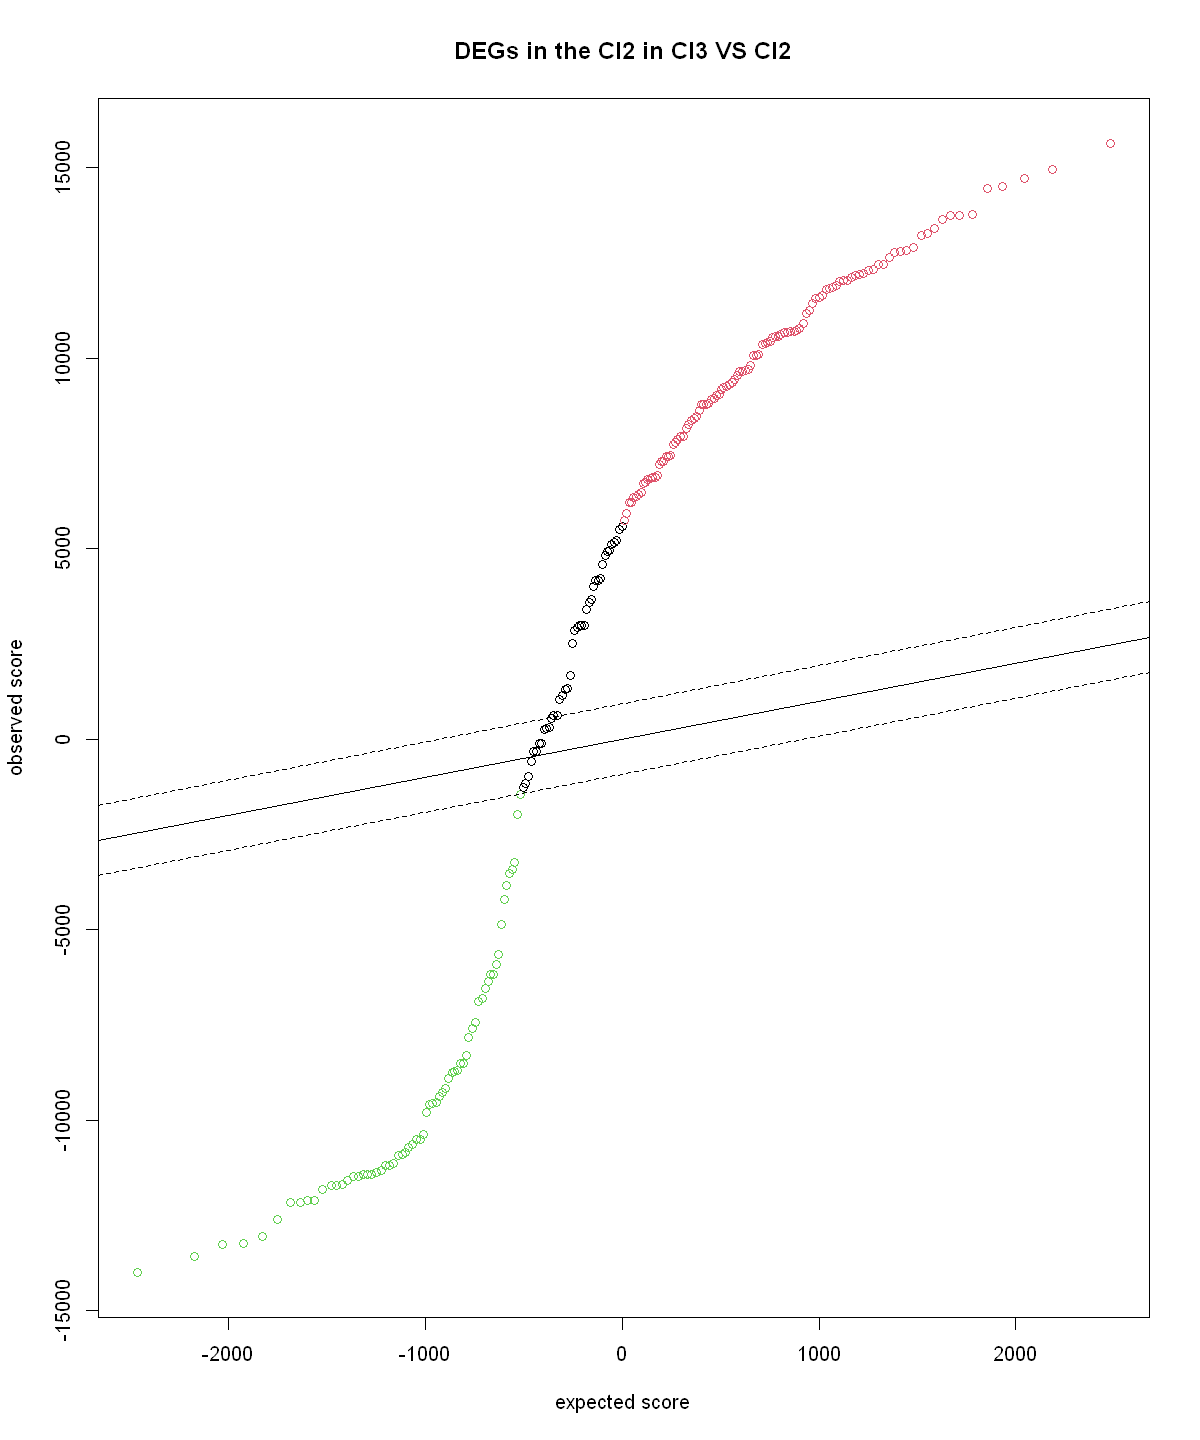

Estimating sequencing depths...

Resampling to get new data matrices...

perm = 1

perm = 2

perm = 3

perm = 4

perm = 5

perm = 6

perm = 7

perm = 8

perm = 9

perm = 10

perm = 11

perm = 12

perm = 13

perm = 14

perm = 15

perm = 16

perm = 17

perm = 18

perm = 19

perm = 20

perm = 21

perm = 22

perm = 23

perm = 24

perm = 25

perm = 26

perm = 27

perm = 28

perm = 29

perm = 30

perm = 31

perm = 32

perm = 33

perm = 34

perm = 35

perm = 36

perm = 37

perm = 38

perm = 39

perm = 40

perm = 41

perm = 42

perm = 43

perm = 44

perm = 45

perm = 46

perm = 47

perm = 48

perm = 49

perm = 50

perm = 51

perm = 52

perm = 53

perm = 54

perm = 55

perm = 56

perm = 57

perm = 58

perm = 59

perm = 60

perm = 61

perm = 62

perm = 63

perm = 64

perm = 65

perm = 66

perm = 67

perm = 68

perm = 69

perm = 70

perm = 71

perm = 72

perm = 73

perm = 74

perm = 75

perm = 76

perm = 77

perm = 78

perm = 79

perm = 80

perm = 81

perm = 82

perm = 83

perm = 84

perm = 85

p

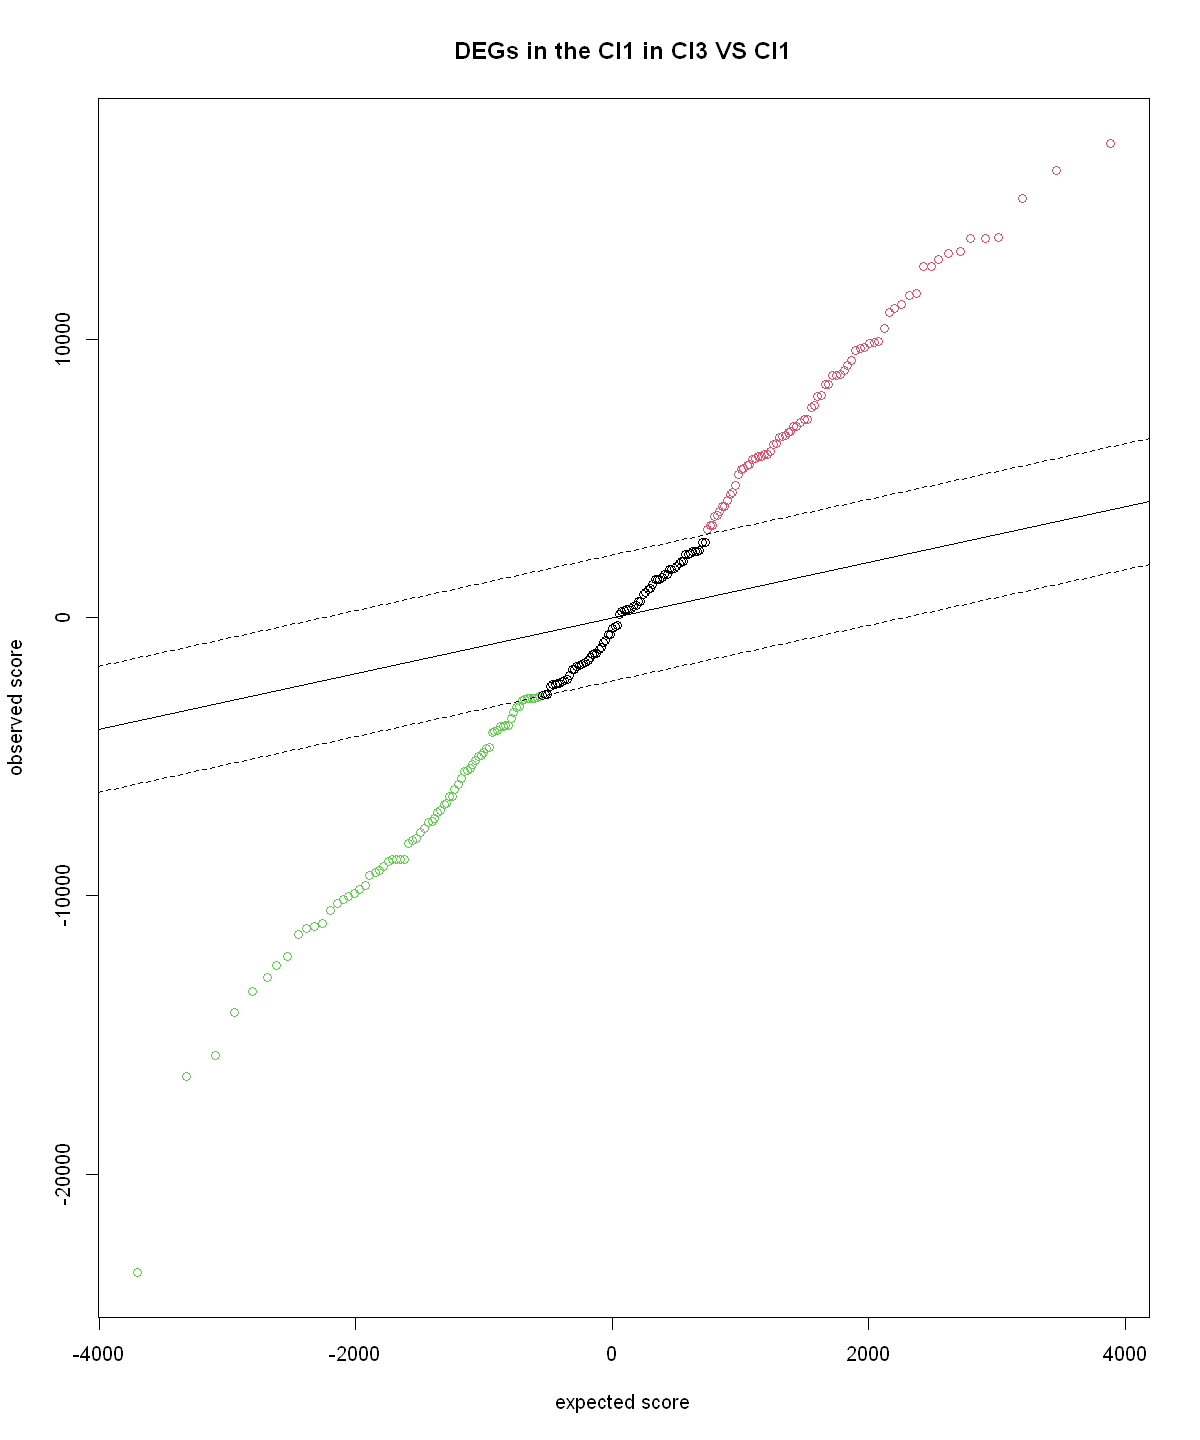

Estimating sequencing depths...

Resampling to get new data matrices...

perm = 1

perm = 2

perm = 3

perm = 4

perm = 5

perm = 6

perm = 7

perm = 8

perm = 9

perm = 10

perm = 11

perm = 12

perm = 13

perm = 14

perm = 15

perm = 16

perm = 17

perm = 18

perm = 19

perm = 20

perm = 21

perm = 22

perm = 23

perm = 24

perm = 25

perm = 26

perm = 27

perm = 28

perm = 29

perm = 30

perm = 31

perm = 32

perm = 33

perm = 34

perm = 35

perm = 36

perm = 37

perm = 38

perm = 39

perm = 40

perm = 41

perm = 42

perm = 43

perm = 44

perm = 45

perm = 46

perm = 47

perm = 48

perm = 49

perm = 50

perm = 51

perm = 52

perm = 53

perm = 54

perm = 55

perm = 56

perm = 57

perm = 58

perm = 59

perm = 60

perm = 61

perm = 62

perm = 63

perm = 64

perm = 65

perm = 66

perm = 67

perm = 68

perm = 69

perm = 70

perm = 71

perm = 72

perm = 73

perm = 74

perm = 75

perm = 76

perm = 77

perm = 78

perm = 79

perm = 80

perm = 81

perm = 82

perm = 83

perm = 84

perm = 85

p

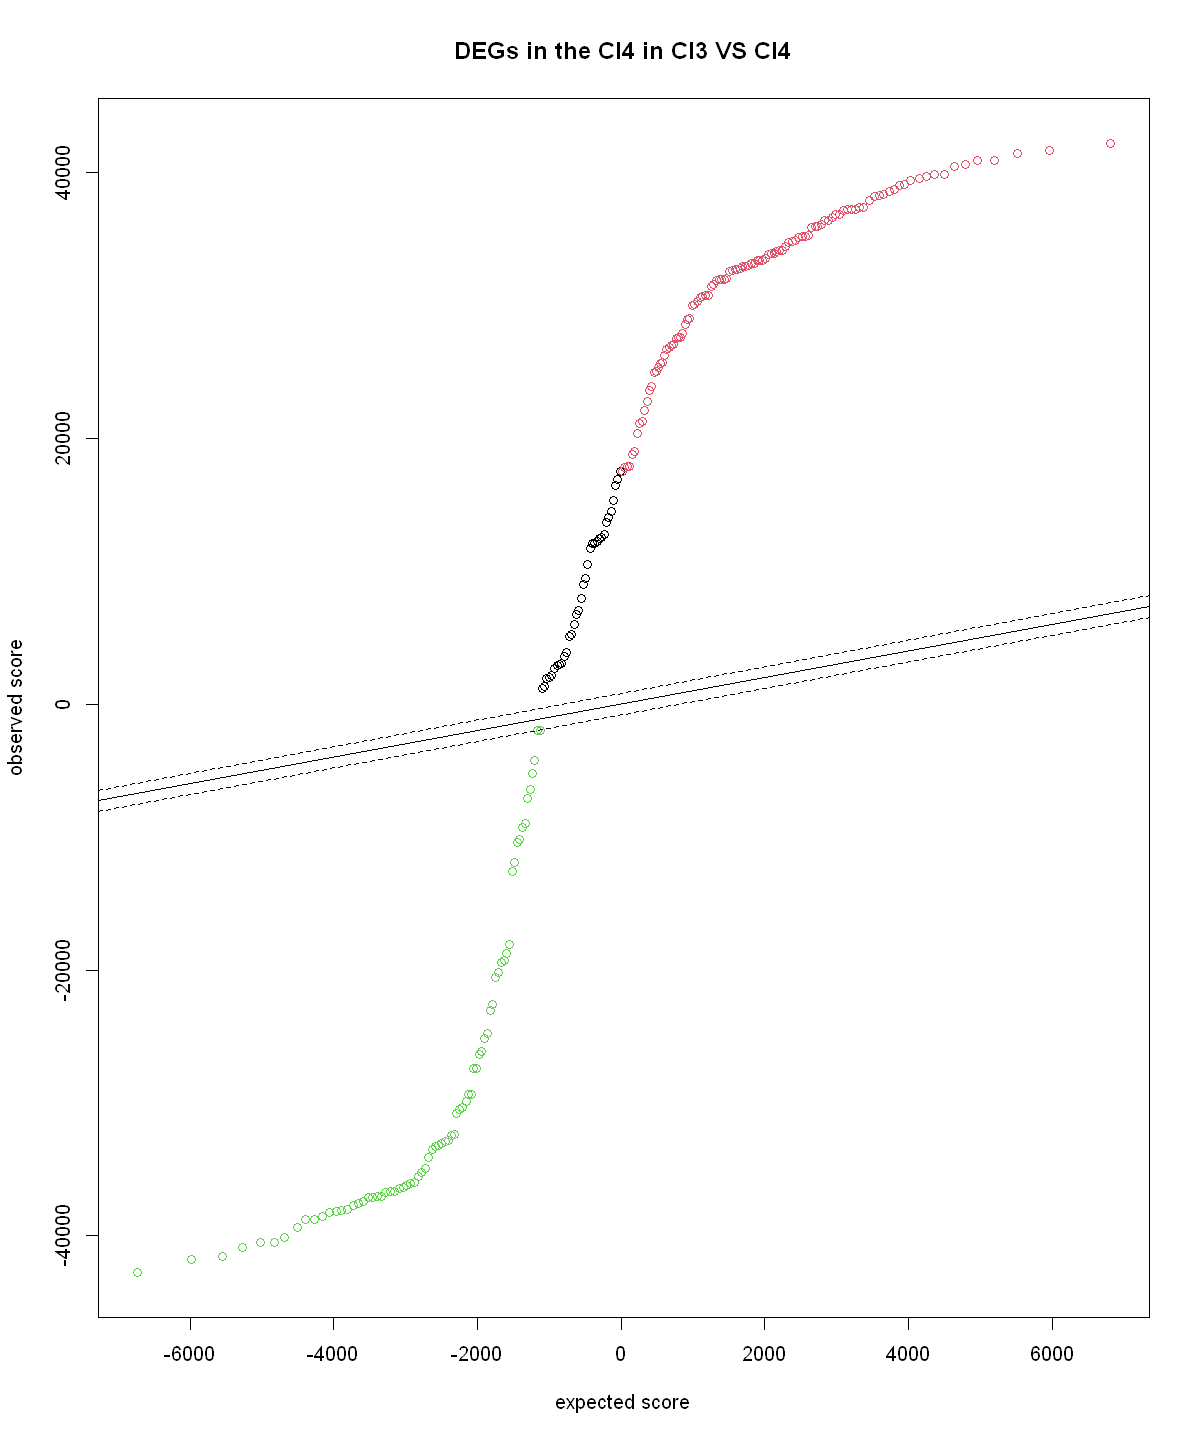

Estimating sequencing depths...

Resampling to get new data matrices...

perm = 1

perm = 2

perm = 3

perm = 4

perm = 5

perm = 6

perm = 7

perm = 8

perm = 9

perm = 10

perm = 11

perm = 12

perm = 13

perm = 14

perm = 15

perm = 16

perm = 17

perm = 18

perm = 19

perm = 20

perm = 21

perm = 22

perm = 23

perm = 24

perm = 25

perm = 26

perm = 27

perm = 28

perm = 29

perm = 30

perm = 31

perm = 32

perm = 33

perm = 34

perm = 35

perm = 36

perm = 37

perm = 38

perm = 39

perm = 40

perm = 41

perm = 42

perm = 43

perm = 44

perm = 45

perm = 46

perm = 47

perm = 48

perm = 49

perm = 50

perm = 51

perm = 52

perm = 53

perm = 54

perm = 55

perm = 56

perm = 57

perm = 58

perm = 59

perm = 60

perm = 61

perm = 62

perm = 63

perm = 64

perm = 65

perm = 66

perm = 67

perm = 68

perm = 69

perm = 70

perm = 71

perm = 72

perm = 73

perm = 74

perm = 75

perm = 76

perm = 77

perm = 78

perm = 79

perm = 80

perm = 81

perm = 82

perm = 83

perm = 84

perm = 85

p

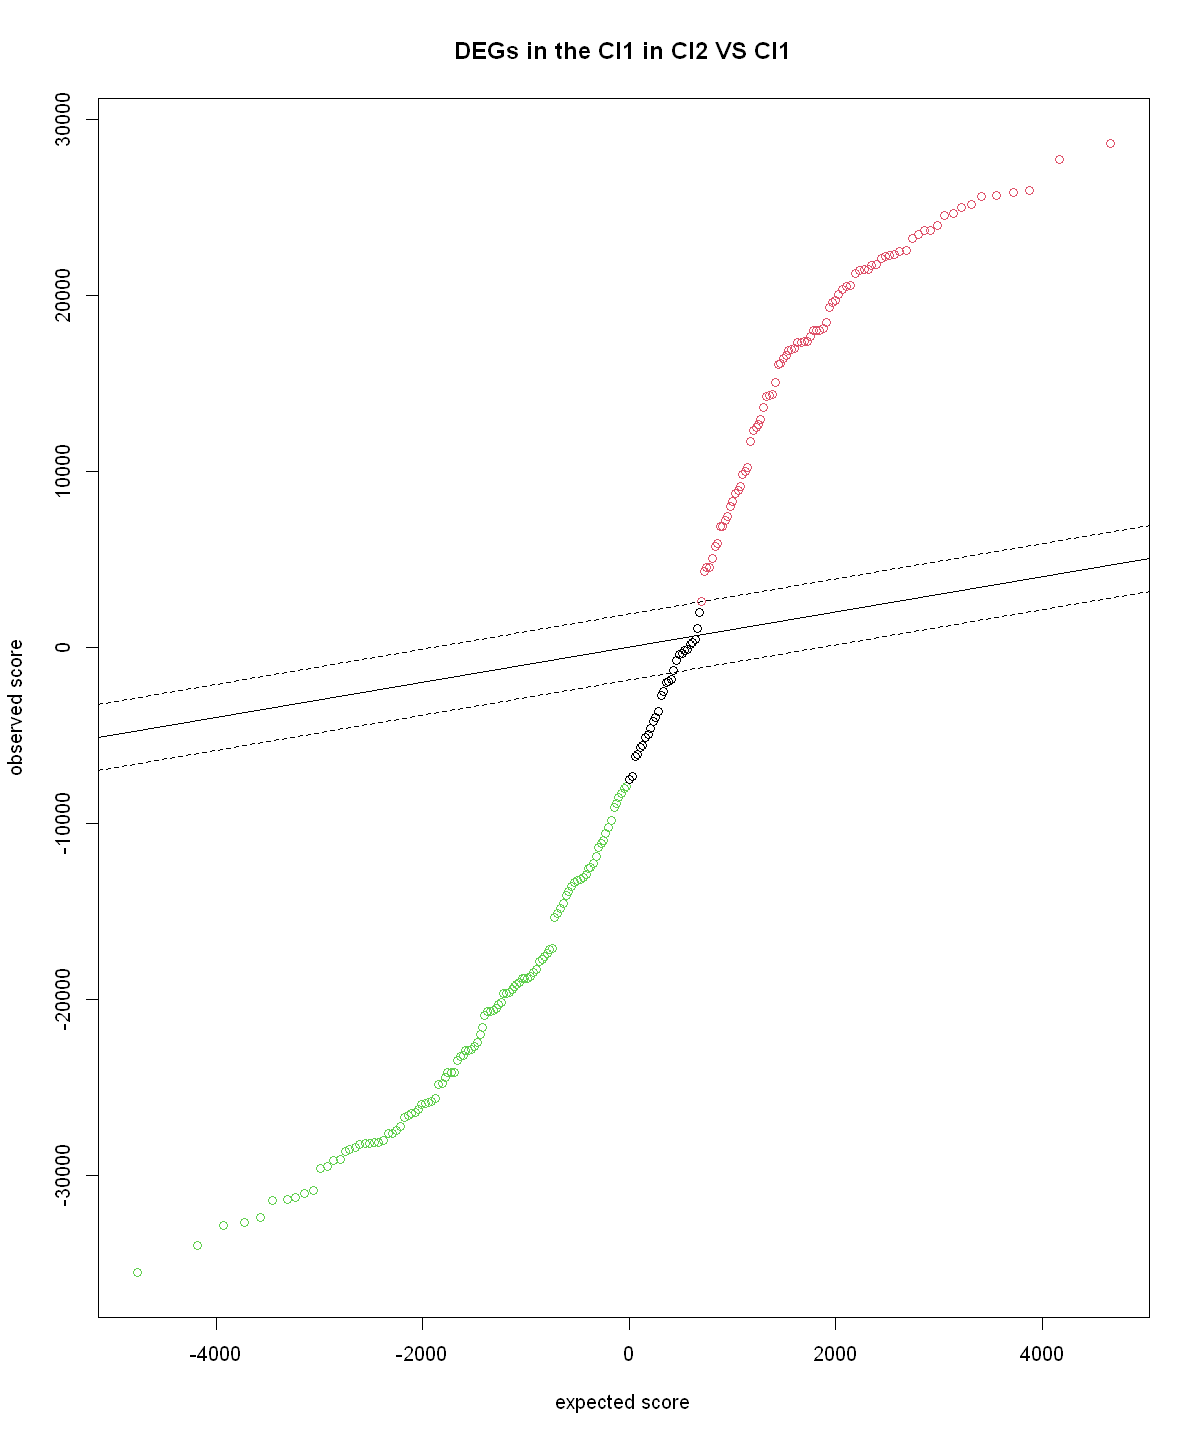

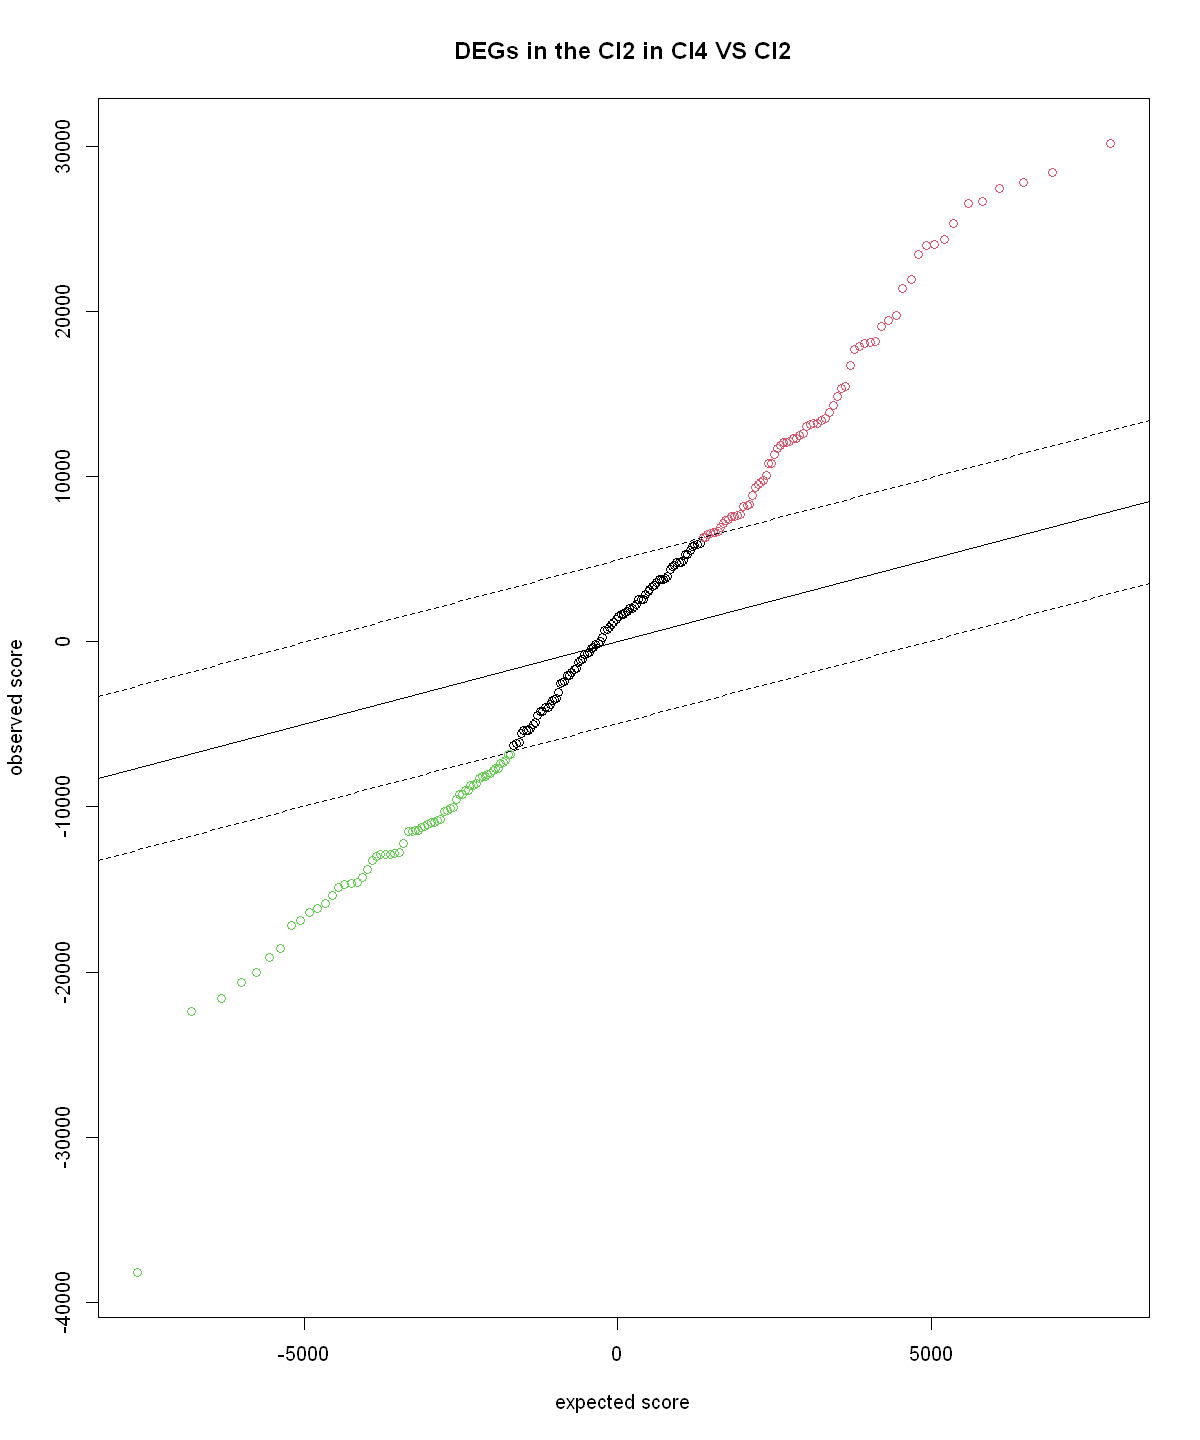

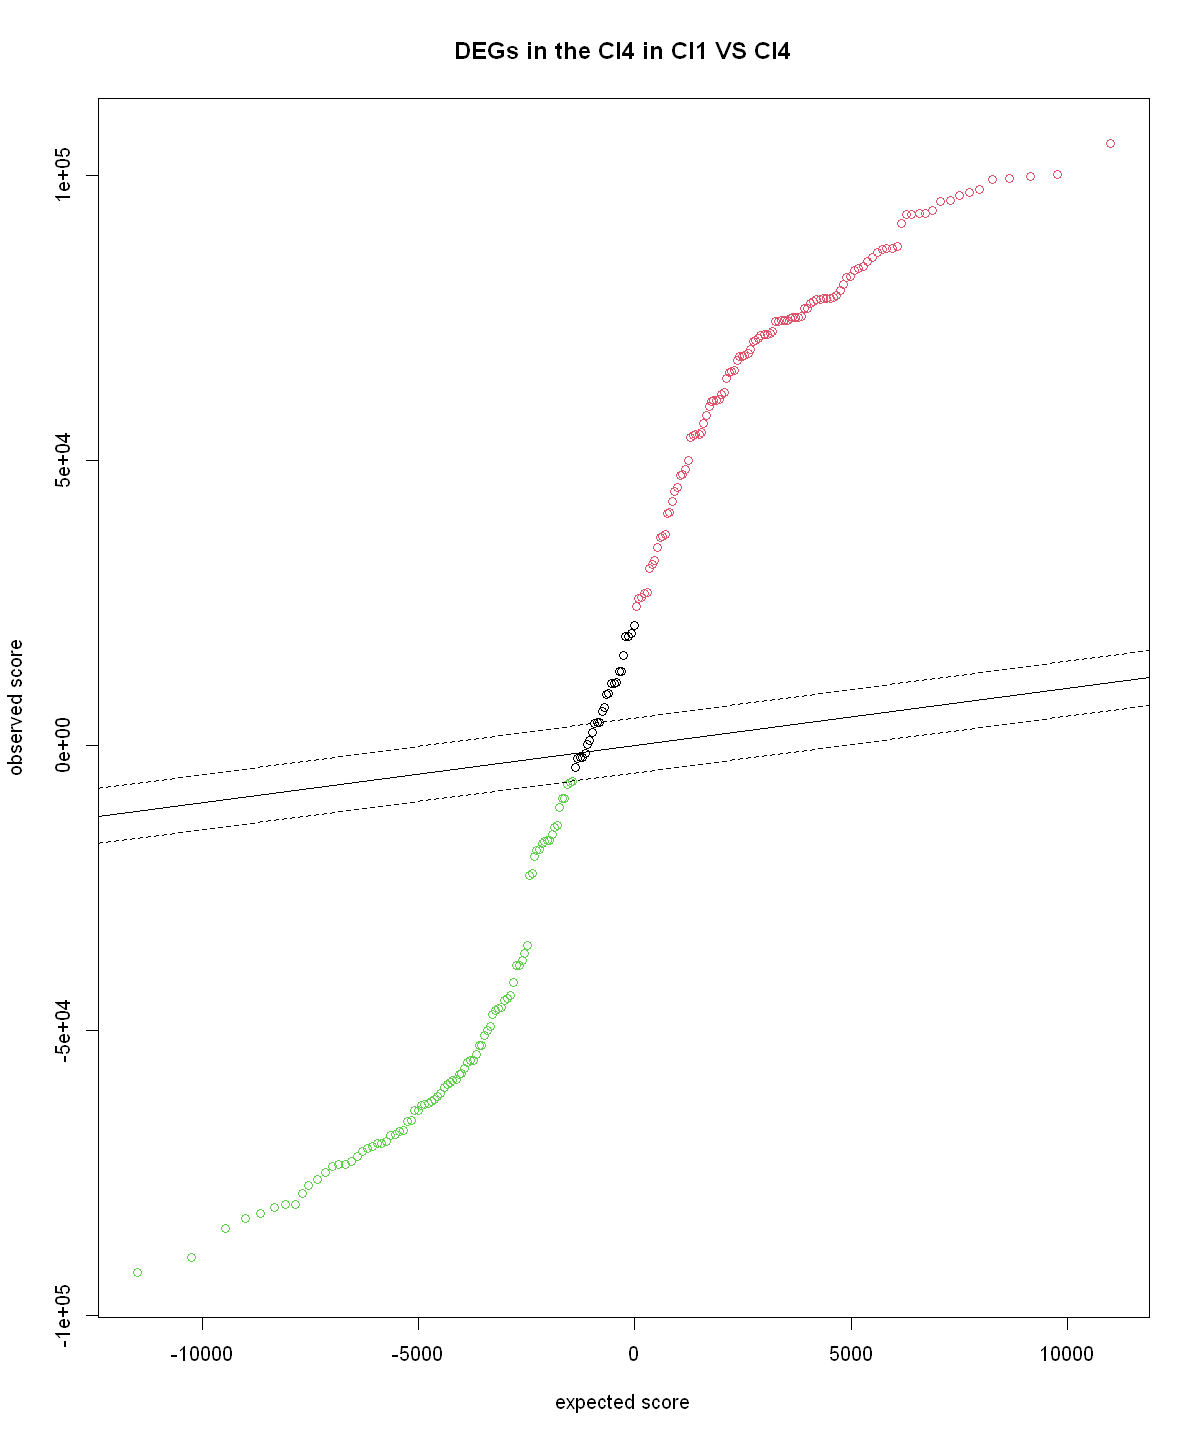

In [19]:
cdiff<-DEGanalysis(sc,Clustering="K-means",K=4,fdr=0.01,name="all_clusters",export = TRUE,quiet=T)   ####### differential expression analysis between all clusters

In [20]:
#### To show the result table
head(cdiff[[1]])                  # The first component 
head(cdiff[[2]])                  # The second component

DEGsE           DEGsS   
[1,] ENSG00000008988 RPS20   
[2,] ENSG00000010278 CD9     
[3,] ENSG00000034510 TMSB10  
[4,] ENSG00000067082 KLF6    
[5,] ENSG00000071082 RPL31   
[6,] ENSG00000080824 HSP90AA1

Comparisons Target cluster Gene number
1 Cl3 VS Cl2  Cl2            108        
2 Cl3 VS Cl1  Cl1             71        
3 Cl3 VS Cl4  Cl4            107        
4 Cl2 VS Cl1  Cl1             80        
5 Cl4 VS Cl2  Cl2             69        
6 Cl1 VS Cl4  Cl4            104        
  File name                                  Gene number
1 Up-regulated-all_clustersCl2inCl3VSCl2.csv  66        
2 Up-regulated-all_clustersCl1inCl3VSCl1.csv  74        
3 Up-regulated-all_clustersCl4inCl3VSCl4.csv  74        
4 Up-regulated-all_clustersCl1inCl2VSCl1.csv 107        
5 Up-regulated-all_clustersCl2inCl4VSCl2.csv  63        
6 Up-regulated-all_clustersCl4inCl1VSCl4.csv  86        
  File name                                  
1 Low-regulated-all_clustersCl2inCl3VSCl2.csv
2 Low-regulated-all_clustersCl1inCl3VSCl1.csv
3 Low-regulated-all_clustersCl4inCl3VSCl4.csv
4 Low-regulated-all_clustersCl1inCl2VSCl1.csv
5 Low-regulated-all_clustersCl2inCl4VSCl2.csv
6 Low-regulated-all_clustersCl4inCl1VSCl4.csv

#### 3.2 Identifying DEGs using binomial differential expression

The function ClustDiffGenes identifies differentially regulated genes for each cluster of the K-means clustering in 
comparison to the ensemble of all cells. It returns a list with a data.frame element for each cluster that contains the mean expression across all cells not in the cluster (mean.ncl) and in the cluster (mean.cl), the fold-change in the cluster versus all remaining cells (fc), and the p-value for differential expression between all cells in a cluster and all remaining cells. The p-value is computed based on the overlap of negative binomials fitted to the count distributions within the two groups akin to DESeq.

In [21]:
cdiffBinomial<-ClustDiffGenes(sc,K=4,export = T,fdr=.01,quiet=T)    ########## Binomial differential expression analysis
#### To show the result table
head(cdiffBinomial[[1]])                  # The first component 
head(cdiffBinomial[[2]])                  # The second component

DEGsE           DEGsS  
[1,] ENSG00000001630 CYP51A1
[2,] ENSG00000002586 CD99   
[3,] ENSG00000003402 CFLAR  
[4,] ENSG00000003436 TFPI   
[5,] ENSG00000003756 RBM5   
[6,] ENSG00000004059 ARF5

Target Cluster VS                 Gene number File name           Gene number
1 Cluster 1      Remaining Clusters 1052        Up-DEG-cluster1.csv 678        
2 Cluster 2      Remaining Clusters    0        Up-DEG-cluster2.csv   1        
3 Cluster 3      Remaining Clusters    2        Up-DEG-cluster3.csv   5        
4 Cluster 4      Remaining Clusters    1        Up-DEG-cluster4.csv   1        
  File name            
1 Down-DEG-cluster1.csv
2 Down-DEG-cluster2.csv
3 Down-DEG-cluster3.csv
4 Down-DEG-cluster4.csv

### Plotting the DEGs

Volcano plots are used to readily show the DEGs by plotting significance versus fold-change on the y and x axes, respectively.

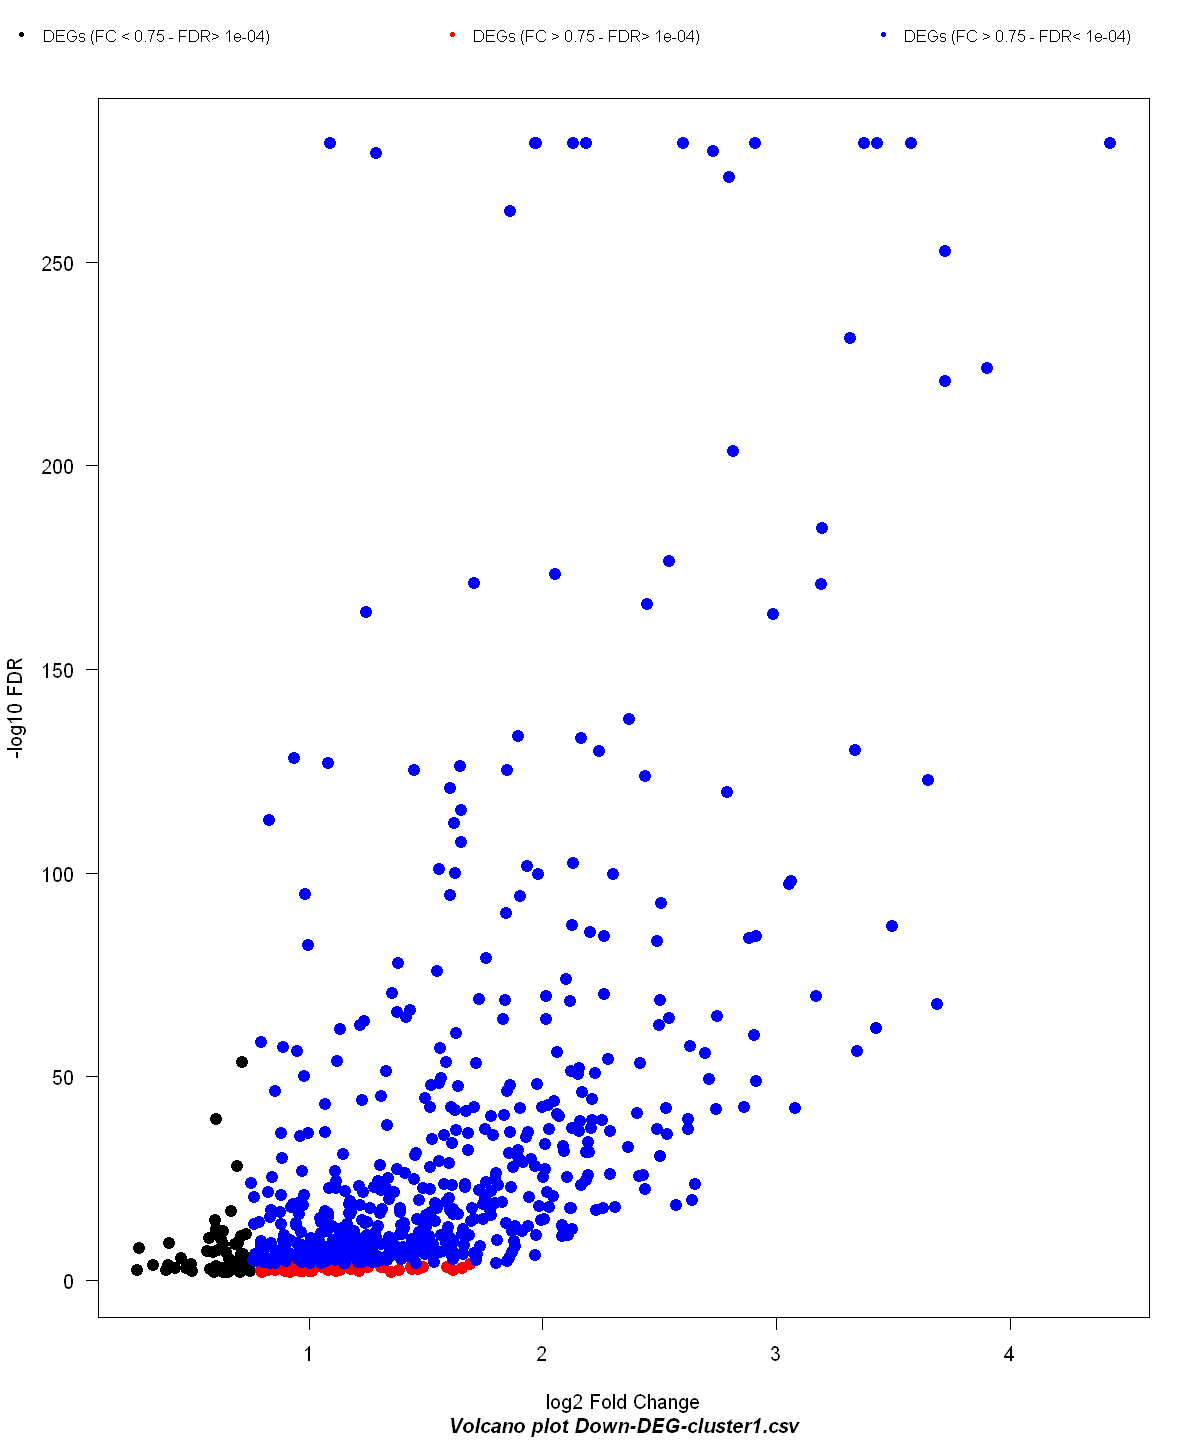

In [22]:
name<-cdiffBinomial[[2]][1,6]    ############ Selecting the DEGs' ############## Down-DEG-cluster1.csv
U<-read.csv(file=paste0(name),head=TRUE,sep=",")
Vplot<-VolcanoPlot(U,value=0.0001,name=name,FS=1,fc=0.75)

## 4. Identifying biomarkers (decision trees and networking analysis) 

There are several methods to identify biomarkers, among them are decision trees and hub detection through networking analysis. The outcome of STRING analysis is stored in tab separated values (TSV) files. These TSV files served as an input to check both the connectivity degree and the betweenness centrality, which reflects the communication flow in the defined PPI networks 

![DIsccBIO](KM3.png)

Decision trees are one of the most efficient classification techniques in biomarkers discovery. Here we use it to predict the sub-population of a target cell based on transcriptomic data. Two types of decision trees can be performed: classification and regression trees (CART) and J48. The decision tree analysis is implemented over a training dataset, which consisted of the DEGs obtained by either SAMseq or the binomial differential expression. The performance of the generated trees can be evaluated for error estimation by ten-fold cross validation assessment using the "J48DTeval" and "RpartEVAL" functions. The decision tree analysis requires the dataset to be class vectored by applying the “ClassVectoringDT” function.

In [23]:
#sigDEG<-cdiff[[1]]             # DEGs gene list from SAMseq
sigDEG<-cdiffBinomial[[1]]      # DEGs gene list from Binomial analysis
First="CL1"
Second="CL4"
DATAforDT<-ClassVectoringDT(sc,Clustering="K-means",K=4,First=First,Second=Second,sigDEG)

The DEGs filtered normalized dataset contains:
Genes: 1731
cells: 1062



### 4.1. J48 Decision Tree

J48 pruned tree
------------------

MALAT1 <= 102.794044: CL1 (344.0/1.0)
MALAT1 > 102.794044
|   CA1 <= 0.103233: CL4 (693.0)
|   CA1 > 0.103233
|   |   SLC25A39 <= 6.310579: CL4 (17.0)
|   |   SLC25A39 > 6.310579: CL1 (8.0/1.0)

Number of Leaves  : 	4

Size of the tree : 	7




=== Summary ===

Correctly Classified Instances        1060               99.8117 %
Incorrectly Classified Instances         2                0.1883 %
Kappa statistic                          0.9957
Mean absolute error                      0.0035
Root mean squared error                  0.042 
Relative absolute error                  0.7976 %
Root relative squared error              8.9321 %
Total Number of Instances             1062     

=== Confusion Matrix ===

   a   b   <-- classified as
 350   0 |   a = CL1
   2 710 |   b = CL4

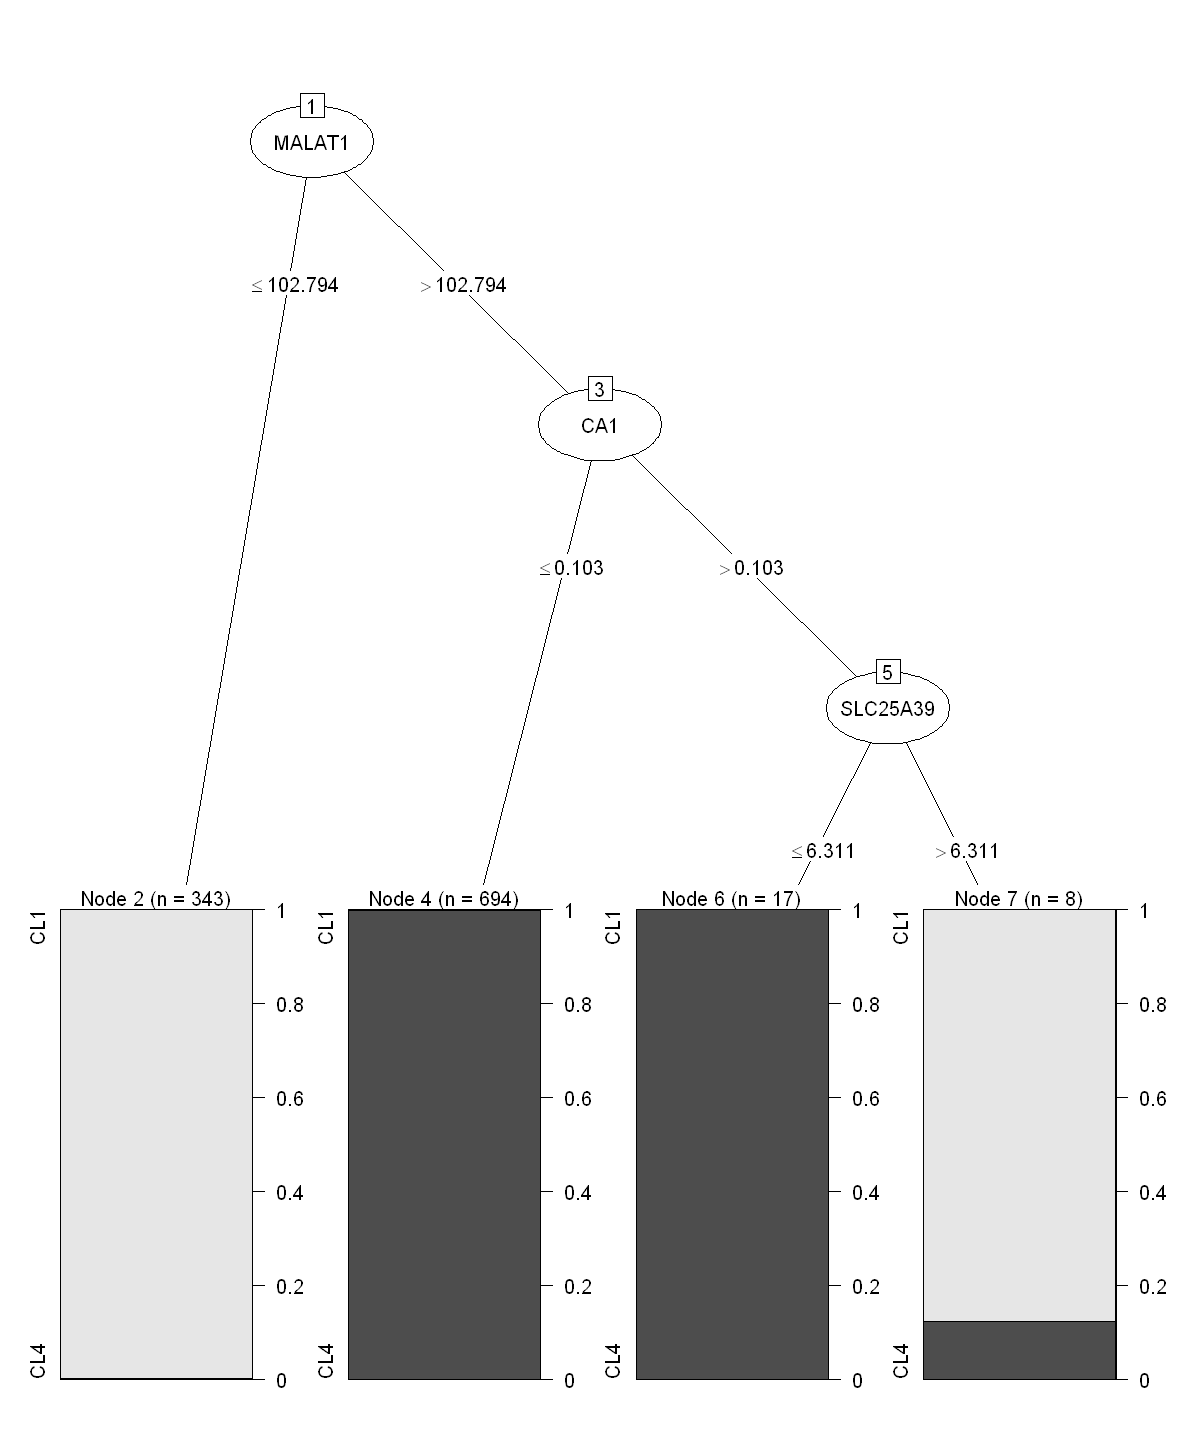

In [24]:
j48dt<-J48DT(DATAforDT)           #J48 Decision Tree
summary(j48dt) 

#### 4.1.1. Evaluating the performance of the J48 Decision Tree

In [25]:
j48dt<-J48DTeval(DATAforDT,num.folds=10,First=First,Second=Second)

Fold 1 of 10

Fold 2 of 10

Fold 3 of 10

Fold 4 of 10

Fold 5 of 10

Fold 6 of 10

Fold 7 of 10

Fold 8 of 10

Fold 9 of 10

Fold 10 of 10



 TP  FN  FP  TN 
347   3   2 710 
             CL1 CL4
PredictedCL1 347   2
PredictedCL4   3 710


J48 SN: 0.99
J48 SP: 1
J48 ACC: 1
J48 MCC: 0.99




### 4.2. RPART Decision Tree

n= 1062 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 1062 350 CL4 (0.329566855 0.670433145)  
   2) MALAT1< 104.7847 344   1 CL1 (0.997093023 0.002906977)  
     4) SYNE2< 12.34286 343   0 CL1 (1.000000000 0.000000000) *
     5) SYNE2>=12.34286 1   0 CL4 (0.000000000 1.000000000) *
   3) MALAT1>=104.7847 718   7 CL4 (0.009749304 0.990250696)  
     6) SLC25A39>=7.9044 8   1 CL1 (0.875000000 0.125000000)  
      12) CFLAR< 4.819648 7   0 CL1 (1.000000000 0.000000000) *
      13) CFLAR>=4.819648 1   0 CL4 (0.000000000 1.000000000) *
     7) SLC25A39< 7.9044 710   0 CL4 (0.000000000 1.000000000) *


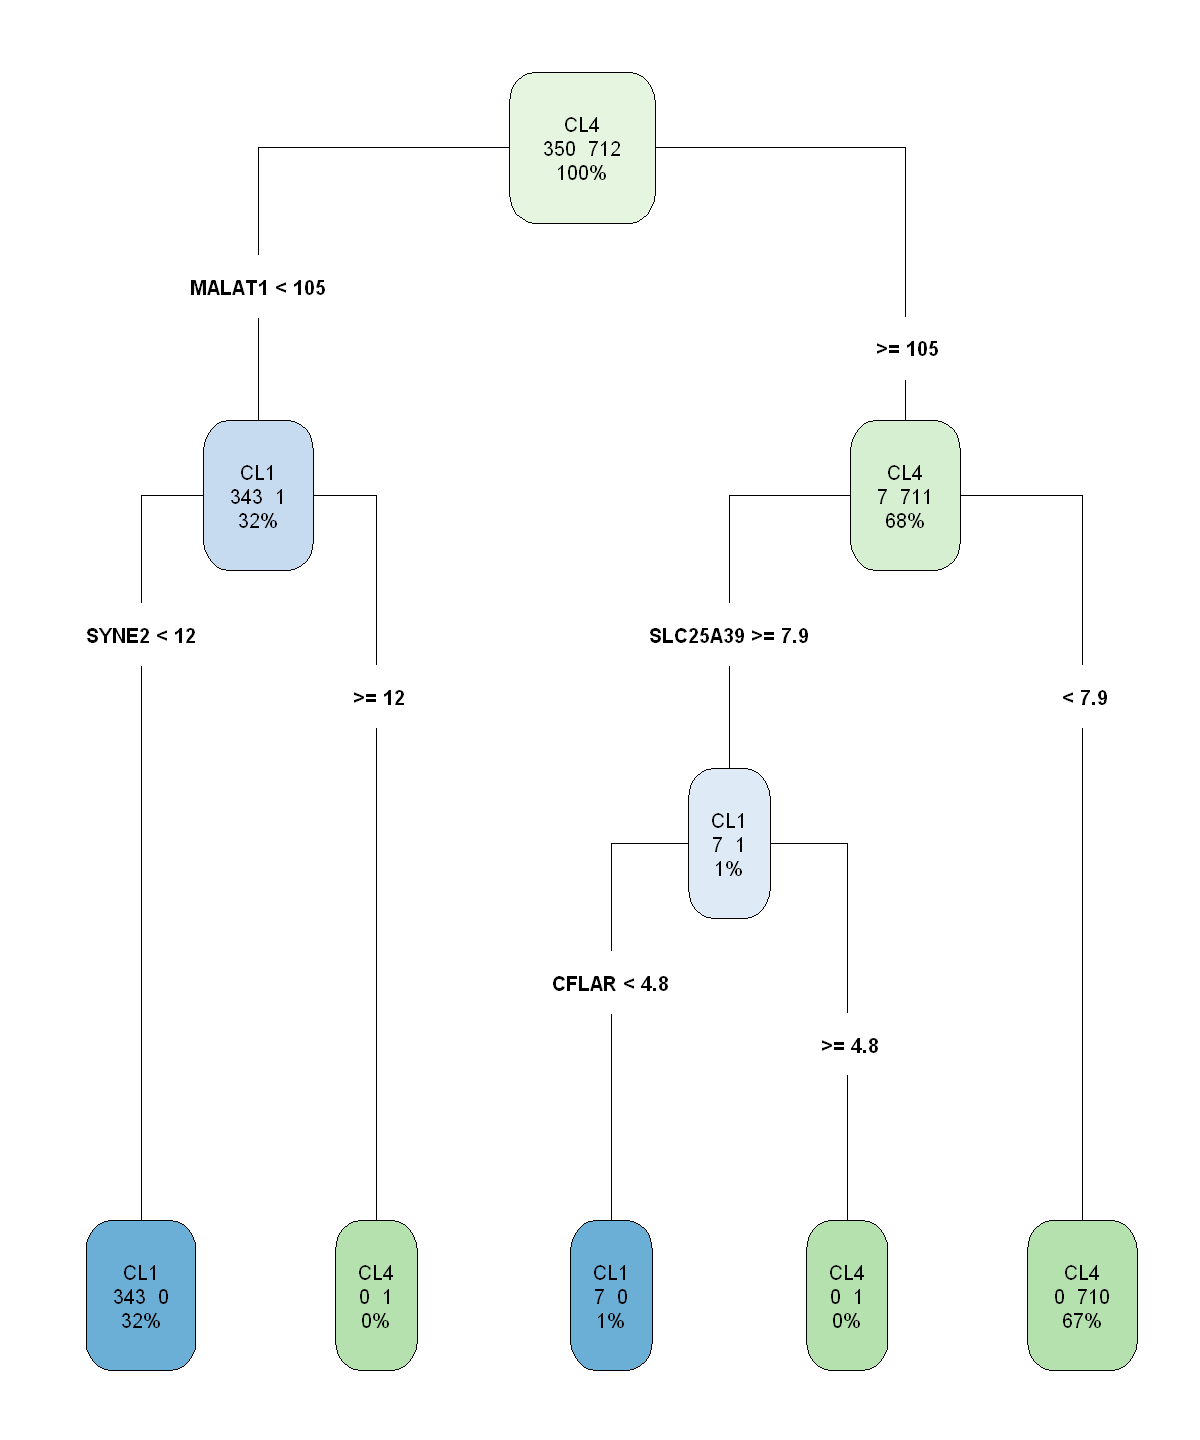

In [26]:
rpartDT<-RpartDT(DATAforDT)

#### 4.2.1. Evaluating the performance of the RPART Decision Tree

In [27]:
rpartEVAL<-RpartEVAL(DATAforDT,num.folds=10,First=First,Second=Second)

Fold 1 of 10

Fold 2 of 10

Fold 3 of 10

Fold 4 of 10

Fold 5 of 10

Fold 6 of 10

Fold 7 of 10

Fold 8 of 10

Fold 9 of 10

Fold 10 of 10



 TP  FN  FP  TN 
346   4   4 708 
             CL1 CL4
PredictedCL1 346   4
PredictedCL4   4 708


Rpart SN: 0.99
Rpart SP: 0.99
Rpart ACC: 0.99
Rpart MCC: 0.98




### 4.3. Networking Analysis

To define protein-protein interactions (PPI) over a list of genes, STRING-api is used. The outcome of STRING analysis was stored in tab separated values (TSV) files. These TSV files served as an input to check both the connectivity degree and the betweenness centrality, which reflects the communication flow in the defined PPI networks.

### 4.3.1 All DEGs

In [28]:
DEGs="All_DEGs"
FileName=paste0(DEGs)

data<-cdiffBinomial[[1]] [1:200,2]       # DEGs gene list from Binomial analysis (taking only the firat 200 genes)
#data<-cdiff[[1]] [,2]                    # From the table of the differential expression analysis between all pairs of clusters

ppi<-PPI(data,FileName)

networking<-NetAnalysis(ppi)
networking                            ##### In case the Examine response components = 200 and an error "linkmat[i, ]" appeared, that means there are no PPI.

Examine response components = 200	(200 means successful)


No encoding supplied: defaulting to UTF-8.

Number of nodes: 174

Number of links: 451

Link Density: 2.59195402298851

The connectance of the graph: 0.0149823931964654

Mean Distences2.52208201892744

Average Path Length2.52208201892744




names     degree betweenness
47  HSP90AA1  29     818.84444  
60  ACTB      24     389.53333  
116 RHOA      22       0.00000  
57  FYN       18     105.71667  
115 CD44      16      55.25000  
12  ENO1      15      82.85556  
52  CS        15     237.03889  
128 RPS20     15      26.20000  
149 VCL       15       0.00000  
5   TNFRSF1A  14      98.58333  
44  HSPA5     14     160.82222  
63  TFRC      14     191.15000  
84  EIF3I     13      84.65000  
30  SDHA      12      28.73889  
98  ACTN1     12      61.95000  
22  ITGA2B    11      76.75000  
39  CTNNA1    11      47.00000  
96  NME1-NME2 11      56.28333  
117 CAPZB     11       0.00000  
131 MDH1      11      24.41667  
134 RPL18     11      20.25000  
137 RPS5      11       0.00000  
11  SLC11A1   10      10.25000  
107 RPL31     10      16.48333  
142 PSMA4     10       0.00000  
14  SEC61A1    9      11.36667  
37  ITGB5      9      26.03333  
81  SLC25A5    9      26.06667  
83  CTSA       9      35.14444  
100 CD59       9      23.00000  
... ...       ...    ...        
169 LSG1      2      0          
42  MRPS24    1      0          
49  RASGRP2   1      0          
53  RBM5      1      0          
59  SH3YL1    1      0          
68  JMJD4     1      0          
80  ELOVL5    1      0          
82  FCN1      1      0          
92  IGF2BP2   1      0          
94  CCDC88C   1      0          
101 KAT6A     1      0          
111 ABHD5     1      0          
118 FAT1      1      0          
121 STXBP2    1      0          
126 ST3GAL1   1      0          
130 RNH1      1      0          
139 ST3GAL6   1      0          
141 SYPL1     1      0          
144 MAP4K5    1      0          
155 TBPL1     1      0          
162 DCBLD2    1      0          
164 JARID2    1      0          
165 DGKG      1      0          
166 INPP5A    1      0          
167 TFPI      1      0          
170 MGLL      1      0          
171 CD99      1      0          
172 PTPN18    1      0          
173 CX3CL1    1      0          
174 KLF6      1      0

Examine response components =200	(200 means successful)


You can see the network with high resolutionby clicking on the following link:
https://string-db.org/api/highres_image/network?identifiers=HSP90AA1%0dACTB%0dRHOA%0dFYN%0dCD44%0dENO1%0dCS%0dRPS20%0dVCL%0dTNFRSF1A%0dHSPA5%0dTFRC%0dEIF3I%0dSDHA%0dACTN1%0dITGA2B%0dCTNNA1%0dNME1-NME2%0dCAPZB%0dMDH1%0dRPL18%0dRPS5%0dSLC11A1%0dRPL31%0dPSMA4&species=9606



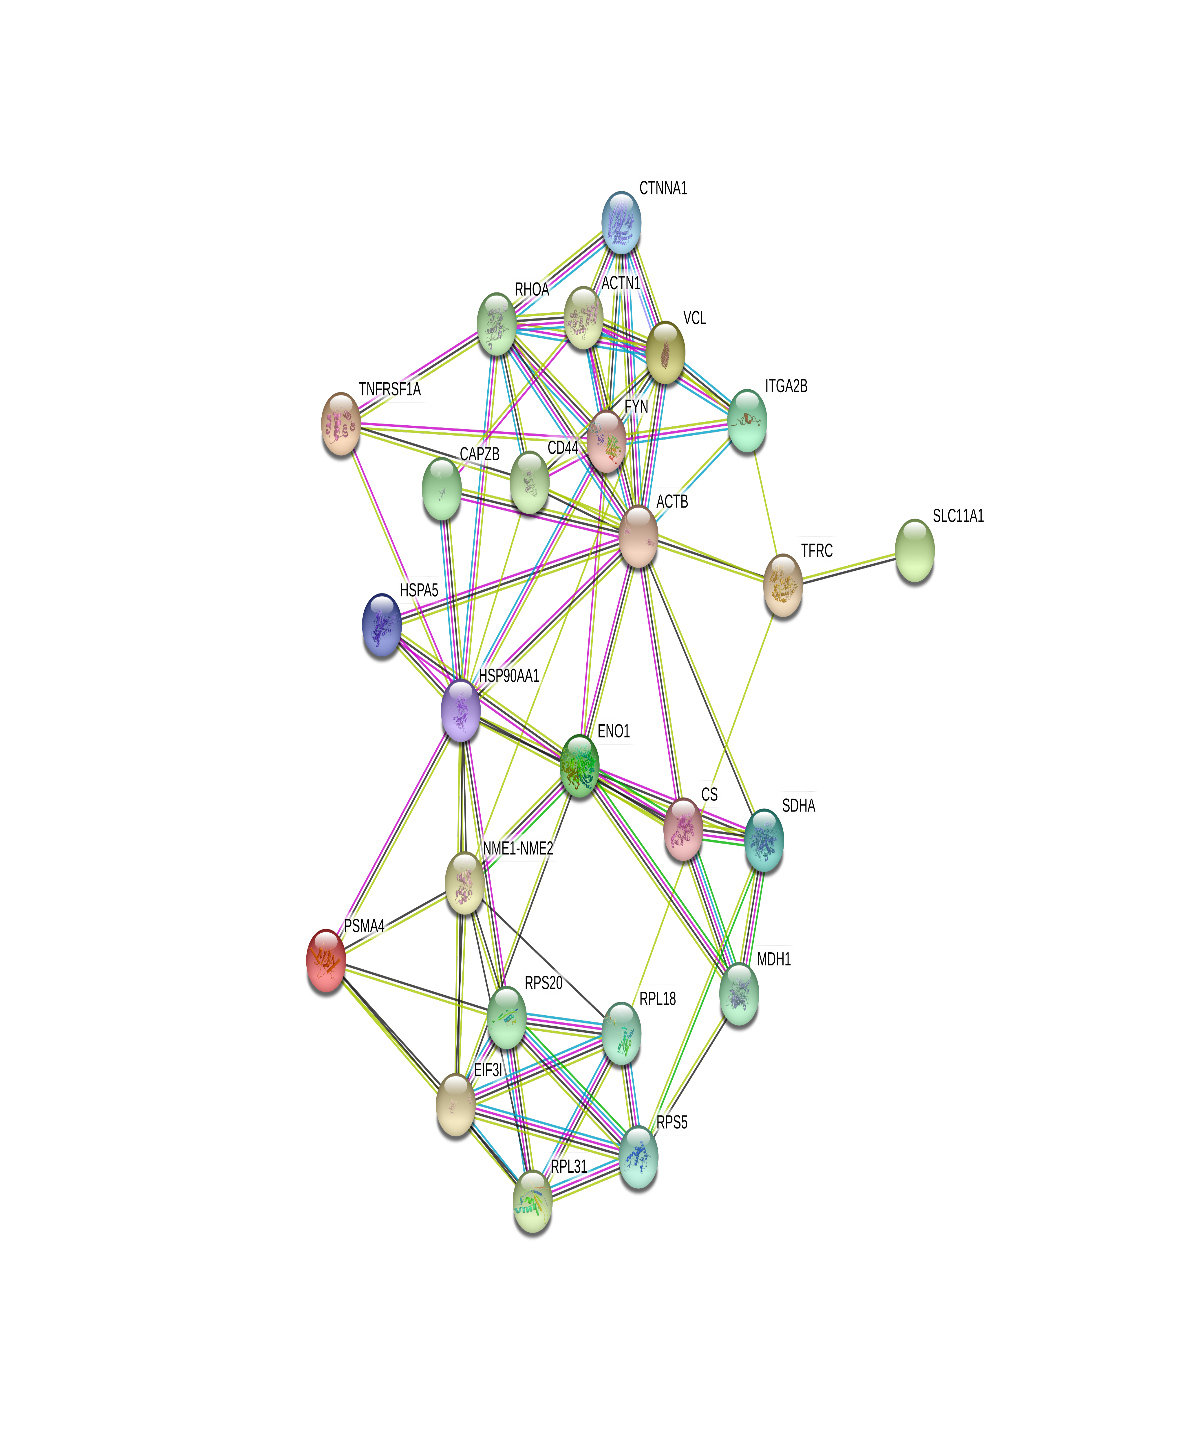

In [29]:
data=networking[1:25,1]              # plotting the network of the top 25 highly connected genes 
network<-Networking(data,FileName,plot_width = 25, plot_height = 10)


### 4.3.2 Particular set of DEGs 

Examine response components = 200	(200 means successful)


No encoding supplied: defaulting to UTF-8.

Number of nodes: 85

Number of links: 234

Link Density: 2.75294117647059

The connectance of the graph: 0.0327731092436975

Mean Distences2.15364916773367

Average Path Length2.15364916773367




names    degree betweenness
24  PPBP     22     126.0583333
25  PF4      19      79.1666667
49  ACTN1    19      54.4166667
19  FERMT3   18     118.5500000
11  ITGA2B   17      80.9083333
67  VCL      16       0.0000000
12  SELP     14      26.0666667
4   SERPINE1 12      10.2916667
14  F13A1    12       9.0000000
69  TIMP1    12       0.0000000
3   TGFB1    11       0.2500000
7   PLEK     11      87.0000000
8   SRGN     11      11.3333333
6   SPARC    10       0.5833333
50  ILK      10       8.1666667
71  GNG11    10       0.0000000
1   MYH9      9       5.0000000
30  GP1BA     9       9.5750000
27  GP9       8       9.5750000
35  MYLK      8       8.3333333
58  CXCL2     8      23.0000000
59  NFE2      8       0.0000000
62  B2M       8      26.0000000
18  MYL9      7       0.8333333
32  HBB       7      12.2250000
16  BIN2      6      35.0000000
44  CTTN      6      29.5000000
51  PARVB     6       2.6666667
5   P2RX1     5      62.0000000
9   TUBA4A    5       8.0000000
... ...      ...    ...        
57  ICAM2    3      0          
68  SLC2A3   3      0          
72  COTL1    3      0          
73  LYL1     3      0          
79  ODC1     3      0          
13  DGKD     2      0          
15  PRKAR2B  2      0          
29  HBA1     2      0          
42  RGS10    2      0          
43  GSTO1    2      1          
53  CLDN5    2      0          
55  CORO1C   2      0          
75  HBA2     2      0          
76  YWHAH    2      0          
78  CTDSPL   2      0          
38  RAB32    1      0          
45  FTL      1      0          
48  CDKN2D   1      0          
52  KIF2A    1      0          
56  GPX1     1      0          
63  ZFP36    1      0          
65  PTCRA    1      0          
74  NRGN     1      0          
77  PTPN18   1      0          
80  MMD      1      0          
81  CTSA     1      0          
82  CCND3    1      0          
83  IFRD1    1      0          
84  RNF11    1      0          
85  JUND     1      0

Examine response components =200	(200 means successful)


You can see the network with high resolutionby clicking on the following link:
https://string-db.org/api/highres_image/network?identifiers=PRKAR2B%0dITGA2B%0dIFRD1%0dVCL%0dSLC2A3%0dCTSA%0dMYLK%0dKIF2A%0dRASGRP2%0dMAST4%0dRDH11%0dACTN1%0dPTPN18%0dATP2A3%0dDGKD%0dCXCL2%0dCTTN%0dFTL%0dTMEM40%0dMYL6%0dPTGS1%0dKCNK6%0dMYH9%0dGRAP2%0dTUBB1%0dMYL9%0dRIOK3%0dPGRMC1%0dTIMP1%0dCOTL1%0dLYL1%0dOAZ1%0dTGFB1%0dSERPINE1%0dXPNPEP1%0dP2RX1%0dICAM2%0dABCC3%0dMMD%0dCORO1C%0dBIN2%0dACRBP%0dCCND3%0dSPARC%0dODC1%0dWIPF1%0dPLEK%0dRAB32%0dLGALSL%0dSRGN%0dRNF11%0dNFE2%0dAMD1%0dF13A1%0dFAM110A%0dMAX%0dRAP1B%0dTUBA4A%0dGNG11%0dZFP36%0dYWHAH%0dGNAZ%0dTPST2%0dCDKN2D%0dSAT1%0dARPC1B%0dJUND%0dRBM38%0dITM2B%0dSH3BGRL3%0dS100A8%0dCTDSPL%0dSTOM%0dGSTO1%0dRGS10%0dESAM%0dFERMT3%0dRGS18%0dMBNL1%0dCMIP%0dNRGN%0dTSPAN33%0dPTGIR%0dTAL1%0dNEXN%0dCNST%0dS100A9%0dCXCL3%0dPPBP%0dPF4%0dCLEC1B%0dILK%0dPRKCB%0dB2M%0dGP9%0dLIMS1%0dPTCRA%0dSELP%0dRUFY1%0dCLDN5%0dGP1BA%0dNAP1L1

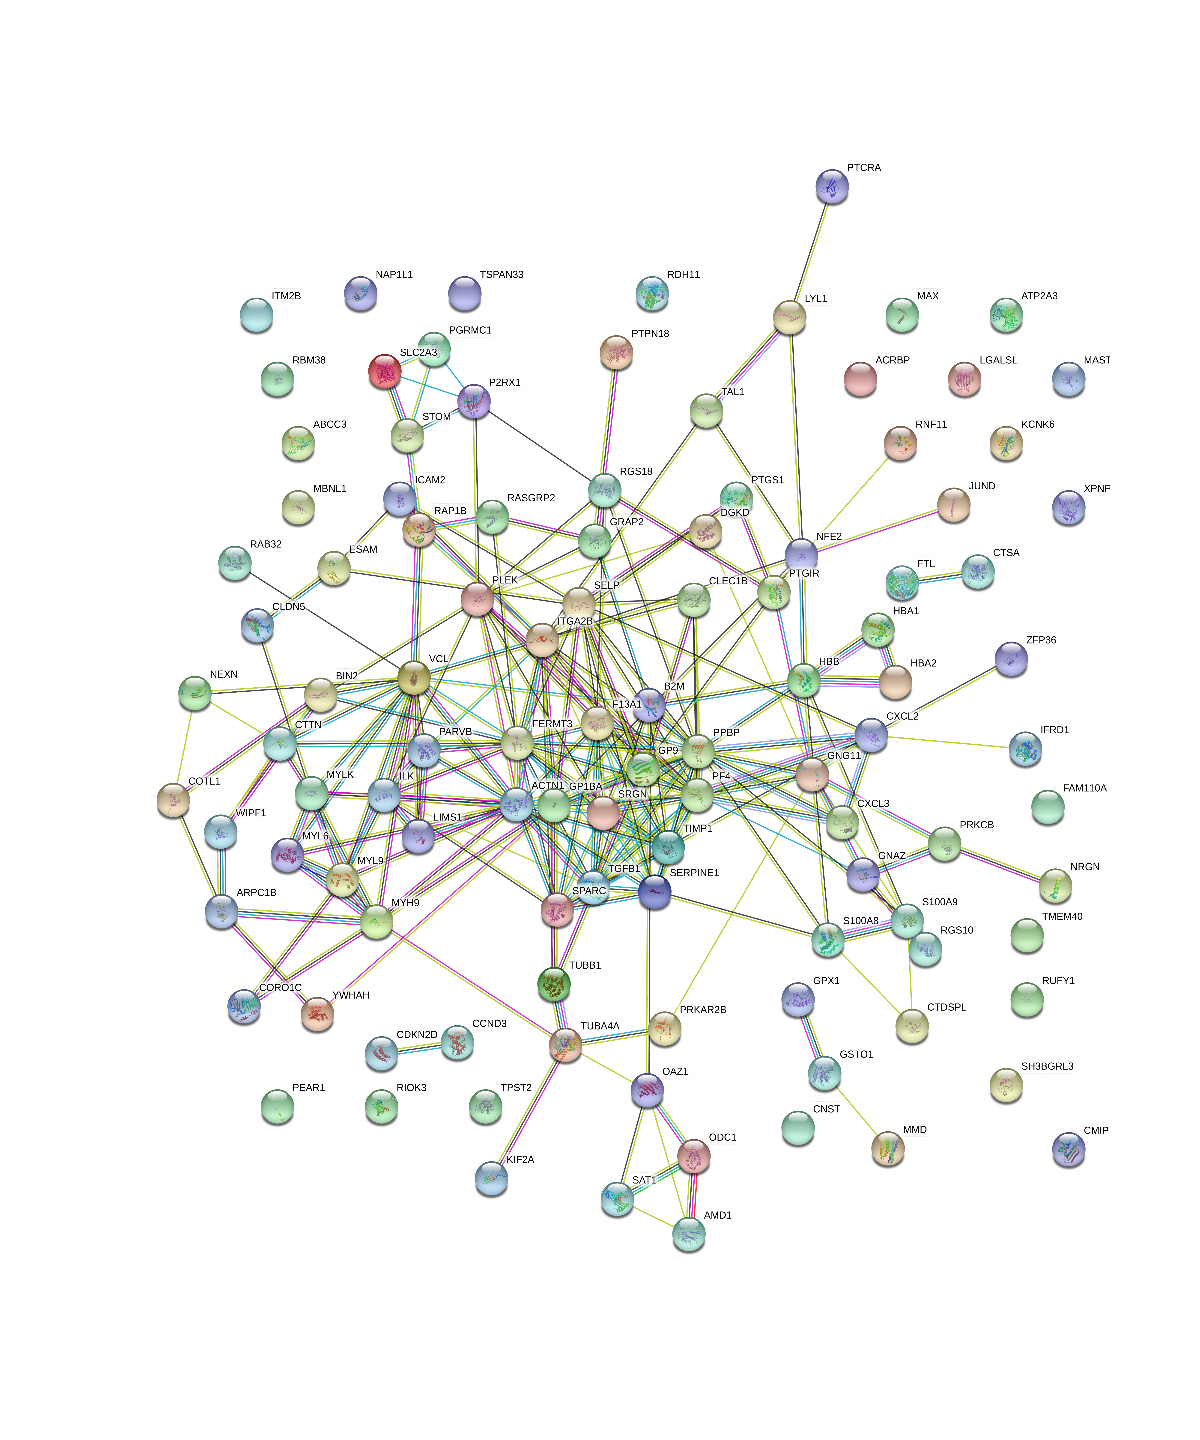

In [30]:
############ Selecting the DEGs' table  ##############
DEGs=cdiff[[2]][1,4]             # Up-regulated genes in cluster 1 (from SAMseq)
FileName=paste0(DEGs)

data<-read.csv(file=paste0(DEGs),head=TRUE,sep=",")
data<-data[,3]

ppi<-PPI(data,FileName)

networking<-NetAnalysis(ppi)
networking                            ##### In case the Examine response components = 200 and an error "linkmat[i, ]" appeared, that means there are no PPI.

network<-Networking(data,FileName)

### 4.4 Gene Enrichment Analysis

In [31]:
dbs <- listEnrichrDbs()
head(dbs)
#print(dbs)

geneCoverage genesPerTerm libraryName                     
1 13362         275         Genome_Browser_PWMs             
2 27884        1284         TRANSFAC_and_JASPAR_PWMs        
3  6002          77         Transcription_Factor_PPIs       
4 47172        1370         ChEA_2013                       
5 47107         509         Drug_Perturbations_from_GEO_2014
6 21493        3713         ENCODE_TF_ChIP-seq_2014         
  link                                                     numTerms
1 http://hgdownload.cse.ucsc.edu/goldenPath/hg18/database/ 615     
2 http://jaspar.genereg.net/html/DOWNLOAD/                 326     
3                                                          290     
4 http://amp.pharm.mssm.edu/lib/cheadownload.jsp           353     
5 http://www.ncbi.nlm.nih.gov/geo/                         701     
6 http://genome.ucsc.edu/ENCODE/downloads.html             498

In [32]:
############ Selecting the DEGs' table  ##############
#DEGs=cdiffBinomial[[2]][1,4]     # Up-regulated genes in cluster 1 (from the Binomial analysis)
DEGs=cdiff[[2]][1,4]              # Up-regulated genes in cluster 1 (from SAMseq)

data<-read.csv(file=paste0(DEGs),head=TRUE,sep=",")
data<-as.character(data[,3])

dbs <- c("KEGG_2013","GO_Biological_Process_2015")
enriched <- enrichr(data, dbs)
KEGG_2013<-enriched[[1]][,c(1,2,3,9)]
GO_Biological_Process_2015<-enriched[[2]][,c(1,2,3,9)]

GEA<-rbind(KEGG_2013,GO_Biological_Process_2015)
GEA

Uploading data to Enrichr... Done.
  Querying KEGG_2013... Done.
  Querying GO_Biological_Process_2015... Done.
Parsing results... Done.


Term                                                                
1    HSA04510 FOCAL ADHESION                                             
2    HSA04670 LEUKOCYTE TRANSENDOTHELIAL MIGRATION                       
3    HSA04810 REGULATION OF ACTIN CYTOSKELETON                           
4    HSA00220 UREA CYCLE AND METABOLISM OF AMINO GROUPS                  
5    HSA04530 TIGHT JUNCTION                                             
6    HSA05130 PATHOGENIC ESCHERICHIA COLI INFECTION EHEC                 
7    HSA05131 PATHOGENIC ESCHERICHIA COLI INFECTION EPEC                 
8    HSA04110 CELL CYCLE                                                 
9    HSA04514 CELL ADHESION MOLECULES                                    
10   HSA04512 ECM RECEPTOR INTERACTION                                   
11   HSA04640 HEMATOPOIETIC CELL LINEAGE                                 
12   HSA04060 CYTOKINE CYTOKINE RECEPTOR INTERACTION                     
13   HSA04010 MAPK SIGNALING PATHWAY                                     
14   HSA00590 ARACHIDONIC ACID METABOLISM                                
15   HSA00625 TETRACHLOROETHENE DEGRADATION                              
16   HSA04115 P53 SIGNALING PATHWAY                                      
17   HSA04610 COMPLEMENT AND COAGULATION CASCADES                        
18   HSA05211 RENAL CELL CARCINOMA                                       
19   HSA04520 ADHERENS JUNCTION                                          
20   HSA04020 CALCIUM SIGNALING PATHWAY                                  
21   HSA00363 BISPHENOL A DEGRADATION                                    
22   HSA05222 SMALL CELL LUNG CANCER                                     
23   HSA04614 RENIN ANGIOTENSIN SYSTEM                                   
24   HSA00271 METHIONINE METABOLISM                                      
25   HSA05030 AMYOTROPHIC LATERAL SCLEROSIS                              
26   HSA04540 GAP JUNCTION                                               
27   HSA00591 LINOLEIC ACID METABOLISM                                   
28   HSA00052 GALACTOSE METABOLISM                                       
29   HSA00120 BILE ACID BIOSYNTHESIS                                     
30   HSA00480 GLUTATHIONE METABOLISM                                     
...  ...                                                                 
1614 behavior (GO:0007610)                                               
1615 epithelium development (GO:0060429)                                 
1616 regulation of small GTPase mediated signal transduction (GO:0051056)
1617 response to oxygen levels (GO:0070482)                              
1618 regulation of translation (GO:0006417)                              
1619 regulation of DNA metabolic process (GO:0051052)                    
1620 reproductive structure development (GO:0048608)                     
1621 organic acid biosynthetic process (GO:0016053)                      
1622 carboxylic acid biosynthetic process (GO:0046394)                   
1623 positive regulation of secretion (GO:0051047)                       
1624 neurotrophin TRK receptor signaling pathway (GO:0048011)            
1625 phospholipid metabolic process (GO:0006644)                         
1626 establishment of protein localization to organelle (GO:0072594)     
1627 histone modification (GO:0016570)                                   
1628 Fc-epsilon receptor signaling pathway (GO:0038095)                  
1629 covalent chromatin modification (GO:0016569)                        
1630 nuclear division (GO:0000280)                                       
1631 epithelial cell differentiation (GO:0030855)                        
1632 organelle fission (GO:0048285)                                      
1633 alcohol metabolic process (GO:0006066)                              
1634 single-organism behavior (GO:0044708)                               
1635 monovalent inorganic cation transport (GO:0015672)                  
1636 gene

## Running the DIscBIO pipeline based on a list of genes related to Golgi Fragmentation

### 1. Preparing the dataset

In [33]:
FG<- DISCBIO(DataSet)
FG<-Normalizedata(FG, mintotal=1000, minexpr=0, minnumber=0, maxexpr=Inf, downsample=FALSE, dsn=1, rseed=17000) 
FG<-FinalPreprocessing(FG,GeneFlitering="ExpF",export = TRUE)        # The GeneFiltering should be set to "ExpF"

GolgiFragGeneList<- read.csv(file = "GolgiFragGeneList.csv", sep = ",",header=F)
Data<-FG@fdata 
genes<-rownames(Data)
gene_list<- GolgiFragGeneList[,1]
idx_genes <- is.element(genes,gene_list)
OAdf<-Data[idx_genes,]   
FG@fdata<-OAdf
dim(FG@fdata)
cat(paste0("A list of ", length(OAdf[,1]), " genes will be used for the clustering","\n"))

The gene filtering method = Noise filtering

The Filtered Normalized dataset contains:
Genes: 13181
cells: 1448



The Filtered Normalized dataset was saved as: filteredDataset.Rdata



[1]   97 1448

A list of 97 genes will be used for the clustering


### 2. Cellular Clustering and Pseudo Time ordering

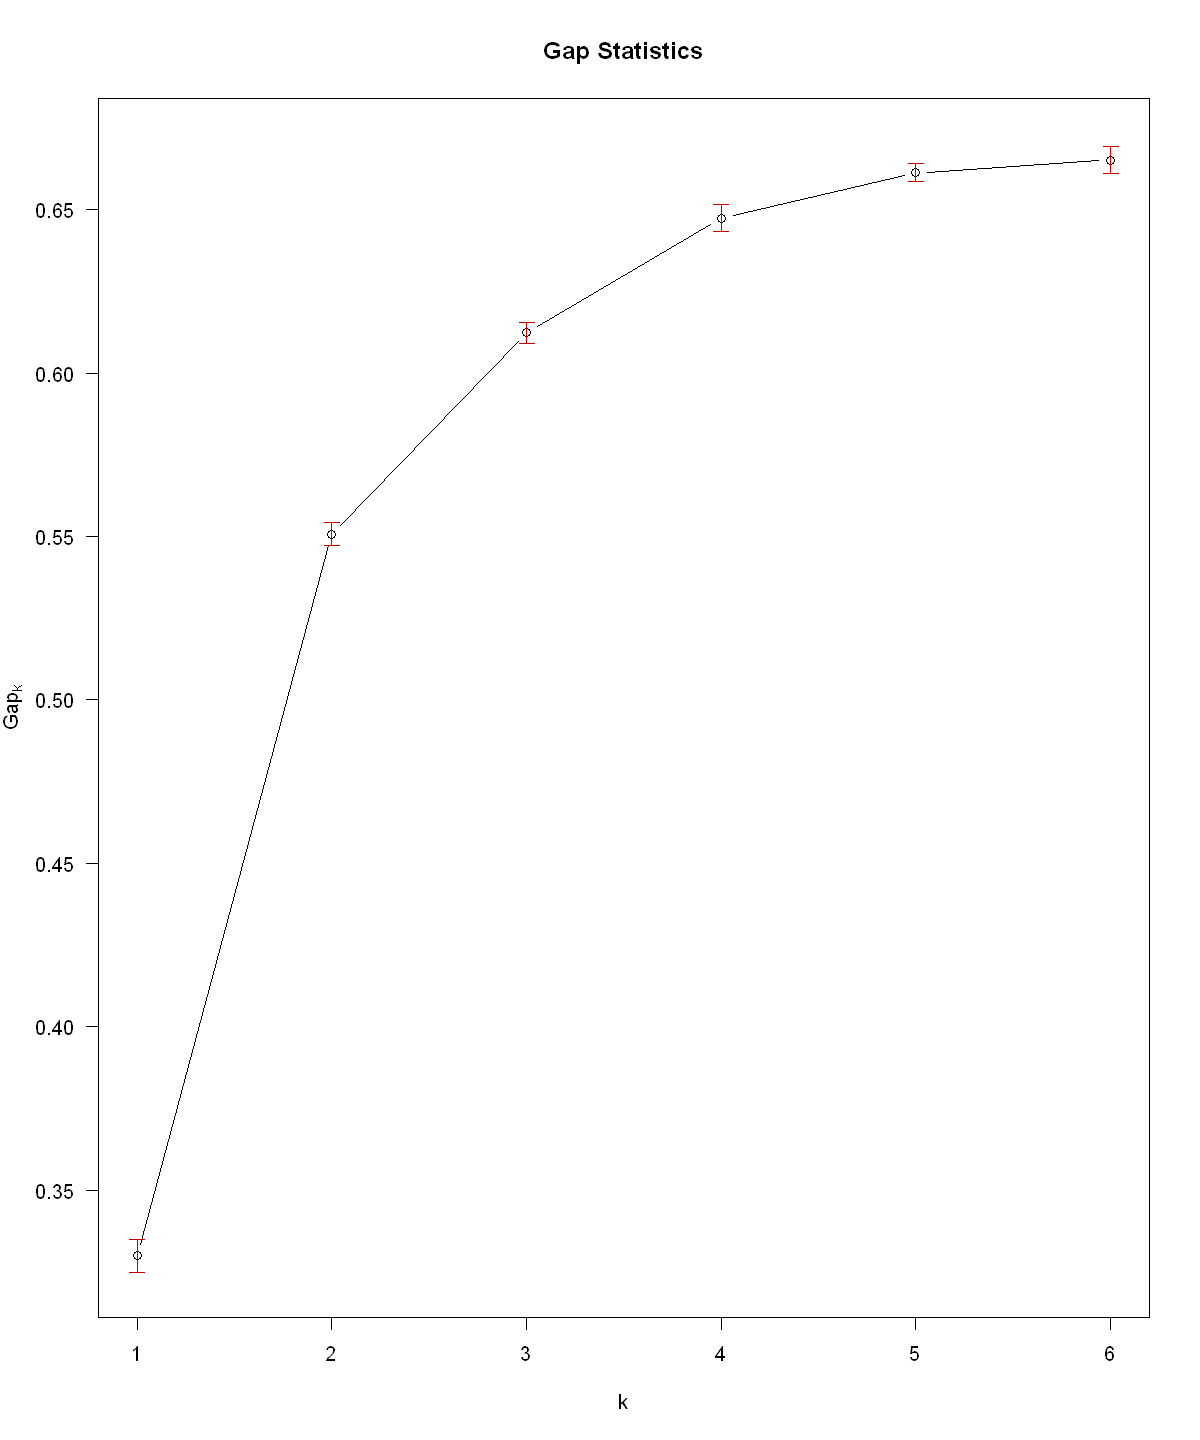

In [34]:
K= 4                                                      # Getting 4 clusters
FG<- Clustexp(FG,cln=K,quiet=T,clustnr=6,rseed=17000)    
plotGap(FG)                                               ### Plotting gap statistics

In [35]:
FG<- comptSNE(FG,rseed=15555,quiet = T)          # to perform the computation of a t-SNE map
#print(FG@cpart)                                 # to show the clusters with the cell-ID

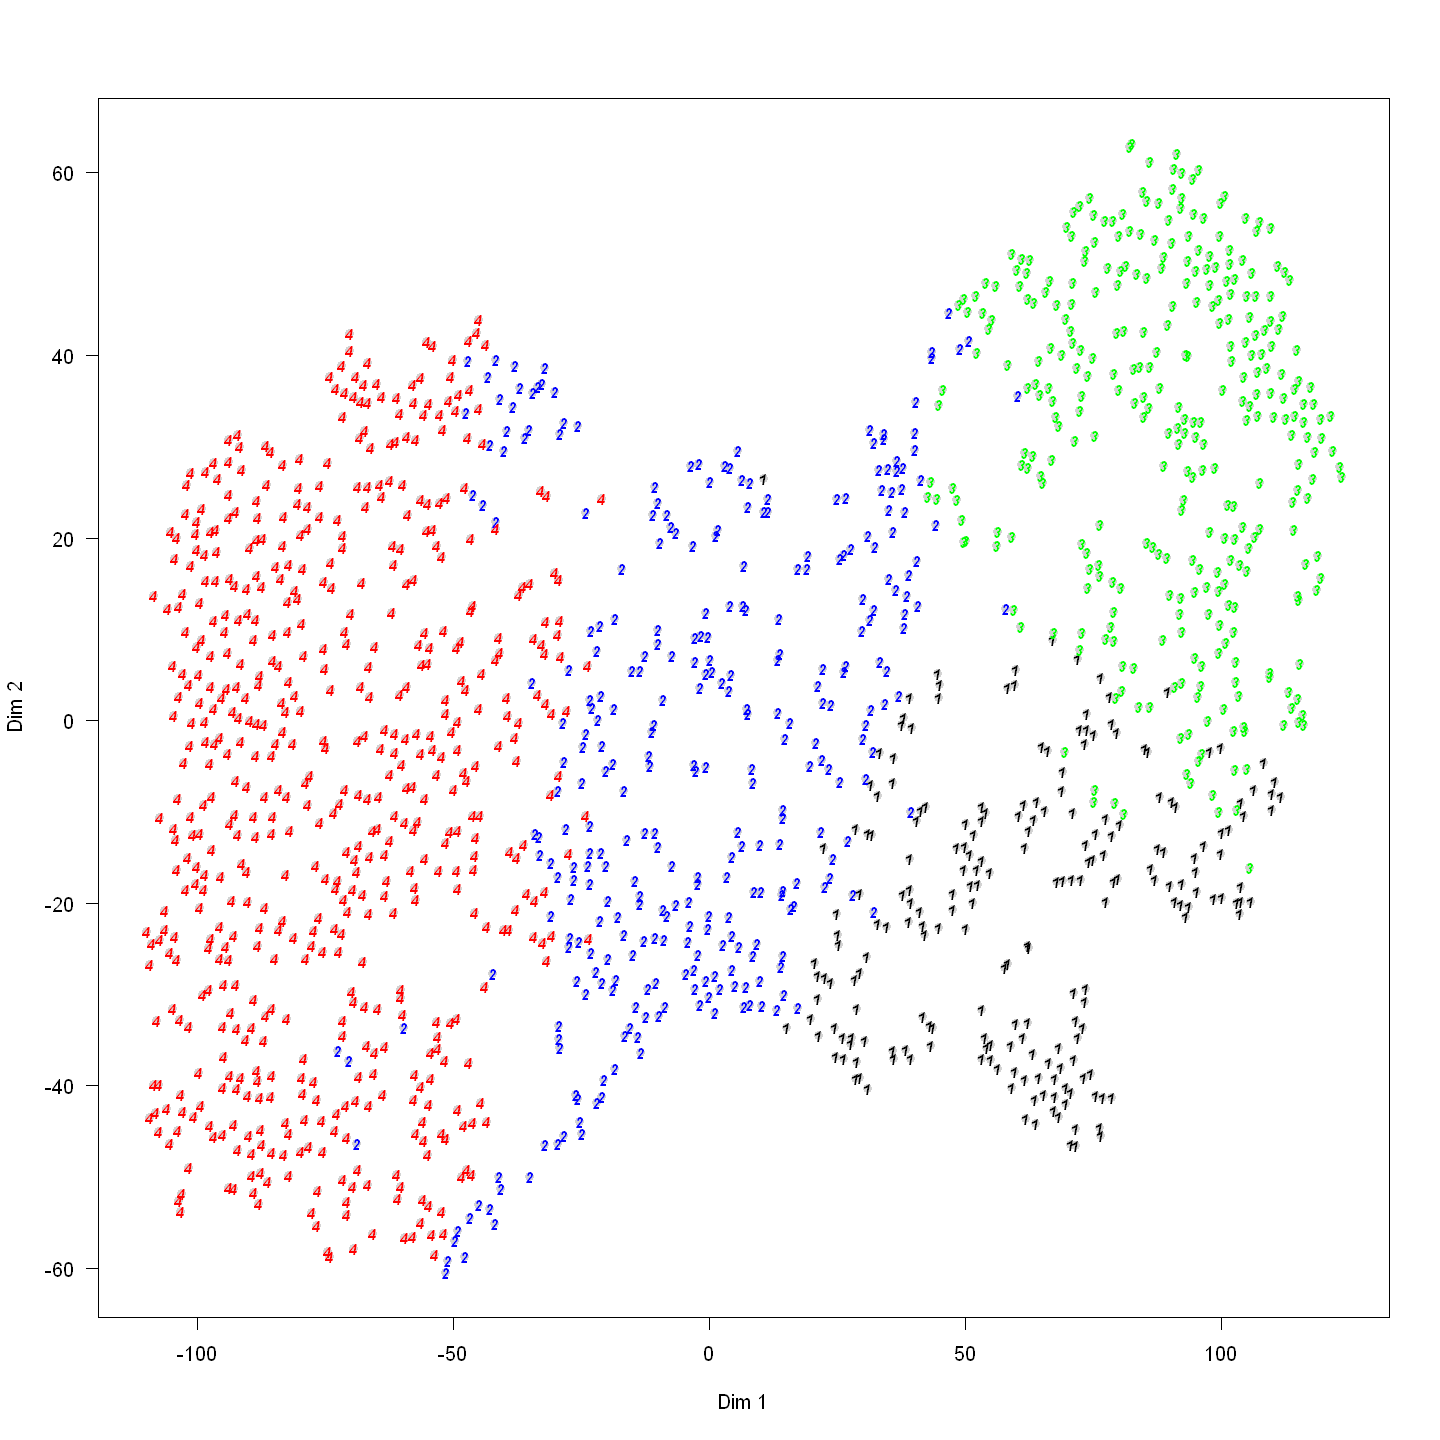

In [36]:
############ Plotting the clusters
options(repr.plot.width=12, repr.plot.height=12)
plottSNE(FG)

     order                             orderID
1        1      CTC_GSE86978_Brx50_2_031113_77
2        2                CTC_GSE55807_CTC_5_6
3        3                CTC_GSE55807_CTC_4_6
4        4                 CTC_hyrdo_seq_2H_29
5        5                 CTC_hyrdo_seq_3F_41
6        6                 CTC_hyrdo_seq_3F_27
7        7      CTC_GSE51827_Patient_8_SC.3_29
8        8  CTC_GSE86978_Brx61_1_SC4_032012_77
9        9  CTC_GSE86978_Brx72_1_SC5_031813_77
10      10         CTC_GSE109761_CD_LM2_38_212
11      11                 CTC_hyrdo_seq_2H_66
12      12         CTC_GSE109761_CD_LM2_37_212
13      13                 CTC_hyrdo_seq_3F_53
14      14            CTC_GSE109761_Br11_6_212
15      15  CTC_GSE86978_Brx61_1_SC3_032012_77
16      16                CTC_GSE55807_CTC_3_6
17      17                 CTC_hyrdo_seq_3D_18
18      18          CTC_GSE109761_Br16_B30_212
19      19                 CTC_hyrdo_seq_3F_46
20      20            CTC_GSE109761_Br39_1_212
21      21   

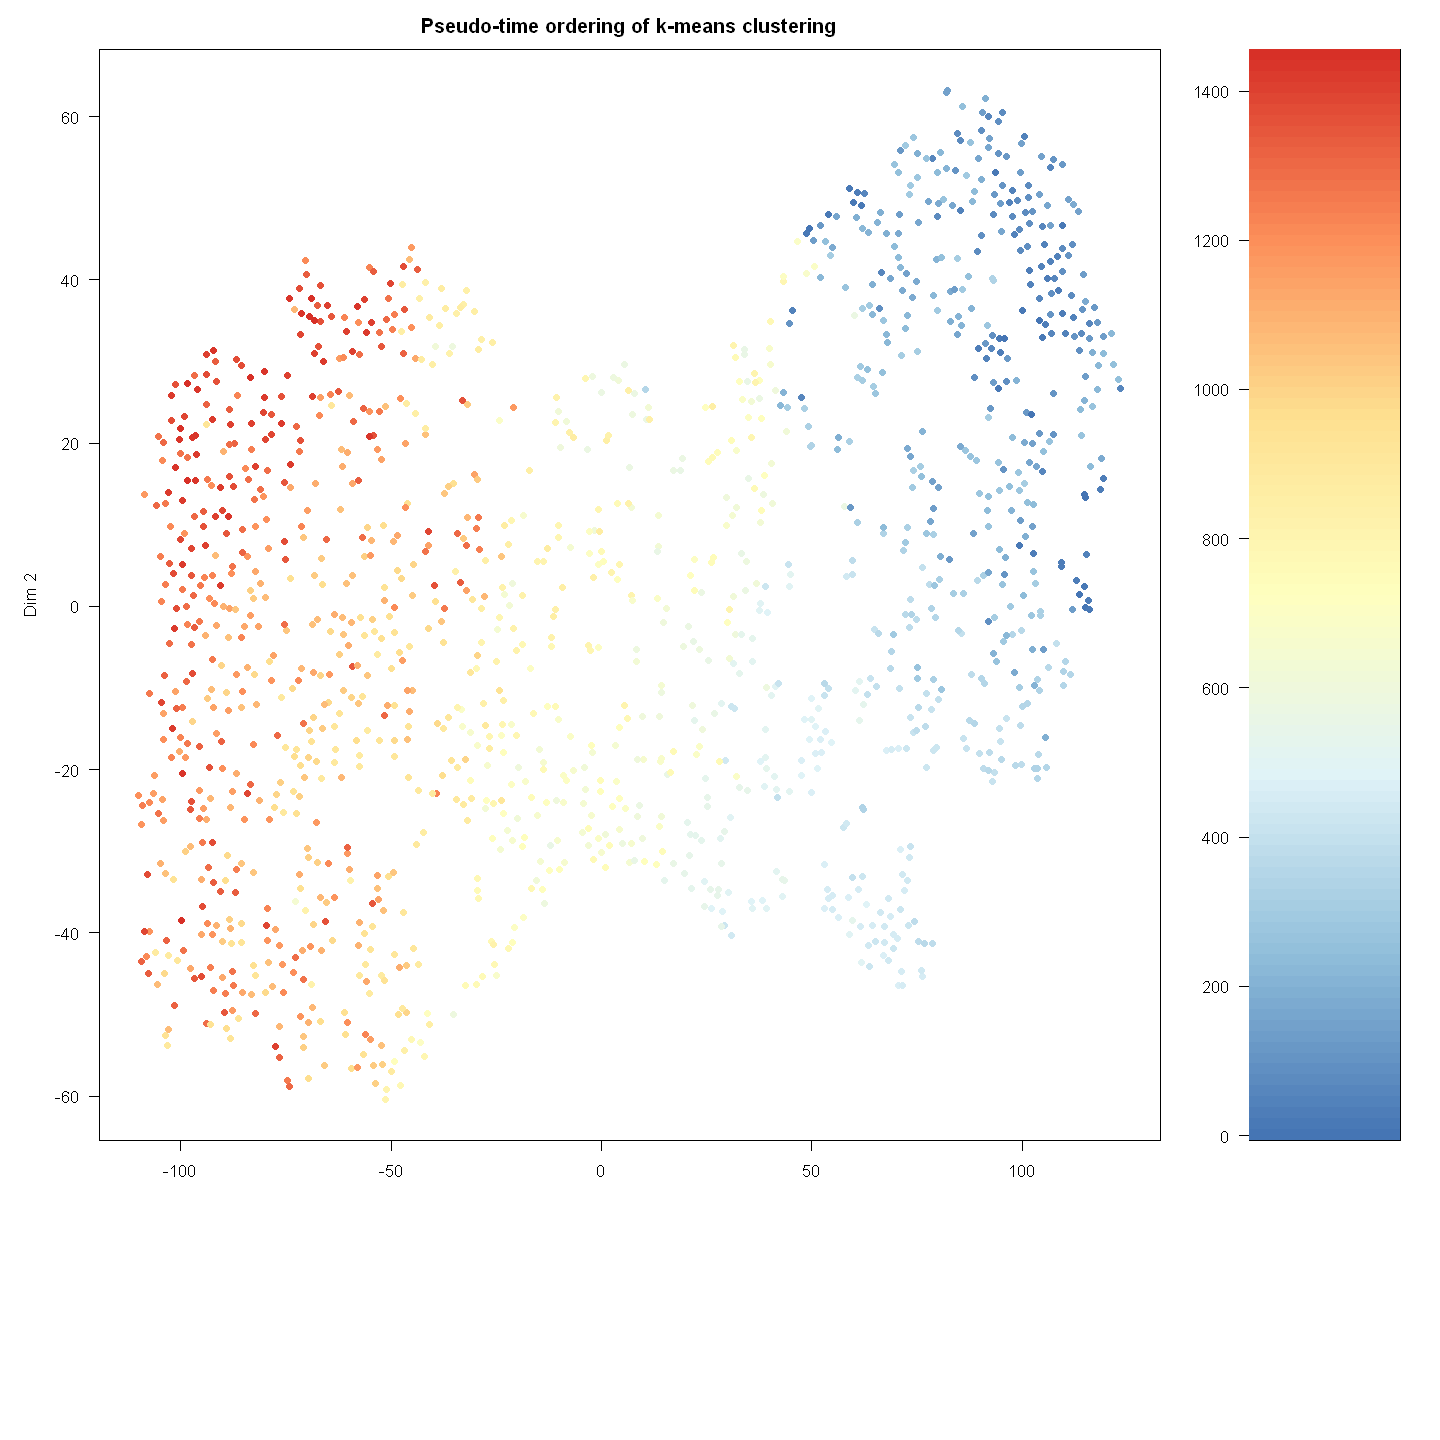

In [37]:
FG<-KmeanOrder(FG,quiet = FALSE, export = FALSE)
plotOrderTsne(FG)

[1] 3 1 2 4

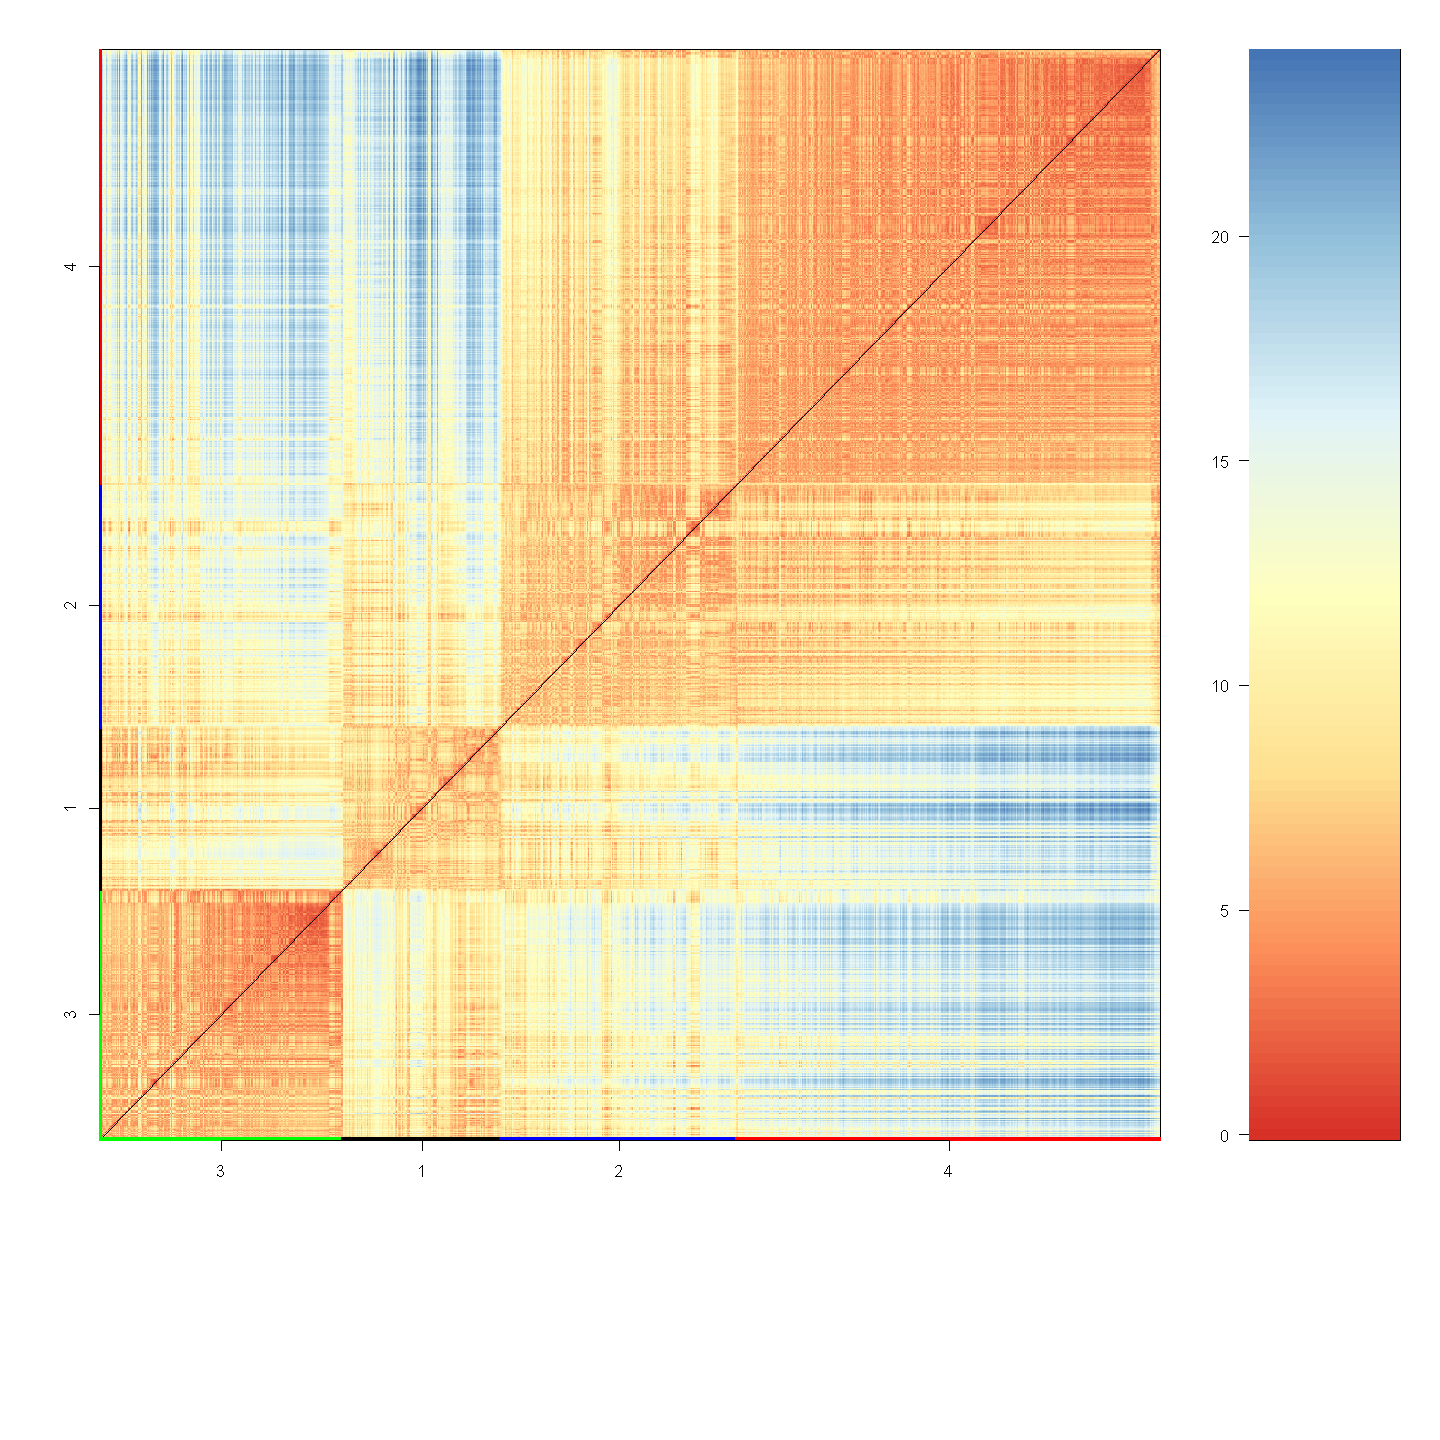

In [38]:
clustheatmap(FG)

####  Evaluating the stability and consistancy of the clusters

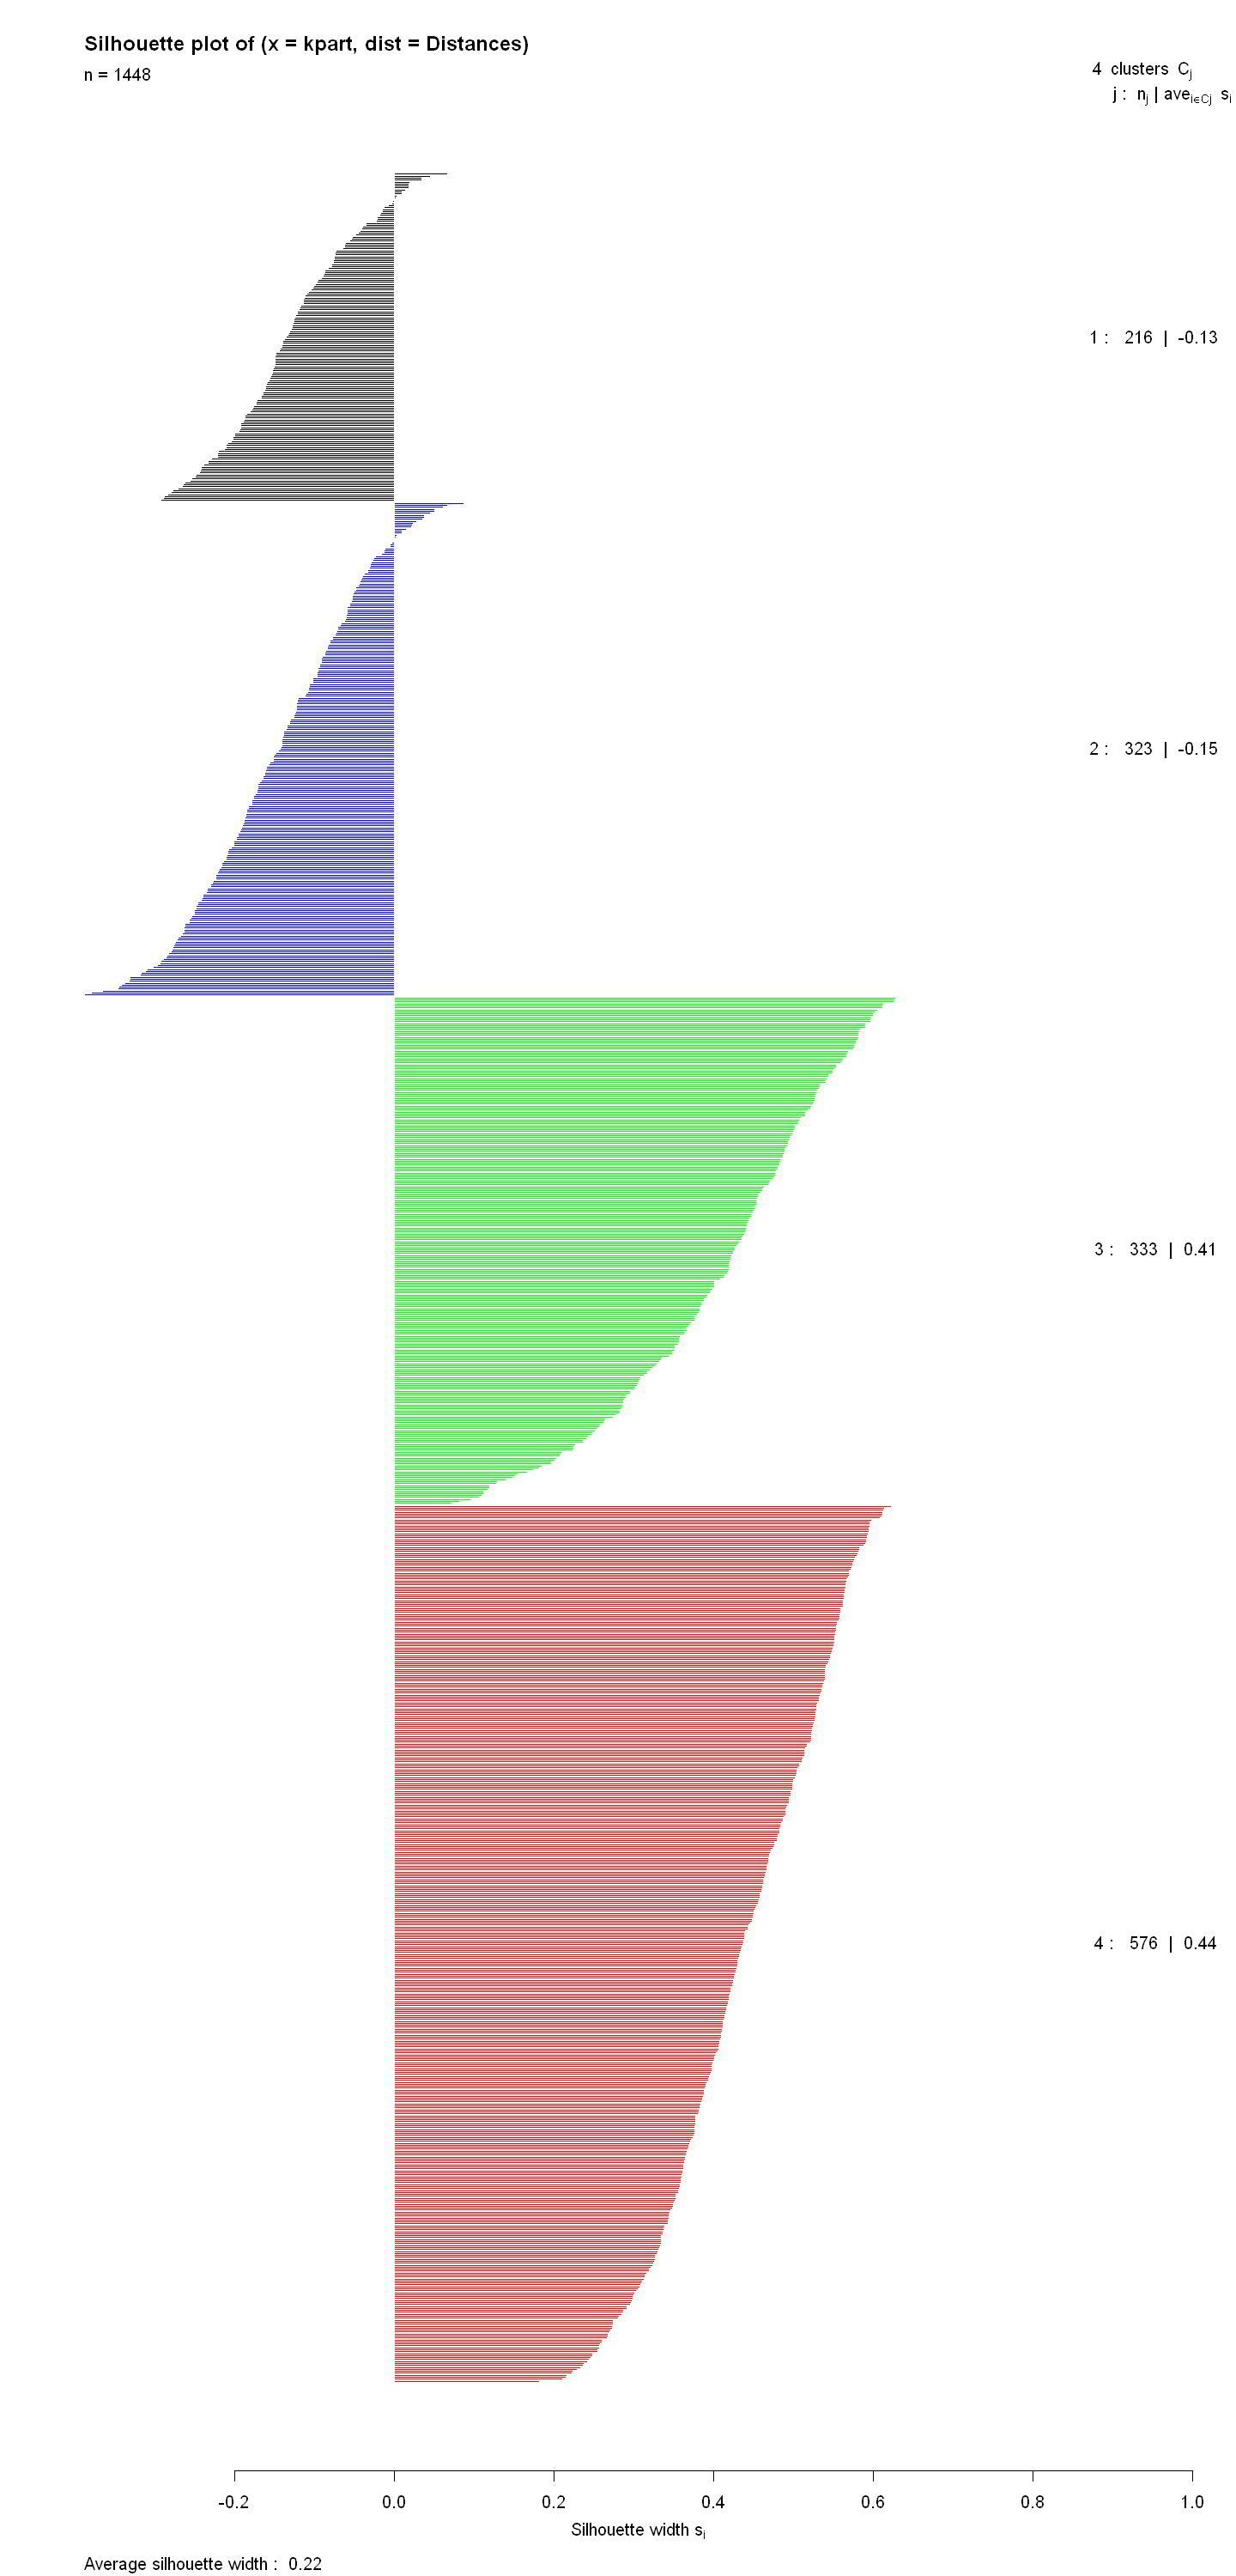

In [39]:
# Silhouette plot
options(repr.plot.width=12, repr.plot.height=25)
plotSilhouette(FG,K=4)       # K is the number of clusters

[1] 0.749 0.671 0.545 0.772

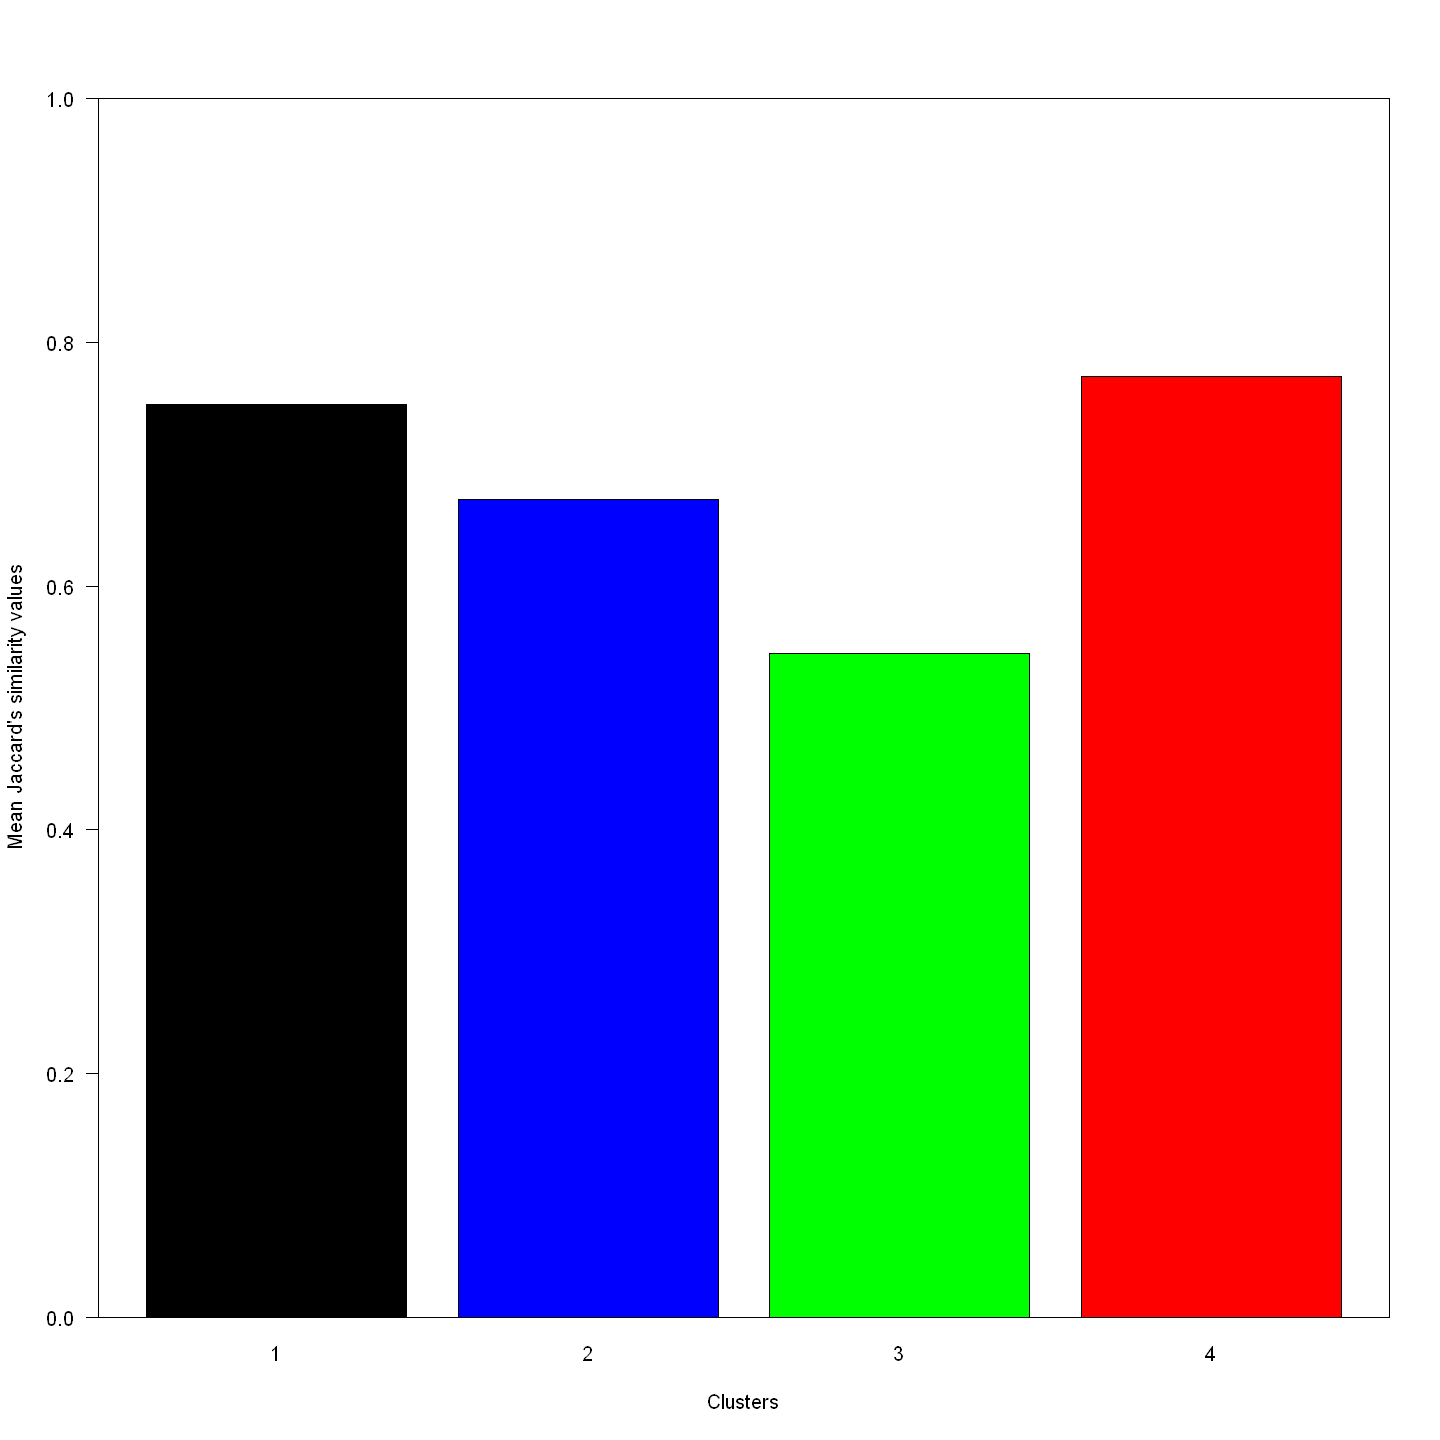

In [40]:
# Jaccard Plot
options(repr.plot.width=12, repr.plot.height=12)
Jaccard(FG,Clustering="K-means", K=4, plot = TRUE)     # Jaccard 

####  Plotting the gene expression of a particular gene in a tSNE map

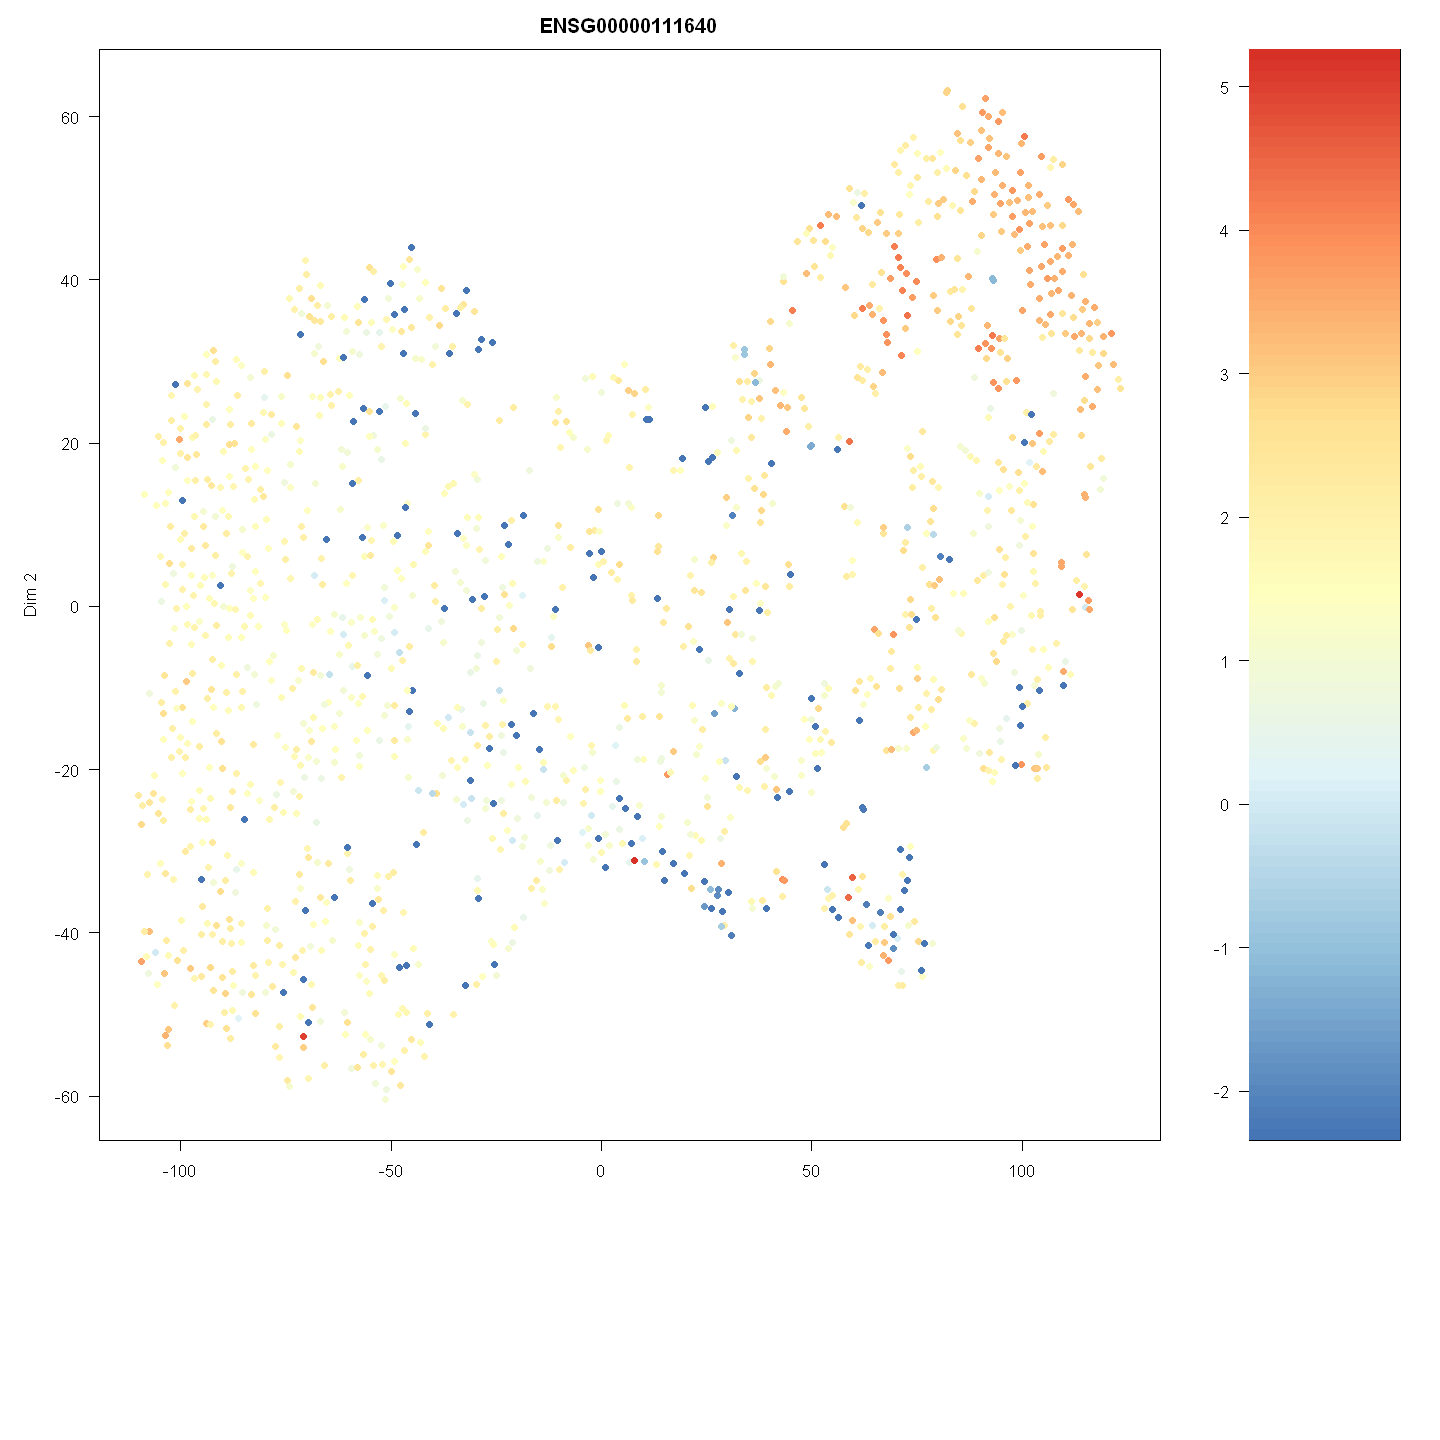

In [41]:
g='ENSG00000111640'                   #### Plotting the log expression of  GAPDH
plotExptSNE(FG,g)

### 3. Identifying DEGs

#### 3.1 Identifying DEGs between two particular clusters using SAMseq

[1] 95000

Estimating sequencing depths...

Resampling to get new data matrices...

perm = 1

perm = 2

perm = 3

perm = 4

perm = 5

perm = 6

perm = 7

perm = 8

perm = 9

perm = 10

perm = 11

perm = 12

perm = 13

perm = 14

perm = 15

perm = 16

perm = 17

perm = 18

perm = 19

perm = 20

perm = 21

perm = 22

perm = 23

perm = 24

perm = 25

perm = 26

perm = 27

perm = 28

perm = 29

perm = 30

perm = 31

perm = 32

perm = 33

perm = 34

perm = 35

perm = 36

perm = 37

perm = 38

perm = 39

perm = 40

perm = 41

perm = 42

perm = 43

perm = 44

perm = 45

perm = 46

perm = 47

perm = 48

perm = 49

perm = 50

perm = 51

perm = 52

perm = 53

perm = 54

perm = 55

perm = 56

perm = 57

perm = 58

perm = 59

perm = 60

perm = 61

perm = 62

perm = 63

perm = 64

perm = 65

perm = 66

perm = 67

perm = 68

perm = 69

perm = 70

perm = 71

perm = 72

perm = 73

perm = 74

perm = 75

perm = 76

perm = 77

perm = 78

perm = 79

perm = 80

perm = 81

perm = 82

perm = 83

perm = 84

perm = 85

p

DEGsE           DEGsS   
[1,] ENSG00000008394 MGST1   
[2,] ENSG00000065361 ERBB3   
[3,] ENSG00000080824 HSP90AA1
[4,] ENSG00000089157 RPLP0   
[5,] ENSG00000089220 PEBP1   
[6,] ENSG00000092820 EZR

Comparisons Target cluster Gene number
1 CL1 VS CL2  CL2            1013       
2 CL1 VS CL2  CL1            1013       
  File name                                 Gene number
1 Up-regulated-CL1_vs_CL2CL2inCL1VSCL2.csv  127        
2 Low-regulated-CL1_vs_CL2CL1inCL1VSCL2.csv 127        
  File name                                
1 Low-regulated-CL1_vs_CL2CL2inCL1VSCL2.csv
2 Up-regulated-CL1_vs_CL2CL1inCL1VSCL2.csv

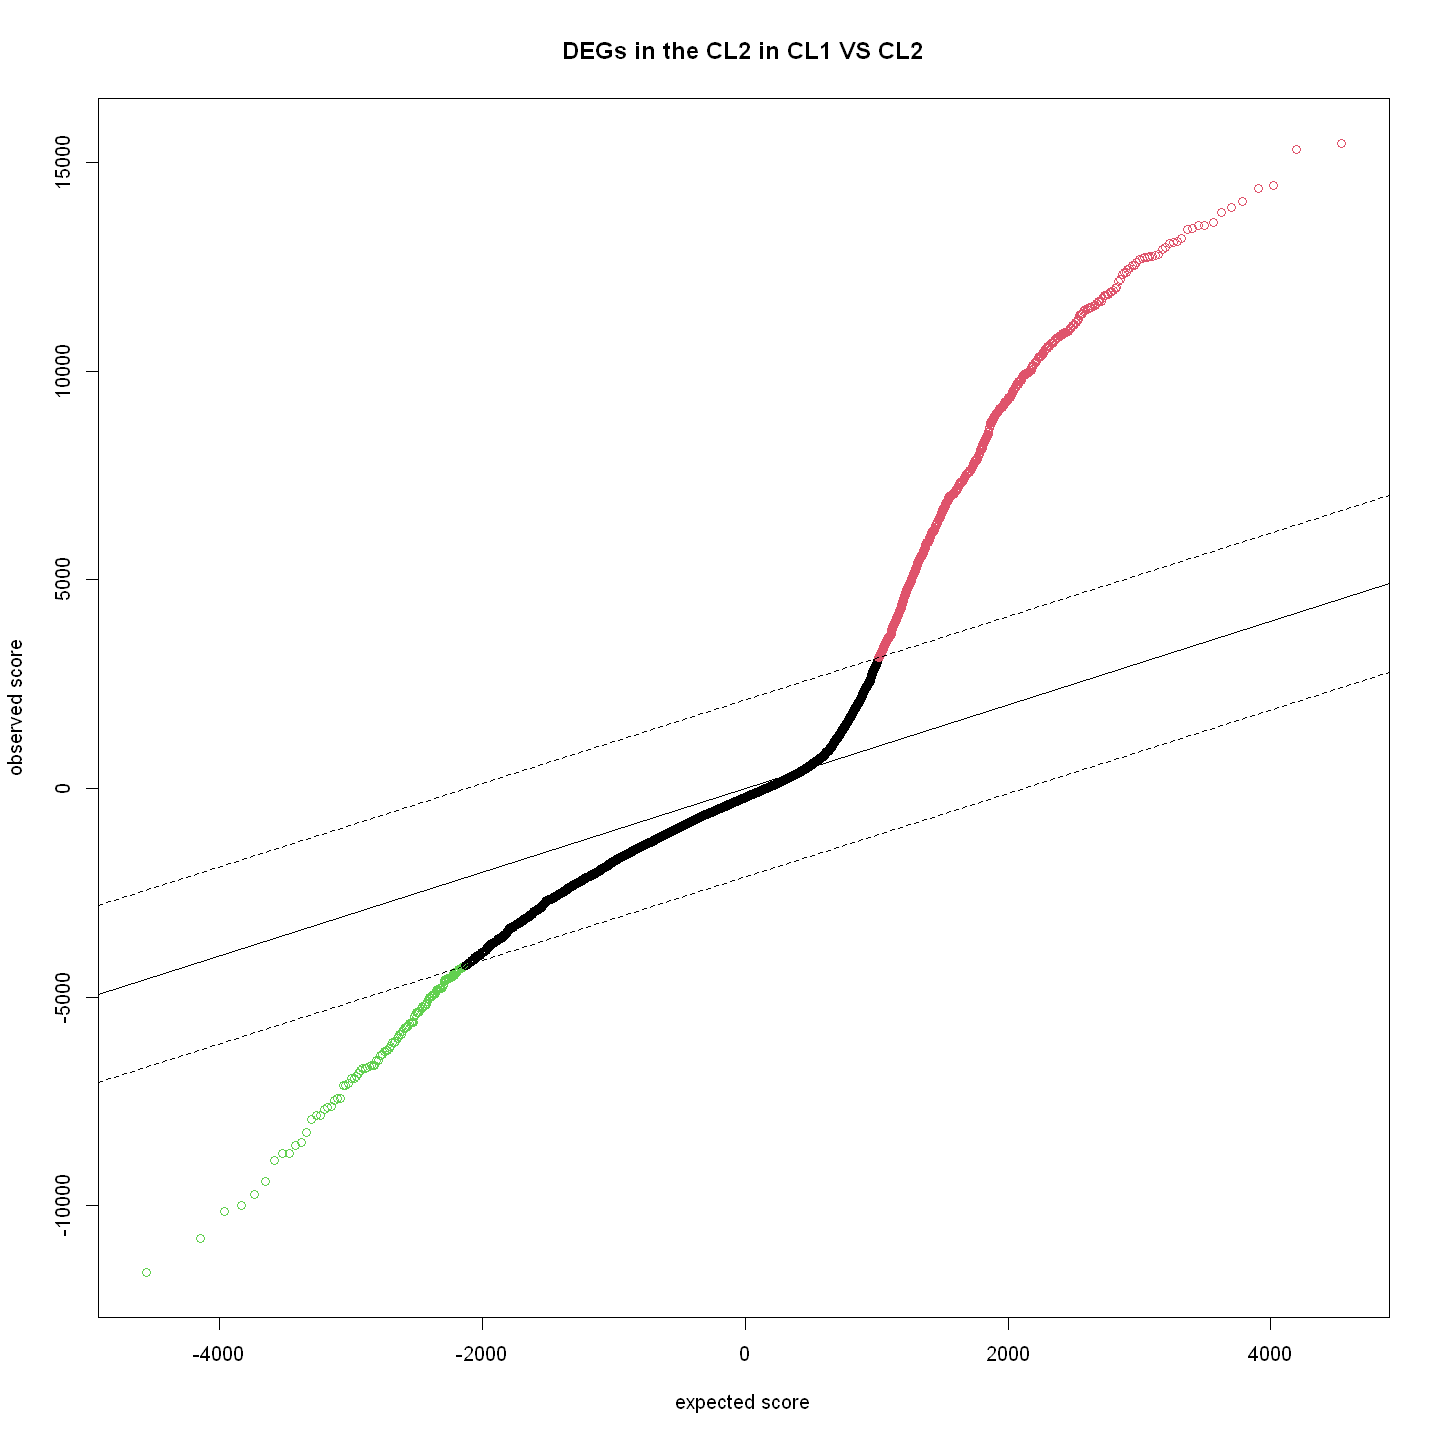

In [44]:
memory.limit(size=95000)    # Increasing the memory
FGcdiff1_2<-DEGanalysis2clust(FG,Clustering="K-means",K=4,fdr=0.01,name="CL1_vs_CL2",First = "CL1", Second = "CL2",export = TRUE,quiet=T)   ####### differential expression analysis between all clusters
#### To show the result table
head(FGcdiff1_2[[1]])                  # The first component 
head(FGcdiff1_2[[2]])                  # The second component

#### 3.2  Identifying DEGs using binomial differential expression

In [45]:
FGcdiffBinomial<-ClustDiffGenes(FG,K=4,export = T,fdr=.01,quiet=T)    ########## Binomial differential expression analysis
#### To show the result table
head(FGcdiffBinomial[[1]])                  # The first component 
head(FGcdiffBinomial[[2]])                  # The second component

DEGsE           DEGsS  
[1,] ENSG00000000938 FGR    
[2,] ENSG00000001036 FUCA2  
[3,] ENSG00000001630 CYP51A1
[4,] ENSG00000002586 CD99   
[5,] ENSG00000003147 ICA1   
[6,] ENSG00000003402 CFLAR

Target Cluster VS                 Gene number File name           Gene number
1 NA             NA                   NA        NA                   NA        
2 NA             NA                   NA        NA                   NA        
3 Cluster 3      Remaining Clusters 1346        Up-DEG-cluster3.csv 790        
4 Cluster 4      Remaining Clusters    3        Up-DEG-cluster4.csv   0        
  File name            
1 NA                   
2 NA                   
3 Down-DEG-cluster3.csv
4 Down-DEG-cluster4.csv

#### Plotting the DEGs

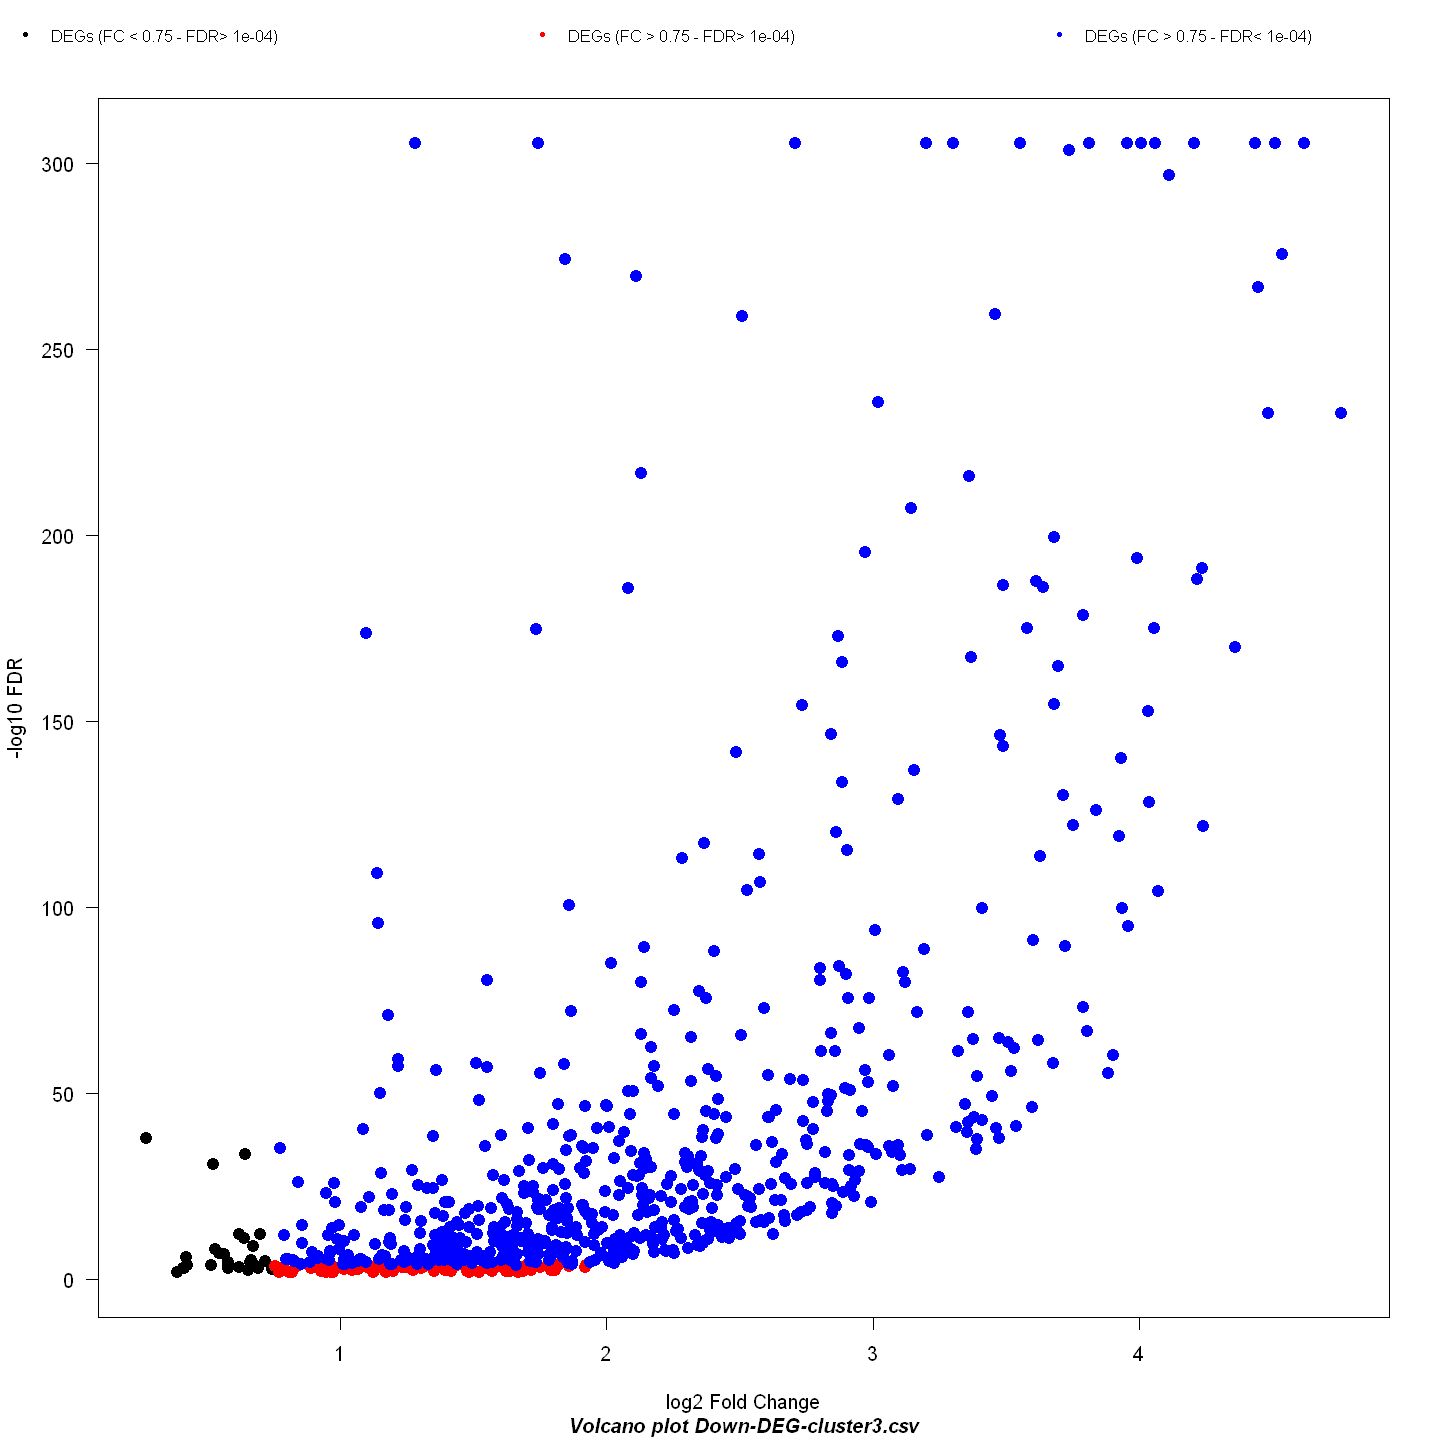

In [47]:
name<-FGcdiffBinomial[[2]][3,4]    ############ Selecting the DEGs' ############## Down-DEG-cluster1.csv
U<-read.csv(file=paste0(name),head=TRUE,sep=",")
Vplot<-VolcanoPlot(U,value=0.0001,name=name,FS=1,fc=0.75)

### 4. Identifying biomarkers (decision trees and networking analysis) 

In [48]:
sigDEG<-FGcdiffBinomial[[1]]        # DEGs gene list from Binomial analysis
First="CL3"
Second="CL4"
FGDATAforDT<-ClassVectoringDT(FG,Clustering="K-means",K=4,First=First,Second=Second,sigDEG)

The DEGs filtered normalized dataset contains:
Genes: 2136
cells: 909



J48 pruned tree
------------------

YWHAH <= 2.485448: CL3 (322.0/1.0)
YWHAH > 2.485448
|   PTCRA <= 0.844507
|   |   PEA15 <= 0.545646: CL4 (14.0/1.0)
|   |   PEA15 > 0.545646: CL3 (11.0)
|   PTCRA > 0.844507: CL4 (562.0)

Number of Leaves  : 	4

Size of the tree : 	7




=== Summary ===

Correctly Classified Instances         907               99.78   %
Incorrectly Classified Instances         2                0.22   %
Kappa statistic                          0.9953
Mean absolute error                      0.0042
Root mean squared error                  0.046 
Relative absolute error                  0.9123 %
Root relative squared error              9.5525 %
Total Number of Instances              909     

=== Confusion Matrix ===

   a   b   <-- classified as
 332   1 |   a = CL3
   1 575 |   b = CL4

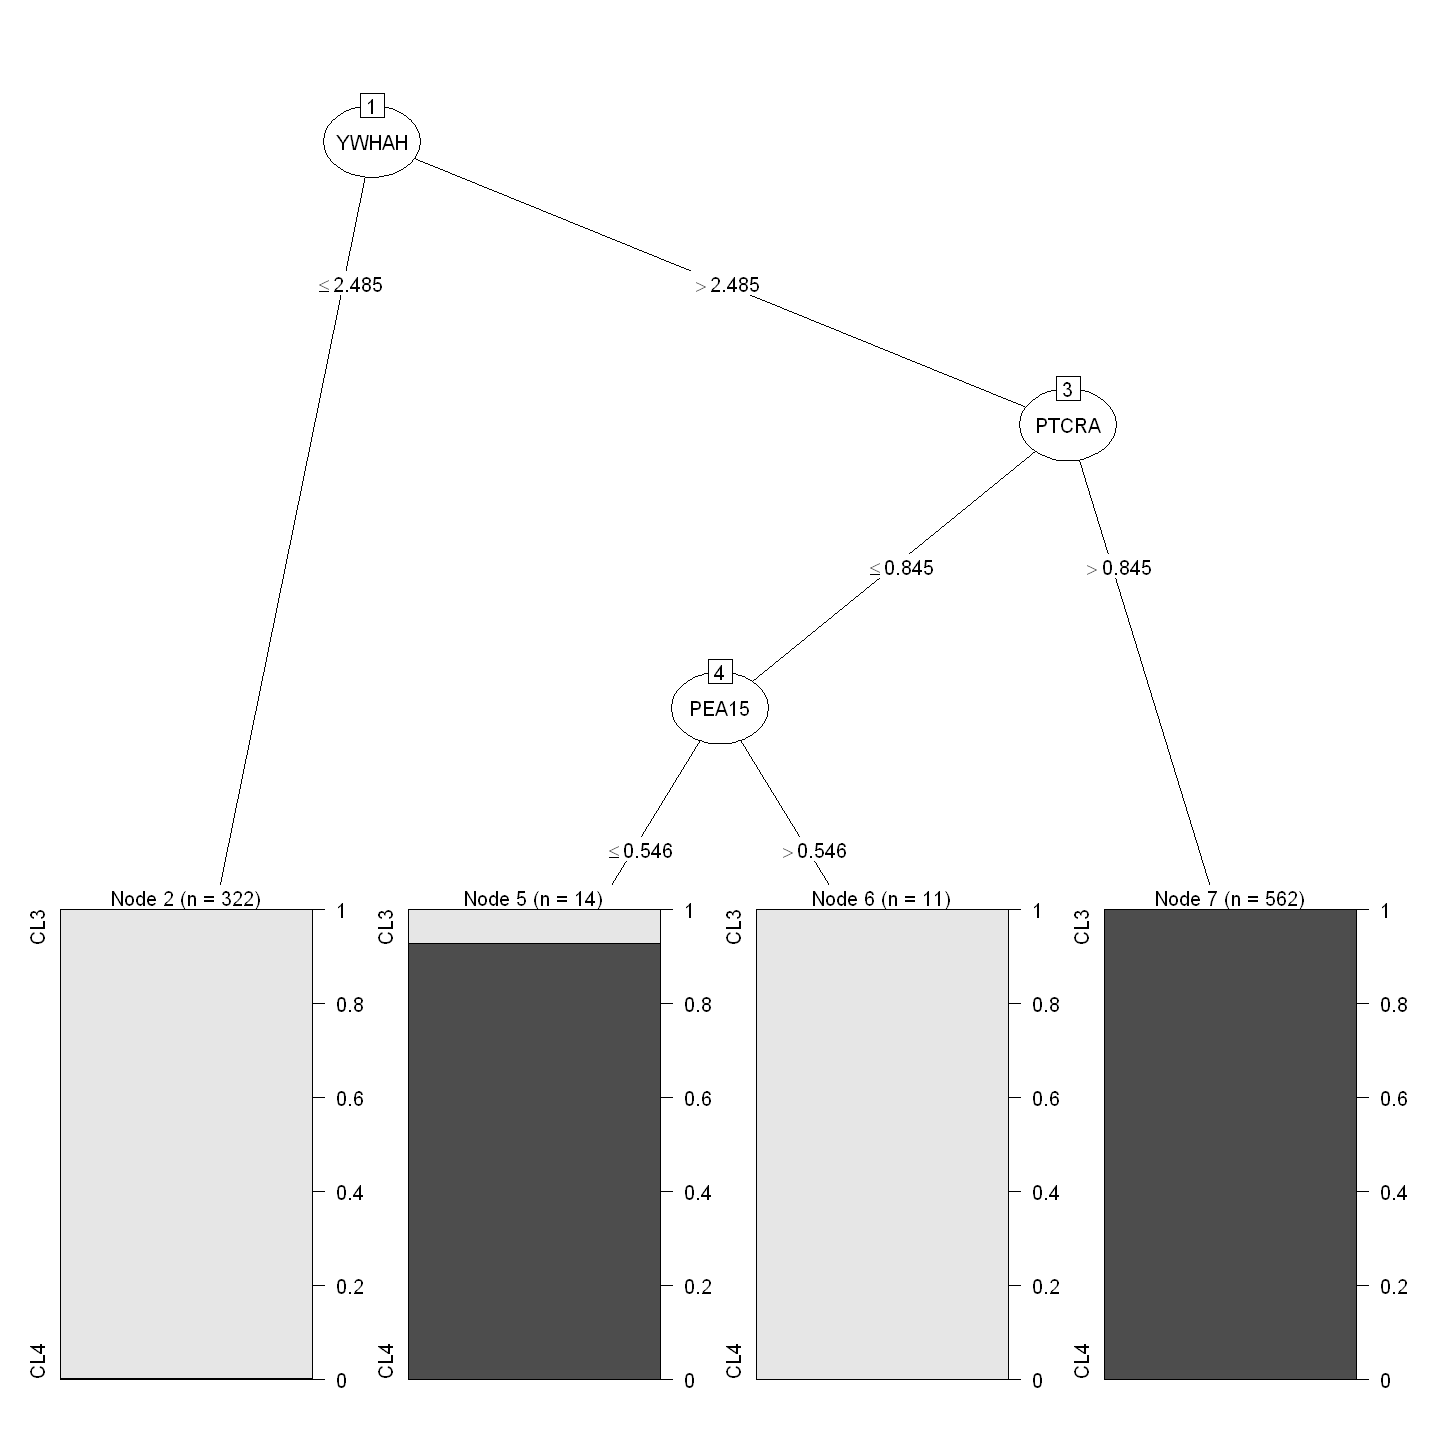

In [49]:
j48dt<-J48DT(FGDATAforDT)           #J48 Decision Tree
summary(j48dt) 

In [50]:
j48dt<-J48DTeval(FGDATAforDT,num.folds=10,First=First,Second=Second)

Fold 1 of 10

Fold 2 of 10

Fold 3 of 10

Fold 4 of 10

Fold 5 of 10

Fold 6 of 10

Fold 7 of 10

Fold 8 of 10

Fold 9 of 10

Fold 10 of 10



 TP  FN  FP  TN 
327   6   4 572 
             CL3 CL4
PredictedCL3 327   4
PredictedCL4   6 572


J48 SN: 0.98
J48 SP: 0.99
J48 ACC: 0.99
J48 MCC: 0.98




n= 909 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 909 333 CL4 (0.366336634 0.633663366)  
   2) YWHAH< 2.495651 322   1 CL3 (0.996894410 0.003105590)  
     4) RIOK3< 5.532748 321   0 CL3 (1.000000000 0.000000000) *
     5) RIOK3>=5.532748 1   0 CL4 (0.000000000 1.000000000) *
   3) YWHAH>=2.495651 587  12 CL4 (0.020442930 0.979557070)  
     6) PF4< 0.1469055 8   0 CL3 (1.000000000 0.000000000) *
     7) PF4>=0.1469055 579   4 CL4 (0.006908463 0.993091537)  
      14) DSTN>=7.45938 4   1 CL3 (0.750000000 0.250000000)  
        28) CFLAR< 6.60945 3   0 CL3 (1.000000000 0.000000000) *
        29) CFLAR>=6.60945 1   0 CL4 (0.000000000 1.000000000) *
      15) DSTN< 7.45938 575   1 CL4 (0.001739130 0.998260870)  
        30) TMEM132A>=1.087652 1   0 CL3 (1.000000000 0.000000000) *
        31) TMEM132A< 1.087652 574   0 CL4 (0.000000000 1.000000000) *


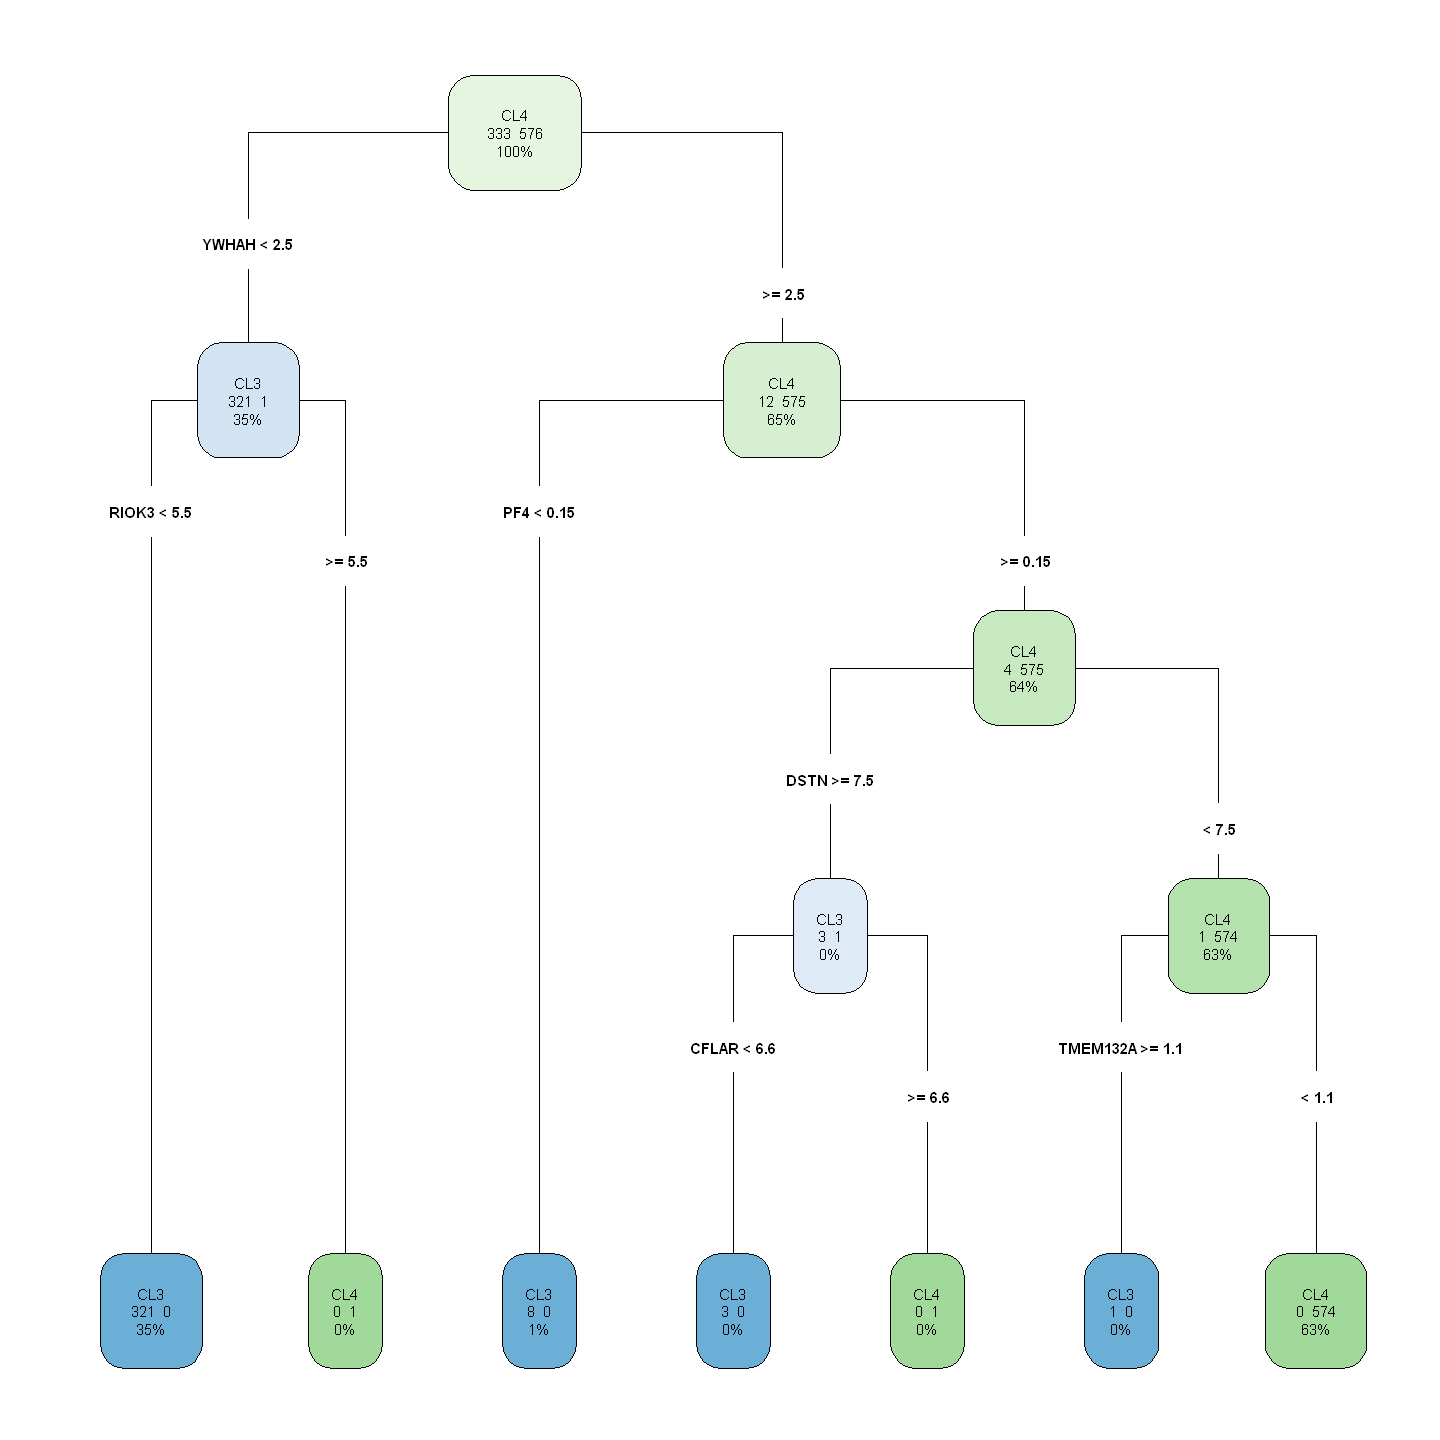

In [51]:
rpartDT<-RpartDT(FGDATAforDT)

In [52]:
rpartEVAL<-RpartEVAL(FGDATAforDT,num.folds=10,First=First,Second=Second)

Fold 1 of 10

Fold 2 of 10

Fold 3 of 10

Fold 4 of 10

Fold 5 of 10

Fold 6 of 10

Fold 7 of 10

Fold 8 of 10

Fold 9 of 10

Fold 10 of 10



 TP  FN  FP  TN 
326   7   9 567 
             CL3 CL4
PredictedCL3 326   9
PredictedCL4   7 567


Rpart SN: 0.98
Rpart SP: 0.98
Rpart ACC: 0.98
Rpart MCC: 0.96




###  Networking Analysis

Examine response components = 200	(200 means successful)


No encoding supplied: defaulting to UTF-8.

Number of nodes: 109

Number of links: 555

Link Density: 5.09174311926605

The connectance of the graph: 0.0471457696228338

Mean Distences2.22046908315565

Average Path Length2.22046908315565




names    degree betweenness
8   CDH1     34     261.410750 
34  HSP90AA1 34     322.993430 
82  HSPA8    32      81.725870 
35  EEF1A1   28      79.373619 
87  RPLP0    26      37.834978 
1   CCND1    25      20.474986 
53  HSP90AB1 25     110.909439 
72  RPL31    25      97.870513 
38  RPL3     24      51.637105 
49  RPL5     24      50.650993 
69  CCT4     24      81.190837 
50  JUN      23     176.620382 
20  RPS23    22      13.316667 
30  HSPA5    22      65.782670 
56  RPL10A   22      39.752814 
19  CCT3     20      23.513070 
78  RPS24    20       9.287576 
80  RPL37A   20      33.643132 
5   FOXA1    19      38.608272 
90  RPS5     19       0.000000 
21  NPM1     18      19.903546 
60  GATA3    18     133.875397 
68  RPL24    18      23.239759 
93  MUC1     18       0.000000 
22  HSPA9    17      17.810989 
74  AGR2     17      35.304401 
85  NACA     17       7.031818 
88  KRT8     17      22.007648 
67  HSPD1    16       4.185714 
3   CANX     15      88.248399 
... ...      ...    ...        
25  TBCA     3       7.000000  
41  ENAH     3       9.945238  
46  OAT      3       0.000000  
99  BST2     3       0.000000  
102 LTF      3       0.000000  
24  TM4SF1   2       2.000000  
36  SPINT1   2       0.000000  
42  IRF6     2      10.866667  
52  DHCR24   2       1.000000  
55  TSPAN1   2       5.000000  
63  CALML5   2       0.000000  
75  PERP     2       0.000000  
77  SLC9A3R2 2       0.000000  
97  DUSP4    2       0.000000  
98  SLC12A2  2       0.000000  
103 DSTN     2       0.000000  
45  S100A16  1       0.000000  
47  MYO6     1       0.000000  
62  RHOBTB3  1       0.000000  
71  TTC3     1       0.000000  
73  NFATC4   1       0.000000  
79  ELP2     1       0.000000  
91  CRABP2   1       0.000000  
95  SYNGR2   1       0.000000  
104 S100P    1       0.000000  
105 ID3      1       0.000000  
106 MRPL51   1       0.000000  
107 ZC3H13   1       0.000000  
108 TUFT1    1       0.000000  
109 GALNT6   1       0.000000

Examine response components =200	(200 means successful)


You can see the network with high resolutionby clicking on the following link:
https://string-db.org/api/highres_image/network?identifiers=MGST1%0dERBB3%0dHSP90AA1%0dRPLP0%0dPEBP1%0dEZR%0dHSP90AB1%0dDSP%0dXBP1%0dRPL3%0dGSPT1%0dHSPB1%0dAGR2%0dGATA3%0dHSPA8%0dCCND1%0dKRT18%0dMGP%0dRPL24%0dMLPH%0dSDC1%0dDHCR24%0dPRDX1%0dEPCAM%0dNR4A1%0dSOX4%0dCANX%0dFOXA1%0dKRT7%0dCRABP2%0dTUFT1%0dSELENBP1%0dNDUFS6%0dPLK2%0dBTF3%0dTFF1%0dAZGP1%0dS100A11%0dELF3%0dS100P%0dSHROOM1%0dUQCRQ%0dTM4SF1%0dKRT8%0dAGR3%0dCALML5%0dTACSTD2%0dMUC1%0dMYO6%0dEMP2%0dRPL41%0dCD24%0dLTF%0dHSPA5%0dSLC12A2%0dRPL31%0dRPS5%0dBTG2%0dTFF3%0dNUPR1%0dJUN%0dRPL37A%0dMRPL51%0dBST2%0dRAN%0dGALNT6%0dCOX8A%0dGAS5%0dCDH1%0dLAPTM4A%0dPERP%0dSLC39A6%0dHSPD1%0dPIP%0dRSL1D1%0dS100A14%0dSLC25A5%0dTOB1%0dENAH%0dHSPA9%0dCLEC3A%0dACBD3%0dNACA%0dCOX7A2%0dLGALS3%0dRPS24%0dEEF1A1%0dSPINT1%0dPOLR2L%0dNQO1%0dPHLDA2%0dRPS23%0dRPL10A%0dTSTD1%0dIRF6%0dID3%0dHINT1%0dSYNGR2%0dTSPAN1%0dRPL5%0dELP2%0

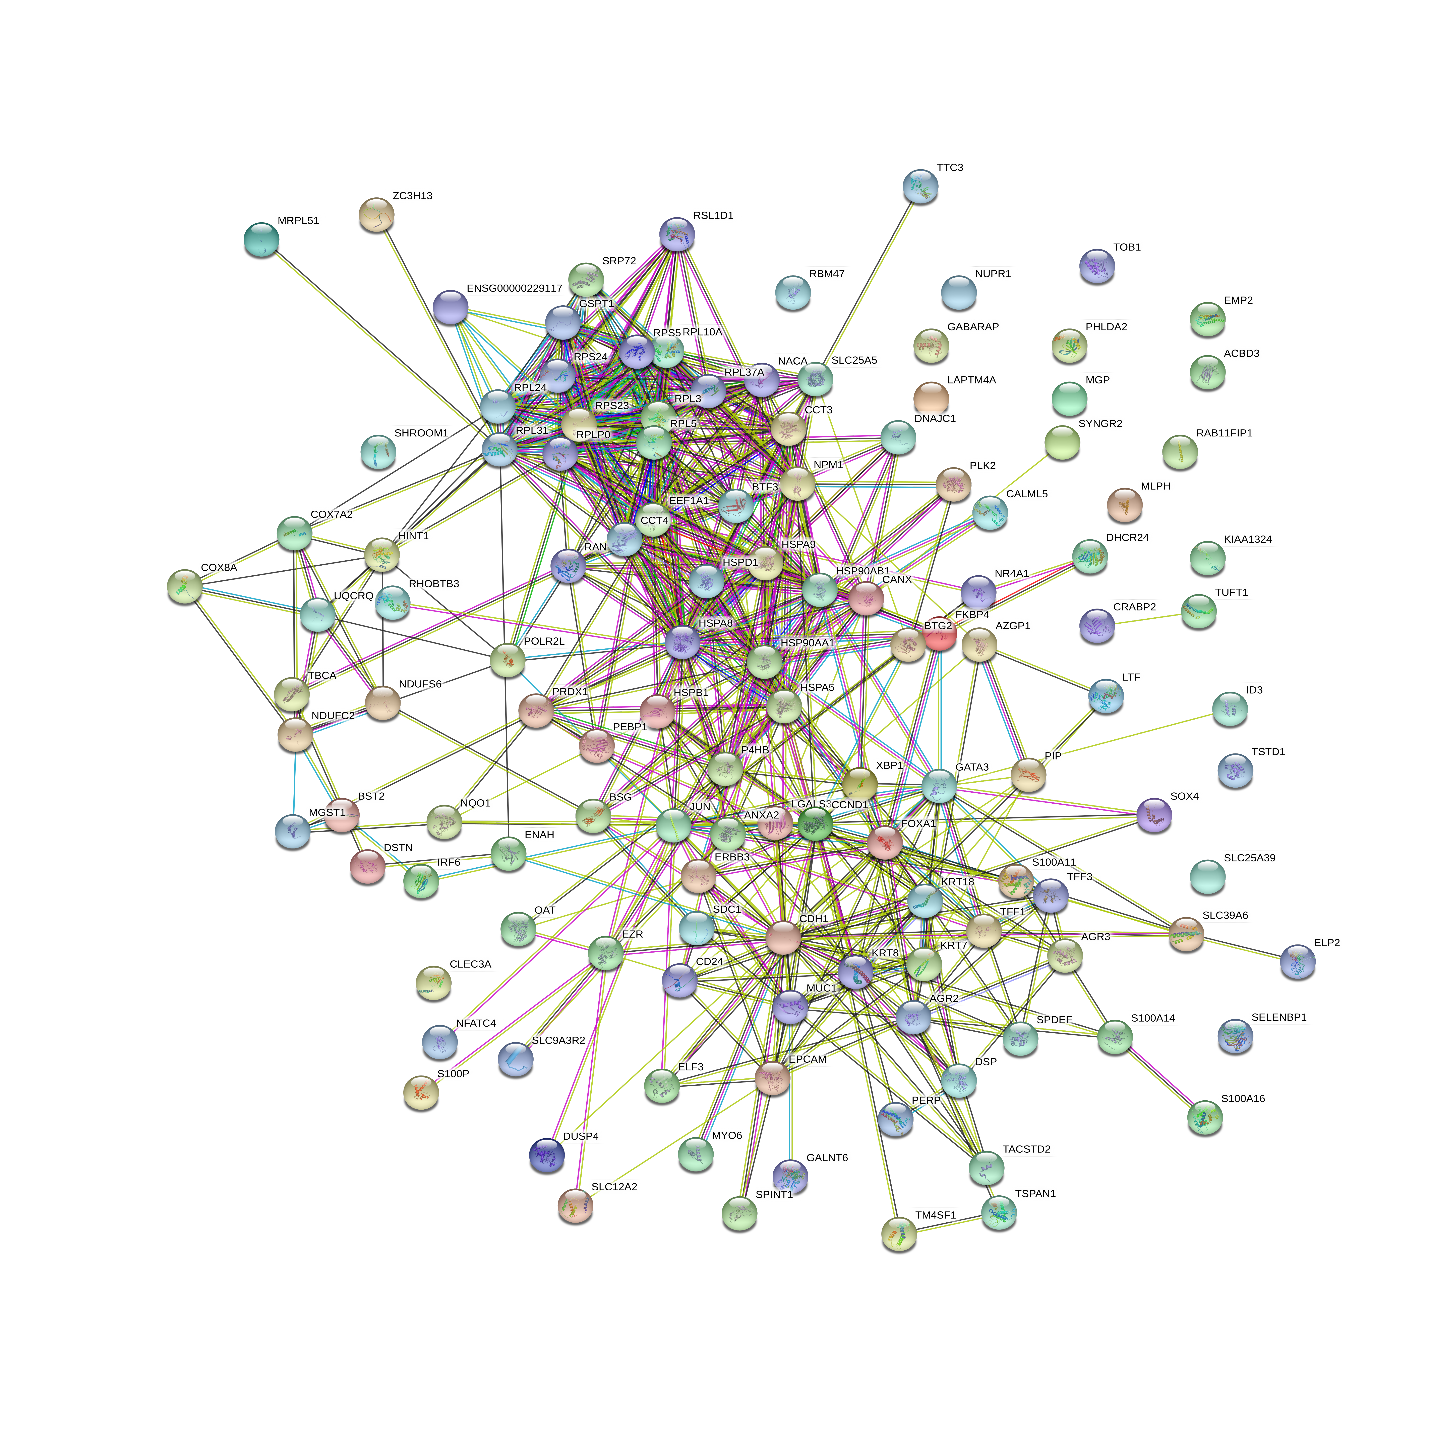

In [53]:
############ Selecting the DEGs' table  ##############
DEGs=FGcdiff1_2[[2]][2,6]                                # Up-regulated in cluster 1 (from SAMseq results)
data<-read.csv(file=paste0(DEGs),head=TRUE,sep=",")
data<-data[,3]                   

ppi<-PPI(data)

networking<-NetAnalysis(ppi)
networking                            ##### In case the Examine response components = 200 and an error "linkmat[i, ]" appeared, that means there are no PPI.

network<-Networking(data)

### Gene Enrichment Analysis

In [55]:
############ Selecting the DEGs' table  ##############
DEGs=FGcdiffBinomial[[2]][3,4]         # Up-regulated genes in cluster 1 (from the Binomial analysis)
#DEGs=FGcdiff1_2[[2]][2,6]             # Up-regulated in cluster 3 (from SAMseq results)

data<-read.csv(file=paste0(DEGs),head=TRUE,sep=",")
data<-as.character(data[,3])

dbs <- c("KEGG_2013","GO_Biological_Process_2015")
enriched <- enrichr(data, dbs)
KEGG_2013<-enriched[[1]][,c(1,2,3,9)]
GO_Biological_Process_2015<-enriched[[2]][,c(1,2,3,9)]

GEA<-rbind(KEGG_2013,GO_Biological_Process_2015)
GEA

Uploading data to Enrichr... Done.
  Querying KEGG_2013... Done.
  Querying GO_Biological_Process_2015... Done.
Parsing results... Done.


Term                                                                                                                                                
1    HSA03010 RIBOSOME                                                                                                                                   
2    HSA00190 OXIDATIVE PHOSPHORYLATION                                                                                                                  
3    HSA03050 PROTEASOME                                                                                                                                 
4    HSA04110 CELL CYCLE                                                                                                                                 
5    HSA00240 PYRIMIDINE METABOLISM                                                                                                                      
6    HSA00020 CITRATE CYCLE                                                                                                                              
7    HSA00100 BIOSYNTHESIS OF STEROIDS                                                                                                                   
8    HSA03060 PROTEIN EXPORT                                                                                                                             
9    HSA00010 GLYCOLYSIS AND GLUCONEOGENESIS                                                                                                             
10   HSA00062 FATTY ACID ELONGATION IN MITOCHONDRIA                                                                                                      
11   HSA00900 TERPENOID BIOSYNTHESIS                                                                                                                     
12   HSA05110 CHOLERA INFECTION                                                                                                                          
13   HSA04520 ADHERENS JUNCTION                                                                                                                          
14   HSA00650 BUTANOATE METABOLISM                                                                                                                       
15   HSA00720 REDUCTIVE CARBOXYLATE CYCLE                                                                                                                
16   HSA00510 N GLYCAN BIOSYNTHESIS                                                                                                                      
17   HSA00230 PURINE METABOLISM                                                                                                                          
18   HSA00530 AMINOSUGARS METABOLISM                                                                                                                     
19   HSA03020 RNA POLYMERASE                                                                                                                             
20   HSA04115 P53 SIGNALING PATHWAY                                                                                                                      
21   HSA00030 PENTOSE PHOSPHATE PATHWAY                                                                                                                  
22   HSA01031 GLYCAN STRUCTURES BIOSYNTHESIS 2                                                                                                           
23   HSA00280 VALINE LEUCINE AND ISOLEUCINE DEGRADATION                                                                                                  
24   HSA00630 GLYOXYLATE AND DICARBOXYLATE METABOLISM                                                                                                    
25   HSA01040 POLYUNSATURATED FATTY ACID BIOSYNTHESIS                                                                                                    
2